# Risk Transfer and Climate Immobility ABM

The code below is for the agent-based model (ABM) used in the paper Choquette-Levy, N. et al (2021). Risk transfer policies and climate-induced immobility among smallholder farmers", Nature Climate Change (in preparation).

It is split into four sections:

- Model functions
- Initial parameters
- Model loop
- Plots

Users should be able to run the model by executing the cells sequentially through the first three sections. The code for the Plots sections takes saved output data from the model loop (in numpy, or .npy format) as inputs.

For any questions or inquiries, please contact Nicolas Choquette-Levy at nc8@princeton.edu


## Section 1: Model Functions

In [ ]:
### Functions - Income Distributions and Adjustments based on number of farm laborers/household migrants

import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.signal import spectrogram
import networkx as nx
import pandas as pd
import bisect
import seaborn as sns
from sympy import symbols, solve
from time import process_time

#Function that calculates Weibull scale parameter from mean and shape parameter
def wei_scale(mean, shape):
    scale = (mean / math.gamma(1 + 1 / shape))
    
    return scale

#Function that calculates annual farm mean as a function of time, starting income and end income
def annual_mean_income(start_mean, end_mean, strategy, start_shape, end_shape, time, t):
    delta_mean = end_mean - start_mean
    delta_shape = end_shape - start_shape
    if t <= time:
        mean = start_mean + delta_mean * t / time
        shape = start_shape + delta_shape * t / time

    else:
        mean = end_mean
        shape = end_shape
        
    if strategy == 'Migrate':
        mean_income = math.exp(mean + shape ** 2 / 2)
        std_dev = math.sqrt((math.exp(shape ** 2) - 1) * (math.exp(2 * mean + shape ** 2)))
        
    else:
        mean_income = mean * math.gamma(1 + 1 / shape)
        std_dev = math.sqrt(mean ** 2 * (math.gamma(1 + 2 / shape) - (math.gamma(1 + 1 / shape)) ** 2))

    return mean_income, std_dev


#Function that adjusts farm income based on labor available
def pi_farm(income, starting_size, household_size, hill_1):
    if household_size == starting_size:
        farm_income = income
    else:
        farm_income = income * (household_size) ** hill_1 / (1 + household_size ** hill_1)
    
    return farm_income

#Function that solves for base farm value (i.e. farm with all households present) based on observed farm income and number of laborers
def inverse_farm(farm_income, starting_size, migrants, hill_1):
    
    laborers = int(starting_size - migrants)
    if laborers == starting_size:
        adjustment_factor = 1
    else:
        adjustment_factor = laborers ** hill_1 / (1 + laborers ** hill_1)
    
    
    base_farm_income = farm_income / adjustment_factor
    
    
    return base_farm_income

#Function that calculates household remittances based on number of household migrants
def remit(migrants, migration_return, hill_2):
    m = int(migrants)
    if m == 0:
        remittances = 0
    else:
        running_remit = 0
        for i in range(m):
            running_remit += (migration_return * (1 - i ** hill_2 / (1 + i ** hill_2)))
        remittances = running_remit

    return remittances

#Function that solves for base migration value based on household remittances and number of migrants
def inverse_remit(migrants, household_remittances, hill_2):
    m = int(migrants)
    
    adjustment_factor = 1
    if m > 1:
        for i in range(m-1):
            adjustment_factor += (1 - (i+1) ** hill_2 / (1 + (i+1) ** hill_2))
            
    base_remittance = household_remittances / adjustment_factor
            
    return base_remittance

In [3]:
#Functions - Setting up household social networks (for Layers 2-4) and assigning educational characteristics (Layers 3-4)

# Function that assigns each agent a number of social connections based on power law distribution
def number_connections(min_size, max_size, gamma):
        j = int((((max_size) ** (gamma + 1) - min_size ** (gamma + 1)) * random.random() + min_size ** (gamma + 1)) ** (1 / (gamma + 1)))
        print(j)
        return j

#Function that sets up social network
def social_network(households, connections):
    household_connections = {}
    for a in range(households):
        household_connections.update({a: connections[a]})
    sorted_households = sorted(household_connections, key=household_connections.__getitem__, reverse=True)

    network = nx.DiGraph()
    vertices = str(households)
    
    h = nx.path_graph(households)
    network.add_nodes_from(h)
    
    for n in range(households):
        house = sorted_households[n]

        edges = int(household_connections[house])
        count = 0
        #Choose random edges for each number of connection
        while count < edges:
            neighbor = int(random.random() * households)
            if network.in_degree(neighbor) >= connections[neighbor] or neighbor == house:
                count += 0
            else:
                network.add_edge(house, neighbor)
                count += 1
    return network

#Function that creates a distribution of education levels
def educate(households, edu_dict):
    education_level = [''] * households
    for a in range(households):
        if np.random.random() > (1 - educ_dict['tertiary'][0]):
            education_level[a] = 'Tertiary'
        elif np.random.random() > (1 - educ_dict['tertiary'][0] - educ_dict['secondary'][0]):
            education_level[a] = 'Secondary'
        else:
            education_level[a] = 'Primary'
    
    return education_level

#Function that assigns initial wealth based on education level
def educ_assign(households, education_level, edu_dict):
    init_savings = np.zeros(households)
    risk_aversion = np.zeros(households)
    objective_weight = np.zeros(households)
    attributes = []
    
    for a in range(households):
        if education_level[a] == 'Tertiary':
            init_savings[a] = np.random.exponential(scale=educ_dict['tertiary'][1])
            risk_aversion[a] = np.random.normal(educ_dict['tertiary'][2], educ_dict['tertiary'][3])
            objective_weight[a] = np.random.normal(educ_dict['tertiary'][4], educ_dict['tertiary'][5])

        elif education_level[a] == 'Secondary':
            init_savings[a] = np.random.exponential(scale=educ_dict['secondary'][1])
            risk_aversion[a] = np.random.normal(educ_dict['secondary'][2], educ_dict['secondary'][3])
            objective_weight[a] = np.random.normal(educ_dict['secondary'][4], educ_dict['secondary'][5])
            
        else:
            init_savings[a] = np.random.exponential(scale=educ_dict['primary'][1])
            risk_aversion[a] = np.random.normal(educ_dict['primary'][2], educ_dict['primary'][3])
            objective_weight[a] = np.random.normal(educ_dict['primary'][4], educ_dict['primary'][5])

            
        attributes.append([init_savings[a], risk_aversion[a], objective_weight[a]])
    
    return attributes
        

# Function that adjusts migration cost as a function of social networks
def migrate_cost_adjust(migration_cost, household_migrants, starting_size, household_network, total_pop, i): 
    network_pop = starting_size[i]
    network_migrants = household_migrants[i]
    
    for a in range(households):
        if a in household_network[i]:
            network_migrants += household_migrants[a]
            network_pop += starting_size[a]
        else:
            network_migrants += 0
    
    network_migrant_proportion = network_migrants / network_pop
    
    adjusted_cost = migration_cost * 1/ (math.exp(network_migrant_proportion))
    return(adjusted_cost)


In [4]:
#Functions - Creating climate effects, including adjusting crop yields, sampling droughts, creating separate income distributions for drought vs. non-drought years


#Function that determines overall crop yield due to climate effects in year t - Note: no longer adjusts for drought (this is done later)
def climate_effects(start_temp, final_temp, time, mu, spei_temp_coef, sigma, bau_threshold, diverse_threshold, yield_coef, t):
    #Calculating temperature increase and change in distribution of droughts due to warming
    temp_increment = (final_temp - start_temp) / time
    mu_t = mu + temp_increment * t * spei_temp_coef
    
    #Calling climate functions
    bau_drought_status, diverse_drought_status = drought_sampling(mu_t, sigma, bau_threshold, diverse_threshold)
    
    yield_shift = temp_crop_yield(temp_increment, yield_coef, time, t)
    
    crop_adjustment_factor = -yield_shift #Indicates starting crop yield is reduced by a fraction equal to yield_shift

    return crop_adjustment_factor, bau_drought_status, diverse_drought_status

#Function that adjusts farm productivity as a function of long-term temperature change
def temp_crop_yield(temp_increment, yield_coef, time, t):
    yield_shift = (temp_increment * yield_coef) * t #Percent decrease in crops from initial conditions due to long-temr effects
    return yield_shift

#Function that determines if a drought occurs in year t by sampling a distribution
def drought_sampling(mu, sigma, bau_threshold, diverse_threshold):
    random = np.random.normal(mu, sigma, 1)
    if random < bau_threshold:
        bau_drought = 1
    else:
        bau_drought = 0
    if random < diverse_threshold:
        diverse_drought = 1
    else:
        diverse_drought = 0
    
    return bau_drought, diverse_drought

#Function that calculates probability of drought in year t based on 1000 simulations of SPEI distribution
def drought_probability(start_temp, final_temp, time, t, spei_temp_coef, tau_b, tau_d):
    delta_t = (final_temp - start_temp) / time * t
    spei_mean = delta_t * spei_temp_coef
    samples = 1000
    spei_distr = np.zeros(samples)
    
    for step in range(samples):
        spei_distr[step] = norm.ppf((step / samples), loc=spei_mean)
    
    drought_bau = sum(p < tau_b for p in spei_distr)
    drought_diverse = sum(q < tau_d for q in spei_distr)
    
    p_bau = drought_bau / samples
    p_diverse = drought_diverse / samples
    
    probability = {'BAU': p_bau, 'Diverse': p_diverse}
    
    return probability

#Function that sets up a maximum income threshold to use for drought use
def drought_income_threshold(bau_scale, diverse_scale, bau_k, diverse_k, p_bau, p_diverse):
    bau_distribution = bau_scale * np.random.weibull(bau_k, size=1000)
    diverse_distribution = diverse_scale * np.random.weibull(diverse_k, size=1000)
    
    bau_threshold = np.percentile(bau_distribution, (100*p_bau))
    diverse_threshold = np.percentile(diverse_distribution, (100*p_diverse))
    
    return bau_threshold, diverse_threshold

#Function that sets up income distributions based on drought and non-drought conditions
def drought_income_distributions(bau_scale, bau_k, diverse_scale, diverse_k, bau_threshold, diverse_threshold):
    income_distribution = {'BAU':[], 'Diverse':[]}
    bau_distribution = bau_scale * np.random.weibull(bau_k, size=1000)
    diverse_distribution = diverse_scale * np.random.weibull(diverse_k, size=1000)
    
    #Sorting distributions in ascending order
    sorted_bau = list(np.sort(bau_distribution))
    sorted_diverse = list(np.sort(diverse_distribution))
    
    #Inserting the pre-determined threshold in sorted distributions and calculating how many values are below this threshold
    bisect.insort(sorted_bau, bau_threshold)
    bisect.insort(sorted_diverse, diverse_threshold)
    bau_index = sorted_bau.index(bau_threshold)
    diverse_index = sorted_diverse.index(diverse_threshold)
    
    #Creating split distributions
    bau_drought_income = sorted_bau[0:bau_index]
    bau_regular_income = sorted_bau[bau_index:1000]
    diverse_drought_income = sorted_diverse[0:diverse_index]
    diverse_regular_income = sorted_diverse[diverse_index:1000] 
    
    #Seeding drought distributions with 1 value if there are no values in current distribution
    if len(bau_drought_income) == 0:
        bau_drought_income = [0,0,0]
    if len(diverse_drought_income) == 0:
        diverse_drought_income = [0,0,0]
    
    income_distribution['BAU'] = (bau_drought_income, bau_regular_income)
    income_distribution['Diverse'] = (diverse_drought_income, diverse_regular_income)
    
    return income_distribution            


#Function that samples from different parts of income distribution based on drought conditions
def farm_income_sampling(bau_drought_income, bau_regular_income, diverse_drought_income, diverse_regular_income):  

    bau_drought_income = random.choice(bau_drought_income) 
    bau_regular_income = random.choice(bau_regular_income)
    
    diverse_drought_income = random.choice(diverse_drought_income)
    diverse_regular_income = random.choice(diverse_regular_income)
        
    return bau_drought_income, bau_regular_income, diverse_drought_income, diverse_regular_income

In [5]:
#Functions - Main household decision-making functions, including forming perceptions from social networks, weighting perceptions with objective information, sorting strategy options by utility, selecting strategy


#Function that allows an agent to search negibhors' networks for strategy information, if he/she has no immediate inforamtion
def information_search(strategy, households, household_network, perception, drought_perception, secondary_network, i):
    #Add loops that iterate over already-defined household networks (too long to do for loops)
    
    missing_strategy = str(strategy)
    instruction = 'Search'
    count = 0
    perceived_pi = 0
    perceived_var = 0
    perceived_drought = 0

    #Checking if a first-degree neighbor has a non-zero perception of the strategy
    for house in household_network[i]:
        a = int(house)
        if instruction == 'Search':
            payoff_perception = perception[a][missing_strategy][0]
        
            if payoff_perception == 0 or payoff_perception == 'nan':
                instruction = 'Search'
            else:
                instruction = 'Stop'
                perceived_pi = payoff_perception
                perceived_var = perception[a][missing_strategy][1]
                
                if missing_strategy != 'Migrate':
                    perceived_drought = drought_perception[a][missing_strategy]
                                              
    #Checking if a second-degree neighbor has a non-zero perception of the strategy
    if instruction == 'Search':
        for house in secondary_network:
            b = int(house)
            if instruction == 'Search':
                payoff_perception = perception[b][missing_strategy][0]
                if payoff_perception == 0 or payoff_perception == 'nan':
                    instruction == 'Search'
                else:
                    instruction == 'Stop'
                    perceived_pi = payoff_perception
                    perceived_var = perception[b][missing_strategy][1]
                    if missing_strategy != 'Migrate':
                        perceived_drought = drought_perception[b][missing_strategy]
                                              
    #If both loops above fail, sampling population at random until we find a non-zero strategy
    while (instruction == 'Search') & (count < 100):
        count += 1
        household = np.random.randint(0, households)
        payoff_perception = perception[household][missing_strategy][0]
            
        if payoff_perception == 0 or payoff_perception == 'nan':
            instruction = 'Search'
        else:
            instruction = 'Stop'
            perceived_pi = payoff_perception
            perceived_var = perception[household][missing_strategy][1]
            if missing_strategy != 'Migrate':
                perceived_drought = drought_perception[household][missing_strategy]
    

    return perceived_pi, perceived_var, perceived_drought

#Function to create an initial distribution of perceived strategy mean income and standard deviation for each household
def perception_init(memory, p_drought_bau, bau_scale, planner_bau_income, bau_regular_avg_income, bau_k, bau_regular_std, p_drought_diverse, diverse_scale, planner_diverse_income, diverse_regular_avg_income, diverse_k, diverse_regular_std, migrate_mean_income, migrate_k):
    perceived_init = {'BAU':[0], 'BAU_Insurance':[0], 'Diverse':[0], 'Diverse_Insurance':[0], 'Migrate':[0]}
    
    #Re-calculating k parameter of Weibull distributions for insurance options, given different std deviations and mean
    
    bau_insurance_mean = p_drought_bau * planner_bau_income + (1 - p_drought_bau) * bau_regular_avg_income
    diverse_insurance_mean = p_drought_diverse * planner_diverse_income + (1 - p_drought_diverse) * diverse_regular_avg_income    
    bau_insurance_k = (bau_regular_std / bau_insurance_mean) ** -1.086
    diverse_insurance_k = (diverse_regular_std / diverse_insurance_mean) ** -1.086
    
    bau_insurance_scale = wei_scale(bau_insurance_mean, bau_insurance_k)
    diverse_insurance_scale = wei_scale(diverse_insurance_mean, diverse_insurance_k)
    
    
    bau_distribution = bau_scale * np.random.weibull(bau_k, memory)
    bau_insurance_distribution = bau_insurance_scale * np.random.weibull(bau_insurance_k, memory)
    diverse_distribution = diverse_scale * np.random.weibull(diverse_k, memory)
    diverse_insurance_distribution = diverse_insurance_scale * np.random.weibull(diverse_insurance_k, memory) #need to update k factors for insurance distributions
    migrate_distribution = np.random.lognormal(migrate_start_income, migrate_k, memory)
    
    perceived_init['BAU'] = bau_distribution
    perceived_init['BAU_Insurance'] = bau_insurance_distribution
    perceived_init['Diverse'] = diverse_distribution
    perceived_init['Diverse_Insurance'] = diverse_insurance_distribution
    perceived_init['Migrate'] = migrate_distribution
    
    return perceived_init    


#Function that calculates perceived payoffs of strategies based on network information
def perceived_pi(secondary_effects, perception_init, memory, starting_size, household_size, household_network, perception, drought_perception, household_savings, farm_strategy, household_remittances, remittances_received, remittances_shared, household_income, bau_cost, diverse_cost, migrate_cost, bau_drought_threshold, diverse_drought_threshold, bau_prem, diverse_prem, remittance_beta, cash_transfer, subsidies, household_migrants, trip_status, theta, t, i):
    perceived_pi = {'BAU':0, 'BAU_Insurance':0, 'Diverse':0, 'Diverse_Insurance':0, 'Migrate':0}
    
    init_bau_drought = 0
    init_diverse_drought = 0
    
    #Keeps running list of payoffs for each strategy among network (these are separated from own payoffs in case we want to weight those differently in the future)
    neighbor_count = 0 #Counts direct neighbors of household i
    network_bau_payoffs = []
    network_bau_insurance_payoffs = []
    network_bau_count = 0
    network_bau_insurance_count = 0
    network_bau_drought = 0
    
    network_diverse_payoffs = []
    network_diverse_insurance_payoffs = []
    network_diverse_count = 0
    network_diverse_insurance_count = 0
    network_diverse_drought = 0
    
    network_migrate_payoffs = []
    network_migrate_count = 0
    
    neighbor_network = [] #List that will contain neighbors of household i's neighbors
    already_counted = [] #Creates list that stores numbers of households already counted (to prevent double-counting)
    secondary_count = 0 #Counts neighbors of household i's neighbors (that aren't themselves direct neighbors of i)
    secondary_bau_payoffs = []
    secondary_bau_insurance_payoffs = []
    secondary_bau_count = 0
    secondary_bau_insurance_count = 0
    secondary_bau_drought = 0
    
    secondary_diverse_payoffs = []
    secondary_diverse_insurance_payoffs = []
    secondary_diverse_count = 0
    secondary_diverse_insurance_count = 0
    secondary_diverse_drought = 0
    
    secondary_migrate_payoffs = []
    secondary_migrate_count = 0
    
    #Creating time frame from (t-memory, t), unless t < memory, in which case give agents init observations
    starter_perceptions = len(perception_init['BAU'])
    if t < starter_perceptions:
        start = 0
        init_observations = starter_perceptions - t
        bau_init_observations = perception_init['BAU'][-init_observations:]
        bau_insurance_init_observations = perception_init['BAU_Insurance'][-init_observations:]
        diverse_init_observations = perception_init['Diverse'][-init_observations:]
        diverse_insurance_init_observations = perception_init['Diverse_Insurance'][-init_observations:]
        migrate_init_observations = perception_init['Migrate'][-init_observations:]
        
        for e in range(init_observations):
            if bau_init_observations[e] < bau_drought_threshold:
                init_bau_drought += 1
            if diverse_init_observations[e] < diverse_drought_threshold:
                init_diverse_drought += 1
    else:
        start = max((t - memory),0)
        init_observations = 0
        bau_init_observations = []
        bau_insurance_init_observations = []
        diverse_init_observations = []
        diverse_insurance_init_observations = []
        migrate_init_observations = []
        
    #Loop for first-degree neighbors
    for a in range(households):
        
        if a in household_network[i]:
            neighbor_network.append(household_network[a])
            neighbor_count += 1
            already_counted.append(a)
            
            for b in range(start, t):
                strategy = farm_strategy[b][a]
                
                if trip_status[b,a] == 1:
                    migrate_expense = migrate_cost[b,a]
                    migrants = household_migrants[b,a] - 1 #i.e. revenue-generating migrants
                else:
                    migrate_expense = 0
                    migrants = household_migrants[b,a]
                
                if migrants > 0:
                    network_migrate_count += 1
                    #observed_income = (household_remittances[b,a] - remittances_shared[b,a] + remittances_received[b,a]) / household_migrants[b,a]
                    observed_remittances = (household_remittances[b,a] - remittances_shared[b,a] + remittances_received[b,a])
                    observed_income = inverse_remit(migrants, observed_remittances, hill_2)
                    #print('Primary network', observed_income)
                    network_migrate_payoffs.append(observed_income)
            
                #Normalizes observed farm income to a full household                
                if strategy == 'BAU':
                    total_farm_income = (household_income[b,a] + bau_cost + migrate_expense - household_remittances[b,a] - remittances_received[b,a] + remittances_shared[b,a] - cash_transfer)
                    observed_farm_income = inverse_farm(total_farm_income, starting_size[a], household_migrants[b,a], hill_1) #this takes household_migrants instead of migrants becasue migrants who leave in that time step don't contribute to farm income
                    network_bau_count += 1
                    network_bau_payoffs.append(observed_farm_income)
                    if observed_farm_income <= bau_drought_threshold:
                        network_bau_drought += 1
                                            
                elif strategy == 'BAU_Insurance':
                    total_farm_income = (household_income[b,a] + bau_cost + bau_prem[b] + migrate_expense - household_remittances[b,a] - remittances_received[b,a] + remittances_shared[b,a] - cash_transfer)
                    observed_farm_income = inverse_farm(total_farm_income, starting_size[a], household_migrants[b,a], hill_1)
                    network_bau_insurance_count += 1
                    network_bau_insurance_payoffs.append(observed_farm_income)
                    #if observed_farm_income <= bau_drought_threshold:
                        #network_bau_drought += 1
                    
                elif strategy == 'Diverse_Insurance':
                    total_farm_income = (household_income[b,a] + diverse_cost + diverse_prem[b] + migrate_expense - household_remittances[b,a] - remittances_received[b,a] + remittances_shared[b,a] - cash_transfer)
                    observed_farm_income = inverse_farm(total_farm_income, starting_size[a], household_migrants[b,a], hill_1)
                    network_diverse_insurance_count += 1
                    network_diverse_insurance_payoffs.append(observed_farm_income)
                    #if observed_farm_income <= diverse_drought_threshold:
                        #network_diverse_drought += 1
                    
                elif strategy == 'Diverse':
                    total_farm_income = (household_income[b,a] + diverse_cost + migrate_expense - household_remittances[b,a] - remittances_received[b,a] + remittances_shared[b,a] - cash_transfer)
                    observed_farm_income = inverse_farm(total_farm_income, starting_size[a], household_migrants[b,a], hill_1)
                    network_diverse_count += 1
                    network_diverse_payoffs.append(observed_farm_income)
                    if observed_farm_income <= diverse_drought_threshold:
                        network_diverse_drought += 1

    #Loop for second-degree neighbors
    if secondary_effects == 'off':
        secondary_network = ['']
        
    else:
        for neighbor in range(neighbor_count):
            secondary_network = neighbor_network[neighbor] #List of neighbors of one of household i's neighbors
            
            for d in range(households):
                if (d in secondary_network) & (d not in already_counted): #Ensures that we are not double-counting i's direct neighbors or previously counted secondary neighbors
                    secondary_count += 1
                    already_counted.append(d)

                    for year in range(start, t-1):
                        secondary_strategy = farm_strategy[year][d]
                        
                        if trip_status[year,d] == 1:
                            migrate_expense = migrate_cost[year,d]
                            migrants = household_migrants[year,d] - 1 #i.e. revenue-generating migrants
                        else:
                            migrate_expense = 0
                            migrants = household_migrants[year,d]
                        
                        if migrants > 0:
                            secondary_migrate_count += 1
                            #observed_income = (household_remittances[year,d] - remittances_shared[year,d] + remittances_received[year,d]) / household_migrants[year,d]
                            observed_remittances = (household_remittances[year,d] - remittances_shared[year,d] + remittances_received[year,d])
                            observed_income = inverse_remit(migrants, observed_remittances, hill_2)
                            secondary_migrate_payoffs.append(observed_income)
                                                                        
                        if secondary_strategy == 'BAU':
                            total_farm_income = (household_income[year,d] + bau_cost + migrate_expense - household_remittances[year,d] - remittances_received[year,d] + remittances_shared[year,d] - cash_transfer) 
                            observed_farm_income = inverse_farm(total_farm_income, starting_size[d], household_migrants[year,d], hill_1)
                            secondary_bau_count += 1
                            secondary_bau_payoffs.append(observed_farm_income)
                            if observed_farm_income <= bau_drought_threshold:
                                secondary_bau_drought += 1
                                
                        elif secondary_strategy == 'BAU_Insurance':
                            total_farm_income = (household_income[year,d] + bau_cost + bau_prem[year] + migrate_expense - household_remittances[year,d] - remittances_received[year,d] + remittances_shared[year,d] - cash_transfer) 
                            observed_farm_income = inverse_farm(total_farm_income, starting_size[d], household_migrants[year,d], hill_1)
                            secondary_bau_insurance_count += 1
                            secondary_bau_insurance_payoffs.append(observed_farm_income)
                            #if observed_farm_income <= bau_drought_threshold:
                                #secondary_bau_drought += 1

                        elif secondary_strategy == 'Diverse':
                            total_farm_income = (household_income[year,d] + diverse_cost + migrate_expense - household_remittances[year,d] - remittances_received[year,d] + remittances_shared[year,d] - cash_transfer) 
                            observed_farm_income = inverse_farm(total_farm_income, starting_size[d], household_migrants[year,d], hill_1)
                            secondary_diverse_count += 1
                            secondary_diverse_payoffs.append(observed_farm_income)
                            if observed_farm_income <= diverse_drought_threshold:
                                secondary_diverse_drought += 1
                                
                        elif secondary_strategy == 'Diverse_Insurance':
                            total_farm_income = (household_income[year,d] + diverse_cost + diverse_prem[year] + migrate_expense - household_remittances[year,d] - remittances_received[year,d] + remittances_shared[year,d] - cash_transfer) 
                            observed_farm_income = inverse_farm(total_farm_income, starting_size[d], household_migrants[year,d], hill_1)
                            secondary_diverse_insurance_count += 1
                            secondary_diverse_insurance_payoffs.append(observed_farm_income)
                            #if observed_farm_income <= diverse_drought_threshold:
                                #secondary_diverse_drought += 1

    #Calculating average payoffs of each strategy for the household itself
    self_bau_payoffs = []
    self_bau_count = 0
    self_bau_drought = 0
    
    self_bau_insurance_payoffs = []
    self_bau_insurance_count = 0
    
    self_diverse_payoffs = []
    self_diverse_count = 0
    self_diverse_drought = 0
    
    self_diverse_insurance_payoffs = []
    self_diverse_insurance_count = 0
    
    self_migrate_payoffs = []
    self_migrate_count = 0
    
    for e in range(start, t):
        year_strategy = farm_strategy[e]
        strategy = year_strategy[i]

        if trip_status[e,i] == 1:
            migrate_expense = migrate_cost[e,i]
            migrants = household_migrants[e,i] - 1 #i.e. revenue-generating migrants
        else:
            migrate_expense = 0
            migrants = household_migrants[e,i]
        
        if migrants > 0:
            self_migrate_count += 1
            #observed_income = (household_remittances[e,i] - remittances_shared[e,i] + remittances_received[e,i]) / household_migrants[e,i]
            observed_remittances = (household_remittances[e,i] - remittances_shared[e,i] + remittances_received[e,i])
            observed_income = inverse_remit(migrants, observed_remittances, hill_2)
            self_migrate_payoffs.append(observed_income)
                                                
        if strategy == 'BAU':
            total_farm_income = (household_income[e,i] + bau_cost + migrate_expense - household_remittances[e,i] - remittances_received[e,i] + remittances_shared[e,i] - cash_transfer) 
            observed_farm_income = inverse_farm(total_farm_income, starting_size[i], household_migrants[e,i], hill_1)
            self_bau_count += 1
            self_bau_payoffs.append(observed_farm_income)
            if observed_farm_income <= bau_drought_threshold:
                self_bau_drought += 1
        
        elif strategy == 'BAU_Insurance':
            total_farm_income = (household_income[e,i] + bau_cost + bau_prem[e] + migrate_expense - household_remittances[e,i] - remittances_received[e,i] + remittances_shared[e,i] - cash_transfer) 
            observed_farm_income = inverse_farm(total_farm_income, starting_size[i], household_migrants[e,i], hill_1)
            self_bau_insurance_count += 1
            self_bau_insurance_payoffs.append(observed_farm_income)
            #if observed_farm_income <= bau_drought_threshold:
                #self_bau_drought += 1
                    
        elif strategy == 'Diverse':
            total_farm_income = (household_income[e,i] + diverse_cost + migrate_expense - household_remittances[e,i] - remittances_received[e,i] + remittances_shared[e,i] - cash_transfer)
            observed_farm_income = inverse_farm(total_farm_income, starting_size[i], household_migrants[e,i], hill_1)
            self_diverse_count += 1
            self_diverse_payoffs.append(observed_farm_income)
            if observed_farm_income <= diverse_drought_threshold:
                self_diverse_drought += 1
                
        elif strategy == 'Diverse_Insurance':
            total_farm_income = (household_income[e,i] + diverse_cost + diverse_prem[e] + migrate_expense - household_remittances[e,i] - remittances_received[e,i] + remittances_shared[e,i] - cash_transfer) 
            observed_farm_income = inverse_farm(total_farm_income, starting_size[i], household_migrants[e,i], hill_1)
            self_diverse_insurance_count += 1
            self_diverse_insurance_payoffs.append(observed_farm_income)
            #if observed_farm_income <= diverse_drought_threshold:
                #self_diverse_drought += 1
    
    #Calculate expectation and variance of utilities from own memories and network, weighting each observation equally
    if (init_observations + self_bau_count + network_bau_count + secondary_bau_count) == 0:
        household_info = information_search('BAU', households, household_network, perception, drought_perception, secondary_network, i)
        perceived_bau_avg = household_info[0]
        perceived_bau_var = household_info[1]
        perceived_drought_bau = household_info[2]
        
    else:
        combined_bau = np.concatenate((bau_init_observations, self_bau_payoffs, network_bau_payoffs, secondary_bau_payoffs))
        perceived_bau_avg = np.average(combined_bau)
        perceived_bau_var = np.std(combined_bau)
        perceived_drought_bau = (init_bau_drought + self_bau_drought + network_bau_drought + secondary_bau_drought) / (init_observations + self_bau_count + network_bau_count + secondary_bau_count)
        
    if (init_observations + self_bau_insurance_count + network_bau_insurance_count + secondary_bau_insurance_count) == 0:
        household_info = information_search('BAU_Insurance', households, household_network, perception, drought_perception, secondary_network, i)
        perceived_bau_insurance_avg = household_info[0]
        perceived_bau_insurance_var = (1 - perceived_drought_bau) * household_info[1]
        
    else:
        combined_bau_insurance = np.concatenate((bau_insurance_init_observations, self_bau_insurance_payoffs, network_bau_insurance_payoffs, secondary_bau_insurance_payoffs))
        perceived_bau_insurance_avg = np.average(combined_bau_insurance)
        perceived_bau_insurance_var = (1 - perceived_drought_bau) * np.std(combined_bau_insurance)
    
    
    if (init_observations + self_diverse_count + network_diverse_count + secondary_diverse_count) == 0:
        household_info = information_search('Diverse', households, household_network, perception, drought_perception, secondary_network, i)
        perceived_diverse_avg = household_info[0]
        perceived_diverse_var = household_info[1]
        perceived_drought_diverse = household_info[2]

    else:
        combined_diverse = np.concatenate((diverse_init_observations, self_diverse_payoffs, network_diverse_payoffs, secondary_diverse_payoffs))
        perceived_diverse_avg = np.average(combined_diverse)
        perceived_diverse_var = np.std(combined_diverse)
        perceived_drought_diverse = (init_diverse_drought + self_diverse_drought + network_diverse_drought + secondary_diverse_drought) / (init_observations + self_diverse_count + network_diverse_count + secondary_diverse_count)
        
            
    if (init_observations + self_diverse_insurance_count + network_diverse_insurance_count + secondary_diverse_insurance_count) == 0:
        household_info = information_search('Diverse_Insurance', households, household_network, perception, drought_perception, secondary_network, i)
        perceived_diverse_insurance_avg = household_info[0]
        perceived_diverse_insurance_var = (1 - perceived_drought_diverse) * household_info[1]
        
    else:
        combined_diverse_insurance = np.concatenate((diverse_insurance_init_observations, self_diverse_insurance_payoffs, network_diverse_insurance_payoffs, secondary_diverse_insurance_payoffs))
        perceived_diverse_insurance_avg = np.average(combined_diverse_insurance)
        perceived_diverse_insurance_var = (1 - perceived_drought_diverse) * np.std(combined_diverse_insurance)
                    
    if (init_observations + self_migrate_count + network_migrate_count + secondary_migrate_count) == 0:
        household_info = information_search('Migrate', households, household_network, perception, drought_perception, secondary_network, i)
        perceived_migrate_avg = household_info[0]
        #perceived_migrate_var = (1 - remittance_beta) * household_info[1]
        perceived_migrate_var = household_info[1]
    else:
        combined_migrate = np.concatenate((migrate_init_observations, self_migrate_payoffs, network_migrate_payoffs, secondary_migrate_payoffs))
        perceived_migrate_avg = np.average(combined_migrate)
        #perceived_migrate_var = (1 - remittance_beta) * np.std(combined_migrate)
        perceived_migrate_var = np.std(combined_migrate)
    #De-bugging code as diverse sometimes comes out with 'nan' for variance or mean
    
    if perceived_diverse_avg == 'nan':
        raise ValueError('For year:', t, 'household:', i, 'Diverse strategy mean perception has an issue')
        print('Self payoffs:', self_diverse_payoffs)
        print('First Network payoffs:', network_diverse_payoffs)
        print('Second Network payoffs;', secondary_diverse_payoffs)
        
    if perceived_diverse_var == 'nan':
        raise ValueError('For year:', t, 'household:', i, 'Diverse strategy variance perception has an issue')
        print('Self payoffs:', self_diverse_payoffs)
        print('First Network payoffs:', network_diverse_payoffs)
        print('Second Network payoffs;', secondary_diverse_payoffs)    
        
        
    perceived_pi = {'BAU': [perceived_bau_avg, perceived_bau_var], 'BAU_Insurance': [perceived_bau_insurance_avg, perceived_bau_insurance_var], 'Diverse': [perceived_diverse_avg, perceived_diverse_var], 'Diverse_Insurance':[perceived_diverse_insurance_avg, perceived_diverse_insurance_var], 'Migrate': [perceived_migrate_avg, perceived_migrate_var]}    
    perceived_drought = {'BAU': perceived_drought_bau, 'BAU_Insurance': perceived_drought_bau, 'Diverse': perceived_drought_diverse, 'Diverse_Insurance': perceived_drought_diverse}
    
    return perceived_pi, perceived_drought



#Function that weighs perceived income and objective income sources
def weighted_pi(objective_weight, social_perception, social_drought, household_savings, planner_bau_income, bau_regular_avg_income, planner_diverse_income, diverse_regular_avg_income, migrate_mean_income, planner_bau_std, bau_regular_std, planner_diverse_std, diverse_regular_std, migrate_std, p_drought_bau, p_drought_diverse, remittance_beta, theta, t, horizon):
    weighted_income = {'BAU':[], 'BAU_Insurance':[], 'Diverse':[], 'Diverse_Insurance':[], 'Migrate':[]}
    weighted_std = {'BAU':[], 'BAU_Insurance':[], 'Diverse':[], 'Diverse_Insurance':[], 'Migrate':[]}
    weighted_drought = {'BAU':[], 'BAU_Insurance':[], 'Diverse':[], 'Diverse_Insurance':[], 'Migrate':[]}
    
    end = t + horizon
    
    perceived_payoff = social_perception
    perceived_drought = social_drought
    perceived_drought['Migrate'] = 0
    
    #objective_payoff = {'BAU':bau_mean_income[t:end] , 'BAU Insurance':bau_regular_avg_income, 'Diverse':diverse_mean_income[t:end], 'Diverse Insurance':diverse_regular_avg_income, 'Migrate':migrate_mean_income[t:end]}
    
    objective_payoff = {'BAU':[], 'BAU_Insurance':[], 'Diverse':[], 'Diverse_Insurance':[], 'Migrate':[]}
    objective_std = {'BAU':[], 'BAU_Insurance':[], 'Diverse':[], 'Diverse_Insurance':[], 'Migrate':[]}
    objective_drought = {'BAU':p_drought_bau[t:end], 'BAU_Insurance':p_drought_bau[t:end], 'Diverse':p_drought_diverse[t:end], 'Diverse_Insurance': p_drought_diverse[t:end], 'Migrate':np.zeros(horizon)}
    
    for a in range(horizon):   
        objective_payoff['BAU'].append(planner_bau_income[t+a])
        objective_std['BAU'].append(planner_bau_std[t+a])
        
        objective_payoff['BAU_Insurance'].append(p_drought_bau[t+a] * planner_bau_income[t+a] + (1 - p_drought_bau[t+a]) * bau_regular_avg_income[t+a])
        objective_std['BAU_Insurance'].append((1 - p_drought_bau[t+a]) * bau_regular_std[t+a])
        
        objective_payoff['Diverse'].append(planner_diverse_income[t+a])
        objective_std['Diverse'].append(planner_diverse_std[t+a])
        
        objective_payoff['Diverse_Insurance'].append(p_drought_diverse[t+a] * planner_diverse_income[t+a] + (1 - p_drought_diverse[t+a]) * diverse_regular_avg_income[t+a])
        objective_std['Diverse_Insurance'].append((1 - p_drought_diverse[t+a]) * diverse_regular_std[t+a])
        
        objective_payoff['Migrate'].append(migrate_mean_income[t+a])
        objective_std['Migrate'].append((1 - remittance_beta) * migrate_std[t+a])
    
    
    for key in ['BAU', 'BAU_Insurance', 'Diverse', 'Diverse_Insurance', 'Migrate']:
        for a in range(horizon): 
            weighted_income[key].append(objective_weight * objective_payoff[key][a] + (1 - objective_weight) * perceived_payoff[key][0])
            weighted_std[key].append(objective_weight * objective_std[key][a] + (1 - objective_weight) * perceived_payoff[key][1])
            weighted_drought[key].append(objective_weight * objective_drought[key][a] + (1 - objective_weight) * perceived_drought[key])
    return weighted_income, weighted_std, weighted_drought

#Function that calculates negative utility of perceived risk associated with each livelihood strategy
def markowitz(expected_income, variance, vol_weight, household_savings, theta):
    
    mark_adjusted = expected_income - vol_weight * variance
    #mark_utility = utility(mark_adjusted, household_savings, theta) #Note - if this is commented out, utility is calculated without household savings as a reference
    
    return mark_adjusted

#New Function to calculate incremental utility of an expected income as a function of reference point and risk aversion
def utility(income, reference, theta):
    if theta == 1:
        if (income + reference) > 0:
            new_utils = np.log(income + reference)
        elif (income + reference) == 0:
            new_utils = 0
        else:
            new_utils = -np.log(-(income + reference))
        
        if reference > 0:
            old_utils = np.log(reference)
        elif reference == 0:
            old_utils = 0
        else:
            old_utils = -np.log(-reference)
        
    else:
        if (income + reference) >= 0:
            new_utils = ((income + reference) ** (1 - theta) - 1) / (1 - theta)
        else:
            new_utils = (-(-(income + reference)) ** (1 - theta) - 1) / (1 - theta)
        
        if reference >= 0:
            old_utils = (reference ** (1 - theta) - 1) / (1 - theta)
        else:
            old_utils = (-(-reference) ** (1 - theta) - 1) / (1 - theta)
        
    
    incremental_utils = new_utils - old_utils
    
    return new_utils



# Function that calculates adaptation strategy payoffs over next 'horizon' years as perceived by farmer in year t
def calc_pi(status, weighted_income, weighted_var, weighted_drought, household_savings, migrate_mean_income, remittance_beta, remittance_bank_take, migrants, trip_status, migration_cost, hill_1, diverse_mean_income, diverse_regular_mean_income, diverse_cost, diverse_prem, bau_mean_income, bau_regular_mean_income, bau_cost, bau_prem, starting_size, household_size, farm_strategy, delta, theta, vol_weight, cash_transfer, subsidies, t, horizon):
    pi = {}
    
    income_bau = np.zeros(horizon)
    std_bau = np.zeros(horizon)
    
    income_bau_insurance = np.zeros(horizon)
    std_bau_insurance = np.zeros(horizon)
    
    income_cropdiverse = np.zeros(horizon)
    std_cropdiverse = np.zeros(horizon)
    
    income_cropdiverse_insurance = np.zeros(horizon)
    std_cropdiverse_insurance = np.zeros(horizon)
    
    income_migrate = np.zeros(horizon)
    std_migrate = np.zeros(horizon)
    pi_status_quo = np.zeros(horizon)
    
    pi_migrate = np.zeros(horizon)
    pi_cropdiverse = np.zeros(horizon)
    pi_cropdiverse_insurance = np.zeros(horizon)
    pi_bau = np.zeros(horizon)
    pi_bau_insurance = np.zeros(horizon)

    #Checks if there are already migrants that can return back, and if there are remaining household members who could migrate
    if migrants[t-1] > 0:
        farm_potential_labor = household_size + 1
        farm_potential_migrant = migrants[t-1] - 1
        
    else:
        farm_potential_labor = household_size
        farm_potential_migrant = migrants[t-1]
        
    if household_size > 0:
        migrate_potential_migrant = migrants[t-1] + 1
        migrate_potential_labor = household_size - 1
    else:
        migrate_potential_migrant = migrants[t-1]
        migrate_potential_labor = household_size
    
    for n in range(0, horizon):
        #Creating dummy farm variables for tracking residual farm income for Migrate strategy
        if farm_strategy == 'BAU':
            farm_cost = bau_cost
            farm_income = bau_mean_income[t+n]
            perceived_income = weighted_income['BAU'][n]
        
        elif farm_strategy == 'BAU_Insurance':
            farm_cost = bau_cost + bau_prem
            farm_income = bau_mean_income[t+n]
            perceived_income = weighted_income['BAU_Insurance'][n]

        elif farm_strategy == 'Diverse_Insurance':
            farm_cost = diverse_cost + diverse_prem
            farm_income = diverse_mean_income[t+n]
            perceived_income = weighted_income['Diverse_Insurance'][n]
        
        elif farm_strategy == 'Diverse':           
            farm_cost = diverse_cost
            farm_income = diverse_mean_income[t+n]
            perceived_income = weighted_income['Diverse'][n]
        
        else:
            farm_cost = 0
            farm_income = 0
            perceived_income = 0
            
        if status == 'rational':
            pi_status_quo[n] = cash_transfer + pi_farm(farm_income, starting_size, household_size, hill_1) - farm_cost + remit(migrants[t-1], migrate_mean_income[t+n], hill_2)
            pi_cropdiverse[n] = cash_transfer + pi_farm(diverse_mean_income[t+n], starting_size, farm_potential_labor, hill_1) - diverse_cost + remit(farm_potential_migrant, migrate_mean_income[t+n], hill_2)
            pi_cropdiverse_insurance[n] = cash_transfer + pi_farm(diverse_regular_mean_income[t+n], starting_size, farm_potential_labor, hill_1) - (diverse_cost + diverse_prem) + remit(farm_potential_migrant, migrate_mean_income[t+n], hill_2)
            pi_bau[n] = cash_transfer + pi_farm(bau_mean_income[t+n], starting_size, farm_potential_labor, hill_1) - bau_cost + remit(farm_potential_migrant, migrate_mean_income[t+n], hill_2)
            pi_bau_insurance[n] = cash_transfer + pi_farm(bau_regular_mean_income[t+n], starting_size, farm_potential_labor, hill_1) - (bau_cost + bau_prem) + remit(farm_potential_migrant, migrate_mean_income[t+n], hill_2)
            
            if household_size == 0:
                pi_migrate[n] = cash_transfer + remit(migrants[t-1], migrate_mean_income[t+n], hill_2) #Indicates continuation of all household members migrating
                
            elif household_size == 1:
                if n == 0:
                    pi_migrate[n] = cash_transfer + remit(migrants[t-1], migrate_mean_income[t+n], hill_2) - migration_cost #Accounting for initial up-front cost
                else:
                    pi_migrate[n] = cash_transfer + remit(migrate_potential_migrant, migrate_mean_income[t+n], hill_2)
                
            else:
                if n == 0:
                    pi_migrate[n] = cash_transfer + remit(migrants[t-1], migrate_mean_income[t+n], hill_2) + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost - migration_cost
                else:
                    pi_migrate[n] = cash_transfer + remit(migrate_potential_migrant, migrate_mean_income[t+n], hill_2) + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost
            
        else:
            #Converting weighted utilities back into expected incomes
            gross_income_cropdiverse = weighted_income['Diverse'][n] + subsidies['Diverse']
            cropdiverse_std = weighted_var['Diverse'][n]
            diverse_drought = weighted_drought['Diverse'][n]
            
            gross_income_cropdiverse_insurance = weighted_income['Diverse_Insurance'][n] + subsidies['Diverse']
            cropdiverse_std_insurance = weighted_var['Diverse_Insurance'][n]
            
            gross_income_bau = weighted_income['BAU'][n] + subsidies['BAU']
            bau_std = weighted_var['BAU'][n]
            bau_drought = weighted_drought['BAU'][n]
            
            gross_income_bau_insurance = weighted_income['BAU_Insurance'][n] + subsidies['BAU']
            bau_std_insurance = weighted_var['BAU_Insurance'][n]
            
            if (subsidies['BAU'] == 0) & (subsidies['Diverse'] == 0): #only if household does not already receive a farming subsidy
                gross_income_migrate = weighted_income['Migrate'][n] + subsidies['Migrate']
            else:
                gross_income_migrate = weighted_income['Migrate'][n]
            migrate_std = weighted_var['Migrate'][n]
            
            if farm_strategy == 'BAU':
                farm_income = gross_income_bau
                farm_std = bau_std
            elif farm_strategy == 'BAU_Insurance':
                farm_income = gross_income_bau_insurance
                farm_std = bau_std_insurance
            elif farm_strategy == 'Diverse_Insurance':
                farm_income = gross_income_cropdiverse_insurance
                farm_std = cropdiverse_std_insurance
            elif farm_strategy == 'Diverse':
                farm_income = gross_income_cropdiverse
                farm_std = cropdiverse_std
            else:
                farm_income = 0
                farm_std = 0
            
            #Checking remittance sharing depending on potential household change
            new_migrant_remittance_sharing = remittance_disburse(migrate_potential_migrant, gross_income_migrate, remittance_bank_take, remittance_subsidy, hill_2)
            new_migrant_remittance_received = remittance_receiving(new_migrant_remittance_sharing, migrate_potential_migrant, remittance_beta, gross_income_migrate)
            
            same_migrant_remittance_sharing = remittance_disburse(migrants[t-1], gross_income_migrate, remittance_bank_take, remittance_subsidy, hill_2)
            same_migrant_remittance_received = remittance_receiving(same_migrant_remittance_sharing, migrants[t-1], remittance_beta, gross_income_migrate)
   
            farm_migrant_remittance_sharing = remittance_disburse(farm_potential_migrant, gross_income_migrate, remittance_bank_take, remittance_subsidy, hill_2)
            farm_migrant_remittance_received = remittance_receiving(farm_migrant_remittance_sharing, farm_potential_migrant, remittance_beta, gross_income_migrate) 
        
            income_cropdiverse[n] = cash_transfer + pi_farm(gross_income_cropdiverse, starting_size, farm_potential_labor, hill_1) - diverse_cost + remit(farm_potential_migrant, gross_income_migrate, hill_2) - farm_migrant_remittance_sharing + farm_migrant_remittance_received
            std_cropdiverse[n] = pi_farm(cropdiverse_std, starting_size, farm_potential_labor, hill_1) + remit(farm_potential_migrant, migrate_std, hill_2)
            
            income_cropdiverse_insurance[n] = cash_transfer + pi_farm(gross_income_cropdiverse_insurance, starting_size, farm_potential_labor, hill_1) - (diverse_cost + diverse_prem) + remit(farm_potential_migrant, gross_income_migrate, hill_2) - farm_migrant_remittance_sharing + farm_migrant_remittance_received
            std_cropdiverse_insurance[n] = pi_farm(cropdiverse_std_insurance, starting_size, farm_potential_labor, hill_1) + remit(farm_potential_migrant, migrate_std, hill_2)
            
            income_bau[n] = cash_transfer + pi_farm(gross_income_bau, starting_size, farm_potential_labor, hill_1) - bau_cost + remit(farm_potential_migrant, gross_income_migrate, hill_2) - farm_migrant_remittance_sharing + farm_migrant_remittance_received
            std_bau[n] = pi_farm(bau_std, starting_size, farm_potential_labor, hill_1) + remit(farm_potential_migrant, migrate_std, hill_2)
            
            income_bau_insurance[n] = cash_transfer + pi_farm(gross_income_bau_insurance, starting_size, farm_potential_labor, hill_1) - (bau_cost + bau_prem) + remit(farm_potential_migrant, gross_income_migrate, hill_2) - farm_migrant_remittance_sharing + farm_migrant_remittance_received
            std_bau_insurance[n] = pi_farm(bau_std_insurance, starting_size, farm_potential_labor, hill_1) + remit(farm_potential_migrant, migrate_std, hill_2)
            
            if n == 0:
                income_migrate[n] = cash_transfer + remit(migrants[t-1], gross_income_migrate, hill_2) - migration_cost + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost - same_migrant_remittance_sharing + same_migrant_remittance_received
                std_migrate[n] =remit(migrants[t-1], migrate_std, hill_2) + pi_farm(farm_std, starting_size, migrate_potential_labor, hill_1)
            else:
                income_migrate[n] = cash_transfer + remit(migrate_potential_migrant, gross_income_migrate, hill_2) + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost - new_migrant_remittance_sharing + new_migrant_remittance_received
                std_migrate[n] = remit(migrate_potential_migrant, migrate_std, hill_2) + pi_farm(farm_std, starting_size, migrate_potential_labor, hill_1)
            
            pi_bau[n] = markowitz(income_bau[n], std_bau[n], vol_weight, household_savings, theta)  / (1 + delta) ** n
            pi_bau_insurance[n] = markowitz(income_bau_insurance[n], std_bau_insurance[n], vol_weight, household_savings, theta) / (1 + delta) ** n
            pi_cropdiverse[n] = markowitz(income_cropdiverse[n], std_cropdiverse[n], vol_weight, household_savings, theta)  / (1 + delta) ** n
            pi_cropdiverse_insurance[n] = markowitz(income_cropdiverse_insurance[n], std_cropdiverse_insurance[n], vol_weight, household_savings, theta) / (1 + delta) ** n
            pi_migrate[n] = markowitz(income_migrate[n], std_migrate[n], vol_weight, household_savings, theta) / (1 + delta) ** n

    pi = {'BAU':pi_bau, 'BAU_Insurance': pi_bau_insurance, 'Diverse':pi_cropdiverse, 'Diverse_Insurance': pi_cropdiverse_insurance, 'Migrate':pi_migrate, 'Status Quo':pi_status_quo}
    
    if status == 'rational':
        pi['Status Quo'] = pi_status_quo #Adding option for rational actors to stick with status quo, since they don't have a status quo test
    
    return pi


#Function that determines whether migrant evaluates strategy
def threshold(income, household_savings, status_quo, household_network, number_connections, theta, i, t):
    running_delta = 0 #running value of differences in income
    self_income = 0
    self_count = 0
    neighbors = 0
    
    #Calculate difference in own payoff of year t-1 with previous years in memory
    self_count = 0
    if t < memory:
        for year in range(t):
            #self_income += (utility(income[year,i], household_savings, theta)) #When there are less observations than a farmer's memory, the average income of the initial years is the reference point
            self_income += (utility(income[year,i], 0, theta)) #When there are less observations than a farmer's memory, the average income of the initial years is the reference point
            self_count += 1
        previous_avg = self_income / t
        
    else:
        start = t - memory
        for year in range(start, t):
            #self_income += (utility(income[year,i], household_savings, theta))
            self_income += (utility(income[year,i], 0, theta))
            self_count += 1
            
        if memory == 0:
            previous_avg = 0
        else:
            previous_avg = self_income / memory
        
    #running_delta = (utility(income[t-1,i], household_savings, theta) - previous_avg) / previous_avg
    running_delta = (utility(income[t-1,i], 0, theta) - previous_avg) / previous_avg

    
    #Compare previous year's income to that of neighbors
    neighbors = 0 #running count of neighbors to which agent i is comparing payoffs
    for a in range(households):
        neighbor_income = 0
        if a in household_network:
            #neighbor_income = utility(income[t-1,a], household_savings, theta)
            neighbor_income = utility(income[t-1,a], 0, theta)
            #running_delta += (utility(income[t-1,i], household_savings, theta) - neighbor_income) / neighbor_income
            running_delta += (utility(income[t-1,i], 0, theta) - neighbor_income) / neighbor_income
            neighbors += 1
    
    delta_avg = -running_delta / (neighbors + 1) #Weighting each comparison equally
    if delta_avg > status_quo:
        return 'evaluate'
        
    else:
        return 'statusquo'
    
    
#Function that selects household strategy for time t as a function of the threshold decision and payoff matrix
def sort_payoffs(status, options):
    
    # First determine the potential payoffs of different strategies
    
    payoff = {'Migrate':0, 'Diverse':0, 'Diverse_Insurance': 0, 'BAU':0, 'BAU_Insurance': 0}
    
    for key in ['Migrate', 'Diverse', 'Diverse_Insurance', 'BAU', 'BAU_Insurance']:
        payoff[key] = sum(options[key])
        
    #For rational actors who have calculated the payoffs from staying with status quo:    
    if status == 'rational':
        payoff['Status Quo'] = sum(options['Status Quo'])
    
    sorted_payoff = sorted(((v,k) for k,v in payoff.items()))
    
    return sorted_payoff

#Function that selects strategy based on evaluation and cost limitations
def select_strategy(status, insurance_options, motivation, household_size, previous_strategy, previous_farm_strategy, options, migrate_cost, diverse_cost, bau_cost, prem_diverse, prem_bau, savings, subsidies, t):
    
    sorted_payoff = sort_payoffs(status, options)
    
    costs = {'Migrate': (migrate_cost - subsidies['Migrate']), 'Diverse': (diverse_cost - subsidies['Diverse']), 'Diverse_Insurance': (diverse_cost + prem_diverse - subsidies['Diverse']), 'BAU': (bau_cost - subsidies['BAU']), 'BAU_Insurance': (bau_cost + prem_bau - subsidies['BAU'])} 
    
    if status == 'rational':
        if previous_farm_strategy == 'None':
            costs['Status Quo'] = 0
        else:
            costs['Status Quo'] = costs[previous_farm_strategy]
        
    
    sorted_costs = sorted(((v,k) for k,v in costs.items()))
    
    #Removing Insurance strategies if insurance options is turned off
    if insurance_options == 'off':
        sorted_costs = [x for x in sorted_costs if ((x[1] != 'Diverse_Insurance') & (x[1] != 'BAU_Insurance'))]
        sorted_payoff = [x for x in sorted_payoff if ((x[1] != 'Diverse_Insurance') & (x[1] != 'BAU_Insurance'))]
    
    if motivation == 'evaluate':
        first_choice = sorted_payoff[-1][1]
        second_choice = sorted_payoff[-2][1]
        third_choice = sorted_payoff[-3][1]
        fourth_choice = sorted_payoff[1][1]
        fifth_choice = sorted_payoff[0][1]
        
        strategy = first_choice
        
        if (first_choice == 'Migrate') & (household_size[t-1] == 0):
            strategy = 'Migrate' #Households that have already completely migrated and want to continue this strategy will remain that way, regardless of cost of migrating
        
        #Check if household has enough funds for first choice, if not, keep working down ranked choices
        elif costs[first_choice] <= savings[t-1]:
            strategy = first_choice
        elif costs[second_choice] <= savings[t-1]:
            strategy = second_choice
        elif costs[third_choice] <= savings[t-1]:
            strategy = third_choice
        elif costs[fourth_choice] <= savings[t-1]:
            strategy = fourth_choice
        else:
            strategy = sorted_costs[0][1] #Household is assigned least expensive strategy
        
        #Pick farm strategy in case first strategy is 'Migrate'
        if (strategy == 'Migrate') & (household_size[t-1] > 1):
            new_savings = savings[t-1] - migrate_cost
            sorted_payoff = [x for x in sorted_payoff if (x[1] != 'Migrate')]
            sorted_costs = [x for x in sorted_costs if (x[1] != 'Migrate')]

            farm_first_choice = sorted_payoff[-1][1]
            farm_second_choice = sorted_payoff[-2][1]
            farm_third_choice = sorted_payoff[1][1]
            farm_fourth_choice = sorted_payoff[0][1]
            
            farm_strategy = farm_first_choice
            if costs[farm_first_choice] <= new_savings:
                farm_strategy = farm_first_choice
            elif costs[farm_second_choice] <= new_savings:
                farm_strategy = farm_second_choice
            elif costs[farm_third_choice] <= new_savings:
                farm_strategy = farm_third_choice
            elif costs[farm_fourth_choice] <= new_savings:
                farm_strategy = farm_fourth_choice
            else:
                farm_strategy = sorted_costs[0][1]
        
        elif (strategy == 'Migrate') & (household_size[t-1] < 2):
            farm_strategy = 'None' #because there will be no farm laborers left after migration
        
        else:
            farm_strategy = strategy
            
        if strategy == 'Status Quo':
            strategy = previous_strategy
        if farm_strategy == 'Status Quo':
            farm_strategy = previous_farm_strategy
        
    else:
        strategy = previous_strategy
        farm_strategy = previous_farm_strategy
        
    
    return strategy, farm_strategy


In [6]:
#Functions that update household income, migrants, and community metrics in each time step based on household decisions

#Function that updates household size based on selected strategy
def household_update(choice, previous_strategy, motivation, household_size, migrants, trip_status, t):
    if choice == 'Migrate':
        if motivation == 'statusquo' or household_size[t-1] == 0: #Households don't send an additional migrant if they are following status quo or have no more potential migrants left
            household_size[t] = household_size[t-1]
        else:
            household_size[t] = household_size[t-1] - 1
            
    elif motivation == 'evaluate' and migrants[t-1] > 0: #Households only return migrants if they make a conscious choice to re-evaluate payoffs and have migrants available for return
        if trip_status[t-1] != 1: #Migrants can't return in the year immediately following their trip to the city
            household_size[t] = household_size[t-1] + 1
        else:
            household_size[t] = household_size[t-1]
        
    else:
        household_size[t] = household_size[t-1]
    
    return household_size[t]
    
#Function that updates farmers' incomes as a function of strategy choice
def update(choice, starting_size, household_size, household_remittances, shared_remittances, remittances_received, trip, migrate_cost, hill_1, bau_regular_annual, bau_drought_annual, bau_expected_loss, bau_cost, diverse_regular_annual, diverse_drought_annual, diverse_expected_loss, diverse_cost, farm_strategy, previous_farm_strategy, prem_bau, prem_diverse, bau_drought_status, diverse_drought_status, bau_regular_avg_income, diverse_regular_avg_income, cash_transfer, subsidies):    
    farm_cost = 0
    farm_income = 0
    insurance_payout = 0
    
    farm_cost = {'BAU': bau_cost, 'BAU_Insurance': (bau_cost + prem_bau), 'Diverse': diverse_cost, 'Diverse_Insurance': (diverse_cost + prem_diverse), 'None': 0}
    farm_cost['Status Quo'] = farm_cost[previous_farm_strategy]
    farm_income = {'BAU': bau_regular_annual + subsidies['BAU'], 'BAU_Insurance': bau_regular_annual + subsidies['BAU'], 'Diverse': diverse_regular_annual + subsidies['Diverse'], 'Diverse_Insurance': diverse_regular_annual + subsidies['Diverse'], 'None': 0}
    subsidies['None'] = 0
    #Adjust payoffs for drought
    if bau_drought_status == 1:
        farm_income['BAU'] = bau_drought_annual + subsidies['BAU']
        farm_income['BAU_Insurance'] = bau_drought_annual + bau_expected_loss + subsidies['BAU']
    
    if diverse_drought_status == 1:
        farm_income['Diverse'] = diverse_drought_annual + subsidies['Diverse']
        farm_income['Diverse_Insurance'] = diverse_drought_annual + diverse_expected_loss + + subsidies['Diverse']

    farm_income['Status Quo'] = farm_income[previous_farm_strategy] + subsidies[previous_farm_strategy]
    
    #Adjusting migration subsidies if household is already receiving a farming subsidy
    if subsidies[farm_strategy] != 0:
        subsidies['Migrate'] == 0
        
    if (choice == 'Migrate') and (trip == 1):
        added_income = subsidies['Migrate'] + household_remittances - shared_remittances + remittances_received + pi_farm(farm_income[farm_strategy], starting_size, household_size, hill_1) - migrate_cost - farm_cost[farm_strategy]
    
    else:
        added_income = subsidies['Migrate'] + household_remittances - shared_remittances + remittances_received + pi_farm(farm_income[farm_strategy], starting_size, household_size, hill_1) - farm_cost[farm_strategy] + cash_transfer
    
    return added_income

def savings(household_savings, income):
    surplus = household_savings[t-1] + income[t]
    return surplus

def gini_calc(households, household_income):
    gini_sum = 0 
    community_total = 0
    
    #Setting household(i) income to 0 if it is negative
    for i in range(households):
        if household_income[i] < 0:
            agent_i_income = 0
        else:
            agent_i_income = household_income[i]
        
        #Adding difference in i and j income to running Gini total (if it hasn't already been compared)
        for j in range(households): 
            if j > i:
                if household_income[j] < 0:
                    agent_j_income = 0
                else:
                    agent_j_income = household_income[j]
                
                gini_sum += abs(agent_i_income - agent_j_income)
            
            else:
                gini_sum += 0
        
        community_total += agent_i_income

    community_avg_income = community_total / households
    
    if community_avg_income == 0:
        gini = gini_sum / (2 * 0.01 * households ** 2)
    else:
        gini = gini_sum / (2 * community_avg_income * households ** 2) 

    return gini

In [7]:
#Functions related to remittance and insurance options


#Function that calculates remittances to be shared by a household
def remittance_disburse(household_migrants, migrate_annual, remittance_bank_take, remittance_subsidy, hill_2):
    if household_migrants > 0:
        s_remittances = remit(household_migrants, migrate_annual, hill_2) * remittance_bank_take - remittance_subsidy
    else:
        s_remittances = 0
        
    return s_remittances

#Function that calculates remittances received by a household from others in its network
def remittance_receiving(shared_remittances, household_migrants, remittance_beta, mean_migrate_income):
    #remittance_share = 0 #Running tally of remittances received by household i from others in its network
    #for a in range(households):
        #if a in household_network:
            #remittance_share += (shared_remittances[t-1,a] / household_connections[a])
            
    remittances_received = 0      
    if shared_remittances != 0:
        remittances_received = remittance_beta * remit(household_migrants, mean_migrate_income, hill_2)
        
    return remittances_received


#Function that returns premiums for BAU and Diverse insurance as a function of drought probabilities and expected payouts
def premiums(p_bau_drought, planner_bau_income, bau_drought_average_income, p_diverse_drought, planner_diverse_income, diverse_drought_average_income):

    bau_expected_loss = planner_bau_income - bau_drought_average_income
    bau_premium = p_bau_drought * bau_expected_loss
    diverse_expected_loss = planner_diverse_income - diverse_drought_average_income
    diverse_premium = p_diverse_drought * diverse_expected_loss
    
    return bau_premium, diverse_premium

#Function that returns whether a household purchases index-based insurance in year t
def insurance_purchase(trip_status, migrate_cost, farm_strategy, bau_drought_perception, diverse_drought_perception, bau_premium, diverse_premium, weighted_income, horizon, household_savings, household_theta, bau_cost, diverse_cost):
    p_drought = 0
    expected_income = 0
    premium = 0
    surplus_income = 0
    
    if trip_status == 1:
        m_expense = migrate_cost
    else:
        m_expense = 0
    
    if farm_strategy == 'BAU':
        p_drought = bau_drought_perception
        expected_income = sum(weighted_income['BAU'])/horizon
        premium = bau_premium
        surplus_income = household_savings - bau_cost - m_expense
        
    elif farm_strategy == 'Diverse':
        p_drought = diverse_drought_perception
        expected_income = sum(weighted_income['Diverse'])/horizon
        premium = diverse_premium
        surplus_income = household_savings - diverse_cost - m_expense
        
    perceived_losses = p_drought * expected_income
    
    if (perceived_losses > premium) & (surplus_income > premium):
        insurance_decision = 1
    else:
        insurance_decision = 0
    
    return insurance_decision

#Function that returns insurance payouts for each household in time t, based on drought status, insurance decision, and expected income
def insurance_payout(farm_strategy, bau_drought_status, diverse_drought_status, insurance_decision, loss_bau, loss_diverse, farm_labor):
    
    if farm_strategy == 'BAU':
        bau_base_payout = bau_drought_status * insurance_decision * loss_bau
        payout = pi_farm(base_payout, starting_size, farm_labor, hill_1)
    elif farm_strategy == 'Diverse':
        base_payout = diverse_drought_status * insurance_decision * loss_diverse
        payout = pi_farm(base_payout, starting_size, farm_labor, hill_1)
    
    return payout
    

#Function that returns annual net income of insuring agent as a function of premium payments received and insurance payouts given
def insurance_income(households, farm_strategy, insurance_decision, prem_bau_drought, prem_diverse_drought, insurance_payout):
    bau_prems = 0
    diverse_prems = 0
    payouts = 0
    
    for i in range(households):
        if farm_strategy[i] == 'BAU':
            bau_prems += (insurance_decision[i] * prem_bau_drought)
        elif farm_strategy[i] == 'Diverse':
            diverse_prems += (insurance_decision[i] * prem_diverse_drought)
        
        payouts += insurance_payout[i]
    
    gross_revenue = bau_prems + diverse_prems
    
    net_income = gross_revenue - payouts
    
    return net_income

## Section Two: Initial Parameters

In [3]:
#Initialization of parameters that are constant for all model simulation runs

temp_steps = 1 #Number of parmaeter values for temperature change
risk_steps = 11 #Number of parameter values for risk weighting (add 1 to the number of steps you want to do to make both ends of the range inclusive)
simulations = 1 #Number of simulations per focal parameter value

# Parameters for household_init
time = 88 #2007-2050, inclusive, 44 years * 2 cropping cycles
households = 100
starting_size = norm.rvs(size=households, loc=5, scale=0)

# Parameters for payoff distributions that change over time
bau_start_income = 145.252 #Lambda of Weibull distribution, mean of 163.4
bau_final_income = 1 * bau_start_income
bau_cost = 170 #Katovich data
bau_start_k = 0.808 #k of Weibull distribution, sigma of 198.9
bau_end_k = 0.808

diverse_start_income = 888.207 #Lambda calculated from Weibull parameters, based on Nepal CVFS data, mean of 821.6
diverse_final_income = 1 * diverse_start_income
diverse_cost = 547 #Katovich Data
diverse_start_k = 1.290 #Calculated from Weibull parameters, based on Nepal CVFS data, sigma of 649.8
diverse_end_k = 1.290


strategies = ['BAU', 'Diverse', 'Migrate']

#Migration Log-Normal Distribution Parameters
migrate_start_income = 5.719 #Represents mu in log-normal distribution, calculated from CVFS data, mean of 594.8
migrate_final_income = 5.719
migration_cost = 500 #Initial cost of migration without any network effects
migrate_start_k = 1.157 #Migration sigma of log-normal distribution, sigma of 998.2
migrate_end_k = 1.157

init_migrate_proportion = 0.045 #Taken from year 2007 of CVFS data
init_diverse_proportion = 0.168 #Taken from year 2007 of CVFS data (for land area coverage)
#init_bau_proportion = 1 - init_migrate_proportion - init_diverse_proportion
init_mean_savings = 490 #Set to match assumptions around initial educational distribution in Layers 3 and 4


#Parameters for main update loop
labor_max = 5

#Cognitive parameters
horizon = 10 #Time window with which migrants evaluate future payoffs
memory = 10 #Time window of previous payoff observations that are remembered by migrants
vol_range = 0.5 #Factor by which theta value is multiplied to get household volatility weight
secondary_effects = 'on'
hill_2 = 2
hill_1 = 2

scaling_factor = 1000 #Factor by which to divide cumulative utility in optimization function to make it easier to find optimum

## Section Three: Model Loop

Note that there are two separate model loops, reflecting two model versions. The first version is specifically for the Economic Rationality version of the model, and the second version is for Layers 2-4, which include Bounded Rationality, Demographic Stratification, and Climate Impacts. Users can run one or both versions independently of each other.

In either case, users can define specific file names/paths for the output data by adjusting the np.save commands at the end of the model loop.

### Layer 1 - Economic Rationality Version

In [ ]:
#Distributed Decision-Making - Model Layer 1
status = 'bounded' #Defines decision-making mode of agents
min_connections = 1
max_connections = households - 1
gamma = -2.5
remittance_beta = 0.0 #Proportion of a household's remittances that are shared with network connections
remittance_premium = 1.2 #Proportional premium on remittance insurance that bank charges
remittance_bank_take = remittance_beta * remittance_premium
remittance_subsidy = 0 #Cash subsidy on remittance bank

insurance_options = 'off'
insurer_rate = 1.2 #Premium charged by insurance agent for insurance policies (above actuarially-fair policies)
prem_discount = 0.0
cash_transfer = 0
subsidies = {'BAU': 0, 'Diverse': 0, 'Migrate': 0} #Strategies that will lead to conditional subsidy


#Bounded Rationality Variables
mean_status_quo = 0 #The difference between last year's income and the reference point must be higher than this number to prompt an evaluation
mu_status_quo = 0.0
status_quo = 1 #Effect of status quo bias
mean_discount_rate = 0.1
mu_discount_rate = 0.0
cash_transfer = 0

#Climate Variables
yield_coef = -0.1 #Coefficient of percent change in crop yield due to 1 degree C of warming
spei_mu = 0 #Starting average value for SPEI distribution
spei_temp_coef = -0.247 #Decrease in annual SPEI value due to 1 degree C of warming
spei_sigma = 1 #Standard deviation of SPEI distribution
bau_spei_threshold = -100000 #Threshold SPEI value that indicates catastrophic drought for BAU crops
diverse_spei_threshold = -1000000 #Threshold SPEI value that indicates catastrophic drought for cash crops
sim_yield_tracker = [] #Creates empty list to store status of yield change in each simulation/time step


sim_bau_income = []
sim_diverse_income = []
sim_migrate_income = []
sim_migrant_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_bau_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_diverse_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_migrate_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_avg_community_income = np.zeros((simulations, time))
sim_gini = np.zeros((((temp_steps, risk_steps, simulations, time))))

sim_household_size = np.zeros(((simulations, time, households)))
sim_household_income = np.zeros(((simulations, time, households)))

sim_avg_community_income = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_cumulative_utility = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_income_volatility = np.zeros((((temp_steps, risk_steps, simulations, time))))
final_avg_community_income = np.zeros(((temp_steps, risk_steps, simulations)))

sim_household_savings = np.zeros(((simulations, time, households)))
sim_migrate_perception = np.zeros(((simulations, time, households))) #Array that tracks households' migration payoff perceptions over time and across simulations
sim_migrate_var_perception = np.zeros(((simulations, time, households))) #Tracks households' perceptions of migration variance over time and across simulations
sim_diverse_perception = np.zeros(((simulations, time, households)))
sim_diverse_var_perception = np.zeros(((simulations, time, households)))
sim_bau_drought_perception = np.zeros(((simulations, time, households)))
sim_diverse_drought_perception = np.zeros(((simulations, time, households)))
sim_bau_perception = np.zeros(((simulations, time, households)))
sim_household_strategy = [''] * simulations #List that collects time*household array of strategies from each simulation
sim_farm_strategy = [''] * simulations #List that collects time*household array of farm strategies from each simulation
sim_household_motivation = []
sim_education_status = []
sim_household_migrants = [] #List to track number of migrants in each household over time, and across simulations
sim_avg_household_savings = np.zeros((simulations, time))
prem_drought_bau = np.zeros(time + horizon) 
prem_drought_diverse = np.zeros(time + horizon) 
sim_outgoing_migrants = np.zeros((simulations, time))
sim_incoming_migrants = np.zeros((simulations, time))
average_degree = np.zeros(simulations)
sim_bau_drought_status = np.zeros((((temp_steps, risk_steps, simulations, time+horizon))))
sim_diverse_drought_status = np.zeros((((temp_steps, risk_steps, simulations, time+horizon))))

sim_temp_parameter = np.zeros(temp_steps)
sim_delta_parameter = np.zeros(risk_steps)
sim_delta_parameter = np.zeros(risk_steps)


for h in range(temp_steps):
    start_temp_parameter = 0.0
    final_temp_parameter = 0.0
    if temp_steps == 1:
        denominator = 1
    else:
        denominator = temp_steps - 1
    sim_temp_parameter[h] = (final_temp_parameter - start_temp_parameter) / (denominator) * h + start_temp_parameter
    delta_t = sim_temp_parameter[h]
    start_temp = 23.65 #Represents Bharatpur mean annual temperature from 2005-2015
    final_temp = start_temp + delta_t #Projected Bharatpur mean annual temp in 2050

    for b in range(risk_steps):
        start_risk_parameter = 0.0
        final_risk_parameter = 0.0
        if risk_steps == 1:
            denominator = 1
        else:
            denominator = risk_steps - 1
        sim_delta_parameter[b] = (final_risk_parameter - start_risk_parameter) / (denominator) * b + start_risk_parameter
        
        
        for a in range(simulations):
            print('simulation:', a+1)
             #Initialization
            test_sim_sort_payoffs = [] #Debugging code to check sorted payoffs at different time points
            
            bau_scale = np.zeros(time + horizon)
            bau_mean_income = np.zeros(time + horizon)
            bau_std = np.zeros(time + horizon)
            diverse_scale = np.zeros(time + horizon)
            diverse_mean_income = np.zeros(time + horizon)
            diverse_std = np.zeros(time + horizon)
            migrate_mean_income = np.zeros(time + horizon)
            migrate_std = np.zeros(time + horizon)
            p_drought_bau = np.zeros(time + horizon)
            p_drought_diverse = np.zeros(time + horizon)

            bau_drought_income = []
            bau_regular_income = []
            bau_drought_avg_income = np.zeros(time+horizon)
            bau_regular_avg_income = np.zeros(time+horizon)
            bau_regular_std = np.zeros(time+horizon)
            bau_expected_loss = np.zeros(time+horizon)
            
            diverse_drought_income = []
            diverse_regular_income = []
            diverse_drought_avg_income = np.zeros(time+horizon)
            diverse_regular_avg_income = np.zeros(time+horizon)
            diverse_regular_std = np.zeros(time+horizon)
            diverse_expected_loss = np.zeros(time+horizon)
            
            planner_bau_income = np.zeros(time+horizon)
            planner_diverse_income = np.zeros(time+horizon)
            planner_bau_std = np.zeros(time+horizon)
            planner_diverse_std = np.zeros(time+horizon)
            
            

            annual_yield_tracker = []
    
            #This adjusts the mean and variance of strategy payoffs due to climate change
            for t in range(time+horizon):
                yield_change, sim_bau_drought_status[h,b,a,t], sim_diverse_drought_status[h,b,a,t] = climate_effects(start_temp, final_temp, time, spei_mu, spei_temp_coef, spei_sigma, bau_spei_threshold, diverse_spei_threshold, yield_coef, t)
                    
                annual_yield_tracker.append(yield_change)
                pre_bau, bau_std[t] = annual_mean_income(bau_start_income, bau_final_income, 'BAU', bau_start_k, bau_end_k, time, t)
                pre_diverse, diverse_std[t] = annual_mean_income(diverse_start_income, diverse_final_income, 'Diverse', diverse_start_k, diverse_end_k, time, t)
                migrate_mean_income[t], migrate_std[t] = annual_mean_income(migrate_start_income, migrate_final_income, 'Migrate', migrate_start_k, migrate_end_k, time, t)
        
                bau_mean_income[t] = pre_bau * (1 - yield_change) #Adjusting mean BAU income for climate effects
                bau_scale[t] = wei_scale(bau_mean_income[t], bau_start_k)
                diverse_mean_income[t] = pre_diverse * (1 - yield_change) #Adjsuting mean diverse income for climate effects
                diverse_scale[t] = wei_scale(diverse_mean_income[t], diverse_start_k)
                
                p_drought = drought_probability(start_temp, final_temp, time, t, spei_temp_coef, bau_spei_threshold, diverse_spei_threshold)
                p_drought_bau[t] = p_drought['BAU']
                p_drought_diverse[t] = p_drought['Diverse']
                
                if t == 0:
                    bau_drought_threshold = drought_income_threshold(bau_scale[0], diverse_scale[0], bau_start_k, diverse_start_k, p_drought_bau[0], p_drought_diverse[0])[0]
                    diverse_drought_threshold = drought_income_threshold(bau_scale[0], diverse_scale[0], bau_start_k, diverse_start_k, p_drought_bau[0], p_drought_diverse[0])[1]
                
                income_distributions = drought_income_distributions(bau_scale[t], bau_start_k, diverse_scale[t], diverse_start_k, bau_drought_threshold, diverse_drought_threshold)
                bau_drought_income.append(income_distributions['BAU'][0])
                bau_drought_avg_income[t] = np.average(bau_drought_income[t])
                bau_regular_income.append(income_distributions['BAU'][1])
                bau_regular_avg_income[t] = np.average(bau_regular_income[t])
                bau_regular_std[t] = np.std(bau_regular_income[t])
                planner_bau_income[t] = p_drought_bau[t] * bau_drought_avg_income[t] + (1 - p_drought_bau[t]) * bau_regular_avg_income[t]
                planner_bau_std[t] = (1 - p_drought_bau[t]) * bau_regular_std[t] + p_drought_bau[t] * np.std(bau_drought_income[t])
                bau_expected_loss[t] = planner_bau_income[t] - bau_drought_avg_income[t]
                
                
                diverse_drought_income.append(income_distributions['Diverse'][0])
                diverse_drought_avg_income[t] = np.average(diverse_drought_income[t])
                diverse_regular_income.append(income_distributions['Diverse'][1])
                diverse_regular_avg_income[t] = np.average(diverse_regular_income[t])
                diverse_regular_std[t] = np.std(diverse_regular_income[t])
                planner_diverse_income[t] = p_drought_diverse[t] * diverse_drought_avg_income[t] + (1 - p_drought_diverse[t]) * diverse_regular_avg_income[t]
                planner_diverse_std[t] = (1 - p_drought_diverse[t]) * diverse_regular_std[t] + p_drought_diverse[t] * np.std(diverse_drought_income[t])
                diverse_expected_loss[t] = planner_diverse_income[t] - diverse_drought_avg_income[t] 
                
                prem_bau, prem_drought = premiums(p_drought_bau[t], planner_bau_income[t], bau_drought_avg_income[t], p_drought_diverse[t], planner_diverse_income[t], diverse_drought_avg_income[t])
                prem_drought_bau[t] = prem_bau * (1 - prem_discount) * insurer_rate
                prem_drought_diverse[t] = prem_drought * (1 - prem_discount) * insurer_rate
                    
                
            sim_yield_tracker.append(annual_yield_tracker)
            sim_bau_income.append(bau_mean_income)
            sim_diverse_income.append(diverse_mean_income)
            sim_migrate_income.append(migrate_mean_income)
    
            #Initialization of model
            household_savings = np.zeros((time, households))
            household_income = np.zeros((time, households))
            household_remittances = np.zeros((time, households))
            shared_remittances = np.zeros((time, households))
            remittances_received = np.zeros((time, households))
            annual_household_perception = [] #Array of household perceptions of strategy payoffs and std deviation for any given year t
            household_perception = [] #Array of household perceptions that appends all annual household perceptions
            annual_household_drought_perception = [] #Array of household drought perceptions that appends all annual perceptions
            household_drought_perception = [] #Array of household perceptions of drought likelihood for BAU and Diverse
            household_status_quo = np.zeros(households)
            household_objective_weight = np.zeros(households)
            household_theta = np.zeros(households)
            vol_weight = np.zeros(households)
            household_discount_rate = np.zeros(households)
            household_connections = np.zeros((households))
            household_network = [''] * households #Creates empty list of lists to store households' social connections
            household_strategy = [''] * time #List in which each element is itself a list of the distribution of strategies in one year
            farm_strategy = [''] * time #List that collects households' farming strategies, even if they decide to send a migrate in time t
            annual_strategy = [] * households #List to collect annual strategy of households
            annual_farm_strategy = [] * households #List to collect annual farm strategy of households
            household_motivation = [] #Temporary list to collect household motivations for simulation a
    
            #Initialization of community state variables
            total_pop = 0
            community_total_income = np.zeros(time)
            community_average_income = np.zeros(time)
            community_income_volatility = np.zeros(time)
            gini_sum = 0 #Creates running list for calculating GINI coefficient
            yearly_migrants = np.zeros(time)
            household_migrants = np.zeros((time, households))
            migrant_proportion = np.zeros(time)
            annual_household_motivation = []
            bau_households = np.zeros(time)
            bau_proportion = np.zeros(time)
            migrate_households = np.zeros(time)
            migrate_proportion = np.zeros(time)
            diverse_households = np.zeros(time)
            diverse_proportion = np.zeros(time)

            #Creates empty lists to track migration variables
            migrate_cost = np.zeros((time, households)) #Tracks migration cost for each household in each time step, with network effects
            starting_trips = np.zeros(households)
            household_trips = np.zeros((time, households))
            household_size = np.zeros((time, households))
            labor_size = np.zeros((time, households))
    
            #Demographic variables
            #Dictionary representing proportion of population, average wealth, mean risk aversion, std dev of risk aversion, mean objective weight, and std dev of objective weight for each education level
            educ_dict = {'primary': [0.65, 490, 0.4, 0.0, 1.0, 0.0], 'secondary': [0.3, 490, 0.4, 0.0, 1.0, 0.0], 'tertiary': [0.05, 490, 0.4, 0.0, 1.0, 0.0]} 

            education = educate(households, educ_dict)
            sim_education_status.append(education)
            for agent in range(households):
                educational_attributes = educ_assign(households, education, educ_dict)[agent]
                household_savings[0, agent] = educational_attributes[0]
                household_theta[agent] = educational_attributes[1]
                vol_weight[agent] = household_theta[agent] * vol_range / 0.5 #Adjusts household risk weightings to social planner risk weighting (which is normalized to b = 0.5)
                household_objective_weight[agent] = educational_attributes[2]

            # Initialize household savings and income according to distribution parameters
            for i in range(households):
                total_pop += starting_size[i]
                household_size[0,i] = starting_size[i]
                annual_household_perception.append({'BAU': [0,0], 'Diverse': [0,0], 'Migrate': [0,0]})
                annual_household_drought_perception.append({'BAU': p_drought_bau[0], 'Diverse': p_drought_diverse[0]})
                
                #Initialize distribution of starting strategies by percentages
                migrate_strategy_sort = np.random.random()
                if migrate_strategy_sort < (init_migrate_proportion):
                    annual_strategy.append('Migrate')
                    migrate_households[0] += 1
                    household_size[0,i] = starting_size[i] - 1
                    yearly_migrants[0] += 1
                    household_migrants[0,i] = 1
                    household_remittances[0,i] = np.random.lognormal(migrate_start_income, migrate_start_k, 1) #Assumes migrant has been in city for at least 1 time step before model start
                else:
                    household_size[0,i] = starting_size[i]
                    household_migrants[0,i] = 0
                
                farm_strategy_sort = np.random.random()
                if farm_strategy_sort < (init_diverse_proportion):
                    annual_farm_strategy.append('Diverse')
                    diverse_households[0] += 1
                    base_farm_income = diverse_scale[0] * np.random.weibull(diverse_start_k, 1)
                    
                    if household_migrants[0,i] == 0:
                        household_income[0,i] = pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - diverse_cost
                        annual_strategy.append('Diverse')
                    else:
                        household_income[0,i] = household_remittances[0,i] + pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - diverse_cost
                        
                else:
                    annual_farm_strategy.append('BAU')
                    bau_households[0] += 1
                    base_farm_income = bau_scale[0] * np.random.weibull(bau_start_k, 1)
                    if household_migrants[0,i] == 0:
                        household_income[0,i] = pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - bau_cost
                        annual_strategy.append('BAU')
                    else:
                        household_income[0,i] = household_remittances[0,i] + pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - bau_cost
                
            household_strategy[0] = annual_strategy
            farm_strategy[0] = annual_farm_strategy
            bau_proportion[0] = bau_households[0] / households
            diverse_proportion[0] = diverse_households[0] / households
            migrate_proportion[0] = migrate_households[0] / households
            household_perception.append(annual_household_perception)
            household_drought_perception.append(annual_household_drought_perception)
            migrant_proportion[0] = yearly_migrants[0] / total_pop
            community_average_income[0] = np.average(household_income[0,:])
            community_income_volatility[0] = np.std(household_income[0,:])
            sim_gini[h,b,a,0] = gini_calc(households, household_savings[0,:])
            sim_household_income[a,0,:] = household_income[0,:]
            sim_household_savings[a,0,:] = household_savings[0,:]
            
            #Initializing household bounded rationality characteristics
            for i in range(households):
                household_discount_rate[i] = abs(np.random.normal(mean_discount_rate, mu_discount_rate))
                household_status_quo[i] = abs(np.random.normal(mean_status_quo, mu_status_quo))
                household_connections[i] = int(number_connections(min_connections, max_connections, gamma)) 
                annual_household_motivation.append('evaluate')
    
            household_motivation.append(annual_household_motivation)
    
            #Setting up social network
            household_network[i] = ['']
            
            for t in range(1, time):
               
                #Initialize empty lists for distribution of strategies and payoffs
                annual_strategy = []
                annual_farm_strategy = []
                annual_household_motivation = []
                previous_farm_strategy = farm_strategy[t-1]
                previous_strategy = household_strategy[t-1]
                annual_household_perception = []
                annual_household_drought_perception = []
                bau_regular_annual = np.zeros(households)
                bau_drought_annual = np.zeros(households)
                diverse_regular_annual = np.zeros(households)
                diverse_drought_annual = np.zeros(households)
                migrate_annual = np.zeros(households)
                test_sort_payoffs = []
                test_options = []
               
                
                #This loop allows households to update strategy, if they are motivated to do so   
                for i in range(households):
                    
                    household_theta[i] = 0 #Note - this is not the same as vol_weight, leftover from previous decision-making model
                    bau_drought_annual[i], bau_regular_annual[i], diverse_drought_annual[i], diverse_regular_annual[i] = farm_income_sampling(bau_drought_income[t], bau_regular_income[t], diverse_drought_income[t], diverse_regular_income[t])
                    migrate_annual[i] = np.random.lognormal(migrate_start_income, migrate_start_k, 1)                    
                    migrate_cost[t,i] = migration_cost
                    perception = {'BAU':[0,0], 'BAU_Insurance':[0,0], 'Diverse':[0,0], 'Diverse_Insurance':[0,0], 'Migrate':[0,0]}
                    annual_household_perception.append(perception)
                    drought_perception = {'BAU':0, 'BAU_Insurance':0, 'Diverse':0, 'Diverse_Insurance':0}
                    annual_household_drought_perception.append(drought_perception)
                    weighted_income, weighted_var, weighted_drought = weighted_pi(household_objective_weight[i], perception, drought_perception, household_savings[t-1,i], planner_bau_income, bau_regular_avg_income, planner_diverse_income, diverse_regular_avg_income, migrate_mean_income, planner_bau_std, bau_regular_std, planner_diverse_std, diverse_regular_std, migrate_std, p_drought_bau, p_drought_diverse, remittance_beta, household_theta[i], t, horizon)           
                    sim_migrate_perception[a,t,i] = sum(weighted_income['Migrate']) / horizon
                    sim_migrate_var_perception[a,t,i] = sum(weighted_var['Migrate']) / horizon
                    sim_diverse_perception[a,t,i] = sum(weighted_income['Diverse'])/ horizon
                    sim_diverse_var_perception[a,t,i] = sum(weighted_var['Diverse'])/horizon
                    sim_bau_perception[a,t,i] = sum(weighted_var['BAU']) / horizon
                    options = calc_pi(status, weighted_income, weighted_var, weighted_drought, household_savings[t-1,i], migrate_mean_income, remittance_beta, remittance_bank_take, household_migrants[:,i], household_trips[:,i], migrate_cost[t,i], hill_1, diverse_mean_income, diverse_regular_avg_income, diverse_cost, prem_drought_diverse[t], bau_mean_income, bau_regular_avg_income, bau_cost, prem_drought_bau[t], starting_size[i], household_size[t-1,i], previous_farm_strategy[i], household_discount_rate[i], household_theta[i], vol_weight[i], cash_transfer, subsidies, t, horizon)
                                        
                    #If status quo is the most profitable, this will keep households with status quo strategy
                    if sort_payoffs(status, options)[-1][1] == 'Status Quo':
                        motivation = 'statusquo'
                    else:
                        motivation = 'evaluate'
                    choice = select_strategy(status, insurance_options, motivation, household_size[:,i], previous_strategy[i], previous_farm_strategy[i], options, migrate_cost[t,i], diverse_cost, bau_cost, prem_drought_diverse[t], prem_drought_bau[t], household_savings[:,i], subsidies, t)
                       
                    annual_strategy.append(choice[0])
                    annual_farm_strategy.append(choice[1])

                    household_size[t,i] = household_update(annual_strategy[i], previous_strategy[i], motivation, household_size[:,i], household_migrants[:,i], household_trips[:,i], t)
                    household_migrants[t,i] = starting_size[i] - household_size[t,i]
                    household_trips[t,i] = household_migrants[t,i] - household_migrants[t-1,i]
                    
                    sim_bau_drought_perception[a,t,i] = household_objective_weight[i] * p_drought_bau[t] + (1 - household_objective_weight[i]) * drought_perception['BAU']
                    sim_diverse_drought_perception[a,t,i] = household_objective_weight[i] * p_drought_diverse[t] + (1 - household_objective_weight[i]) * drought_perception['Diverse']
                   
                    household_remittances[t,i] = remit(household_migrants[t,i], migrate_annual[i], hill_2)
                    shared_remittances[t,i] = 0
                    remittances_received[t,i] = 0
                    household_income[t,i] = update(annual_strategy[i], starting_size[i], household_size[t,i], household_remittances[t,i], shared_remittances[t,i], remittances_received[t,i], household_trips[t,i], migrate_cost[t,i], hill_1, bau_regular_annual[i], bau_drought_annual[i], bau_expected_loss[t], bau_cost, diverse_regular_annual[i], diverse_drought_annual[i], diverse_expected_loss[t], diverse_cost, annual_farm_strategy[i], previous_farm_strategy[i], prem_drought_bau[t], prem_drought_diverse[t], sim_bau_drought_status[h,b,a,t], sim_diverse_drought_status[h,b,a,t], bau_regular_avg_income[t], diverse_regular_avg_income[t], cash_transfer, subsidies)          
                    household_savings[t,i] = savings(household_savings[:,i], household_income[:,i])

                    yearly_migrants[t] += household_migrants[t,i]
                    community_total_income[t] += household_income[t,i]
                    annual_household_motivation.append(motivation)
                        
                    if household_migrants[t,i] > 0:
                        migrate_households[t] += 1
                    if annual_farm_strategy[-1] == 'Diverse':
                        diverse_households[t] += 1
                    if annual_farm_strategy[-1] == 'BAU':
                        bau_households[t] += 1

                migrant_proportion[t] = yearly_migrants[t] / total_pop
                household_strategy[t] = annual_strategy
                farm_strategy[t] = annual_farm_strategy
                household_motivation.append(annual_household_motivation)
                household_perception.append(annual_household_perception)
                household_drought_perception.append(annual_household_drought_perception)
                bau_proportion[t] = bau_households[t] / households
                migrate_proportion[t] = migrate_households[t] / households
                diverse_proportion[t] = diverse_households[t] / households
                community_average_income[t] = community_total_income[t] / households
                community_income_volatility[t] = np.std(household_income[t,:])
                sim_gini[h,b,a,t] = gini_calc(households, household_savings[t,:])
                sim_outgoing_migrants[a,t] = list(household_trips[t,:]).count(1)
                sim_incoming_migrants[a,t] = list(household_trips[t,:]).count(-1)
                
                test_sim_sort_payoffs.append(test_sort_payoffs)

                
        
            #Storing outcome variables for simulation a
            sim_household_strategy[a] = household_strategy
            sim_farm_strategy[a] = farm_strategy
            sim_household_migrants.append(household_migrants)

            sim_household_income[a,:,:] = household_income
            sim_household_savings[a,:,:] = household_savings
            sim_household_size[a,:,:] = household_size
            sim_household_motivation.append(household_motivation)
            sim_migrant_proportion[h,b,a,:] = migrant_proportion
            sim_bau_proportion[h,b,a,:] = bau_proportion
            sim_diverse_proportion[h,b,a,:] = diverse_proportion
            sim_migrate_proportion[h,b,a,:] = migrate_proportion
        
            sim_avg_community_income[h,b,a,:] = community_average_income
            sim_income_volatility[h,b,a,:] = community_income_volatility
            final_avg_community_income[h,b,a] = community_average_income[-1]



np.save('Layer1_v5_BAUproportion.npy', sim_bau_proportion)
np.save('Layer1_v5_Diverseproportion.npy', sim_diverse_proportion)
np.save('Layer1_v5_Migrateproportion.npy', sim_migrate_proportion)
np.save('Layer1_v5_Householdsize.npy', sim_household_size)

np.save('Temp3Risk125_Layer15_income.npy', sim_household_income)
np.save('Temp3Risk125_Layer15_migrants.npy', sim_migrant_proportion)
np.save('Temp3Risk1255_Layer15_gini.npy', sim_gini)
np.save('Temp3Risk125_Layer15_savings.npy', sim_household_savings)


            

### Layers 2-4 Model Versions

Note - users can run Layers 2-4 of the model using this loop via the following instructions.

To run just Layer 2 (i.e. bounded rationality, without demographic stratification or climate impacts):
- Delete the comment hashtag (#) for the second line that defines the educ_dict dictionary. This will give all agents an equivalent risk aversion, starting wealth, and access to public information.
- Set start_temp_parameter and final_temp_parameter to 0 (reflecting a stationary climate).

To run the model up to Layer 3 (i.e. bounded rationality with demographic stratification, but no climate impacts):
- Keep the first line of the educt_dict dictionary, and comment out or delete the second line. This will stratify the agents by assigning different risk aversion, starting wealth, and access to public information based on agents' education levels.
- Set start_temp_parameter and final_temp_parameter to 0 (reflecting a stationary climate).

To run the full model through Layer 4 (i.e. including climatic impacts):

- Set start_temp_parameter and final_temp_parameter to the desired increase in temperature from 2007-2050 (note: this is set at 1.5 C as a default). Note that here, start_temp_parameter and final_temp_parameter refer to ranges of the final temperature increase for a sensitivity analysis across different climate scenarios. If only running the model for one temperature increase scenario, these two variables should be assigned the same value. 


In [ ]:
#Distributed Decision-Making - Model Layers 2-4
t1_start = process_time()
np.set_printoptions(threshold=11, precision=3)
status = 'bounded' #Defines decision-making mode of agents
min_connections = 1
max_connections = 25
gamma = -2.5
remittance_beta = 0.0 #Proportion of a household's remittances that are shared with migration bank
remittance_premium = 1.0 #Proportional premium on remittance insurance that bank charges
remittance_bank_take = remittance_beta * remittance_premium
remittance_subsidy = 0 #Cash subsidy on remittance bank

max_omega = 1.0 #Max weight of objective information for all classes
omega_time = 30 #Time it takes for primary class to reach max omega

insurance_options = 'off'
insurer_rate = 1.0 #Premium charged by insurance agent for insurance policies (above actuarially-fair policies)
prem_discount = 0 #Cash subsidy per cycle given to policyholders
cash_transfer = 0
subsidies = {'BAU': 0, 'BAU_Insurance': 0, 'Diverse': 0, 'Diverse_Insurance': 0, 'Migrate': 0, 'None': 0} #Strategies that will lead to conditional subsidy

#Bounded Rationality Variables
mean_status_quo = 0.0 #The difference between last year's income and the reference point must be higher than this number to prompt an evaluation
mu_status_quo = 0.0
status_quo = 1 #Effect of status quo bias
mean_discount_rate = 0.1
mu_discount_rate = 0.0

#Climate Variables
yield_coef = -0.1 #Coefficient of percent change in crop yield due to 1 degree C of warming
spei_mu = 0 #Starting average value for SPEI distribution
spei_temp_coef = -0.247 #Decrease in annual SPEI value due to 1 degree C of warming
spei_sigma = 1 #Standard deviation of SPEI distribution
bau_spei_threshold = -1.5 #Threshold SPEI value that indicates catastrophic drought for BAU crops
diverse_spei_threshold = -2.0 #Threshold SPEI value that indicates catastrophic drought for cash crops
sim_yield_tracker = [] #Creates empty list to store status of yield change in each simulation/time step


sim_bau_income = []
sim_diverse_income = []
sim_migrate_income = []
sim_migrant_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_bau_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_diverse_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_migrate_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_gini = np.zeros((((temp_steps, risk_steps, simulations, time))))

sim_household_size = np.zeros(((simulations, time, households)))
sim_household_income = np.zeros(((simulations, time, households)))

sim_avg_community_income = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_income_volatility = np.zeros((((temp_steps, risk_steps, simulations, time))))
final_avg_community_income = np.zeros(((temp_steps, risk_steps, simulations)))

sim_household_savings = np.zeros(((simulations, time, households)))
sim_migrate_perception = np.zeros(((simulations, time, households))) #Array that tracks households' migration payoff perceptions over time and across simulations
sim_migrate_var_perception = np.zeros(((simulations, time, households))) #Tracks households' perceptions of migration variance over time and across simulations
sim_diverse_perception = np.zeros(((simulations, time, households)))
sim_diverse_var_perception = np.zeros(((simulations, time, households)))
sim_bau_perception = np.zeros(((simulations, time, households)))
sim_bau_var_perception = np.zeros(((simulations, time, households)))
sim_bau_drought_perception = np.zeros(((simulations, time, households)))
sim_diverse_drought_perception = np.zeros(((simulations, time, households)))
sim_household_strategy = [''] * simulations #List that collects time*household array of strategies from each simulation
sim_farm_strategy = [''] * simulations #List that collects time*household array of farm strategies from each simulation
sim_household_motivation = []
sim_household_preferences = []
sim_education_status = []
sim_household_migrants = [] #List to track number of migrants in each household over time, and across simulations
migrate_cost = np.zeros(((simulations, time, households))) #Tracks migration cost for each household in each time step, with network effects

sim_avg_household_savings = np.zeros((simulations, time))
prem_drought_bau = np.zeros(time + horizon) 
prem_drought_diverse = np.zeros(time + horizon) 

sim_outgoing_migrants = np.zeros((simulations, time))
sim_incoming_migrants = np.zeros((simulations, time))
average_degree = np.zeros(((temp_steps, risk_steps, simulations)))
sim_bau_drought_status = np.zeros((((temp_steps, risk_steps, simulations, time+horizon))))
sim_diverse_drought_status = np.zeros((((temp_steps, risk_steps, simulations, time+horizon))))

sim_temp_parameter = np.zeros(temp_steps)
sim_delta_parameter = np.zeros(risk_steps)


for h in range(temp_steps):
    start_temp_parameter = 1.5
    final_temp_parameter = 1.5
    print('Temp step:', h)
    if temp_steps == 1:
        denominator = 1
    else:
        denominator = temp_steps - 1
    sim_temp_parameter[h] = (final_temp_parameter - start_temp_parameter) / (denominator) * h + start_temp_parameter
    delta_t = sim_temp_parameter[h]
    start_temp = 23.65 #Represents Bharatpur mean annual temperature from 2005-2015
    final_temp = start_temp + delta_t #Projected Bharatpur mean annual temp in 2050

    for b in range(risk_steps):
        print('Risk step:', b)
        start_risk_parameter = 0.5
        final_risk_parameter = 0.5
        if risk_steps == 1:
            denominator = 1
        else:
            denominator = risk_steps - 1   

        sim_delta_parameter[b] = (final_risk_parameter - start_risk_parameter) / (denominator) * b + start_risk_parameter
        vol_range = sim_delta_parameter[b]
        
        for a in range(simulations):
            print('Simulation:', a)
            #Initialization
            bau_scale = np.zeros(time + horizon)
            bau_mean_income = np.zeros(time + horizon)
            bau_std = np.zeros(time + horizon)
            diverse_scale = np.zeros(time + horizon)
            diverse_mean_income = np.zeros(time + horizon)
            diverse_std = np.zeros(time + horizon)
            migrate_mean_income = np.zeros(time + horizon)
            migrate_std = np.zeros(time + horizon)
            p_drought_bau = np.zeros(time + horizon)
            p_drought_diverse = np.zeros(time + horizon)
            

            bau_drought_income = []
            bau_regular_income = []
            bau_drought_avg_income = np.zeros(time+horizon)
            bau_regular_avg_income = np.zeros(time+horizon)
            bau_regular_std = np.zeros(time+horizon)
            bau_expected_loss = np.zeros(time+horizon)
            
            diverse_drought_income = []
            diverse_regular_income = []
            diverse_drought_avg_income = np.zeros(time+horizon)
            diverse_regular_avg_income = np.zeros(time+horizon)
            diverse_regular_std = np.zeros(time+horizon)
            diverse_expected_loss = np.zeros(time+horizon)
            
            planner_bau_income = np.zeros(time+horizon)
            planner_diverse_income = np.zeros(time+horizon)
            planner_bau_std = np.zeros(time+horizon)
            planner_diverse_std = np.zeros(time+horizon)
            
            annual_yield_tracker = []
    
            #This adjusts the mean and variance of strategy payoffs due to climate change
            for t in range(time+horizon):
                yield_change, sim_bau_drought_status[h,b,a,t], sim_diverse_drought_status[h,b,a,t] = climate_effects(start_temp, final_temp, time, spei_mu, spei_temp_coef, spei_sigma, bau_spei_threshold, diverse_spei_threshold, yield_coef, t)
                #diverse_yield_change, sim_diverse_drought_status[h,b,a,t] = climate_effects(start_temp, final_temp, time, spei_mu, spei_temp_coef, spei_sigma, diverse_spei_threshold, yield_coef, t)
                    
                annual_yield_tracker.append(yield_change)
                pre_bau, bau_std[t] = annual_mean_income(bau_start_income, bau_final_income, 'BAU', bau_start_k, bau_end_k, time, t)
                pre_diverse, diverse_std[t] = annual_mean_income(diverse_start_income, diverse_final_income, 'Diverse', diverse_start_k, diverse_end_k, time, t)
                migrate_mean_income[t], migrate_std[t] = annual_mean_income(migrate_start_income, migrate_final_income, 'Migrate', migrate_start_k, migrate_end_k, time, t)
        
                bau_mean_income[t] = pre_bau * (1 - yield_change) #Adjusting mean BAU income for climate effects
                bau_scale[t] = wei_scale(bau_mean_income[t], bau_start_k)
                diverse_mean_income[t] = pre_diverse * (1 - yield_change) #Adjsuting mean diverse income for climate effects
                diverse_scale[t] = wei_scale(diverse_mean_income[t], diverse_start_k)
                
                p_drought = drought_probability(start_temp, final_temp, time, t, spei_temp_coef, bau_spei_threshold, diverse_spei_threshold)
                p_drought_bau[t] = p_drought['BAU']
                p_drought_diverse[t] = p_drought['Diverse']
                
                
                if t == 0:
                    bau_drought_threshold = drought_income_threshold(bau_scale[0], diverse_scale[0], bau_start_k, diverse_start_k, p_drought_bau[0], p_drought_diverse[0])[0]
                    diverse_drought_threshold = drought_income_threshold(bau_scale[0], diverse_scale[0], bau_start_k, diverse_start_k, p_drought_bau[0], p_drought_diverse[0])[1]
                
                income_distributions = drought_income_distributions(bau_scale[t], bau_start_k, diverse_scale[t], diverse_start_k, bau_drought_threshold, diverse_drought_threshold)
                bau_drought_income.append(income_distributions['BAU'][0])
                bau_drought_avg_income[t] = np.average(bau_drought_income[t])
                bau_regular_income.append(income_distributions['BAU'][1])
                bau_regular_avg_income[t] = np.average(bau_regular_income[t])
                bau_regular_std[t] = np.std(bau_regular_income[t])
                planner_bau_income[t] = p_drought_bau[t] * bau_drought_avg_income[t] + (1 - p_drought_bau[t]) * bau_regular_avg_income[t]
                planner_bau_std[t] = (1 - p_drought_bau[t]) * bau_regular_std[t] + p_drought_bau[t] * np.std(bau_drought_income[t])
                bau_expected_loss[t] = planner_bau_income[t] - bau_drought_avg_income[t]
                
                
                diverse_drought_income.append(income_distributions['Diverse'][0])
                diverse_drought_avg_income[t] = np.average(diverse_drought_income[t])
                diverse_regular_income.append(income_distributions['Diverse'][1])
                diverse_regular_avg_income[t] = np.average(diverse_regular_income[t])
                diverse_regular_std[t] = np.std(diverse_regular_income[t])
                planner_diverse_income[t] = p_drought_diverse[t] * diverse_drought_avg_income[t] + (1 - p_drought_diverse[t]) * diverse_regular_avg_income[t]
                planner_diverse_std[t] = (1 - p_drought_diverse[t]) * diverse_regular_std[t] + p_drought_diverse[t] * np.std(diverse_drought_income[t])
                diverse_expected_loss[t] = planner_diverse_income[t] - diverse_drought_avg_income[t] 
                
                prem_bau, prem_drought = premiums(p_drought_bau[t], planner_bau_income[t], bau_drought_avg_income[t], p_drought_diverse[t], planner_diverse_income[t], diverse_drought_avg_income[t])
                prem_drought_bau[t] = prem_bau * insurer_rate - prem_discount
                prem_drought_diverse[t] = prem_drought * insurer_rate - prem_discount
    
            sim_yield_tracker.append(annual_yield_tracker)
            sim_bau_income.append(bau_mean_income)
            sim_diverse_income.append(diverse_mean_income)
            sim_migrate_income.append(migrate_mean_income)
    
            #Initialization of model
            household_savings = np.zeros((time, households))
            household_income = np.zeros((time, households))
            household_remittances = np.zeros((time, households))
            shared_remittances = np.zeros((time, households))
            remittances_received = np.zeros((time, households))
            annual_household_perception = [] #Array of household perceptions of strategy payoffs and std deviation for any given year t
            household_perception = [] #Array of household perceptions that appends all annual household perceptions
            annual_household_drought_perception = [] #Array of household drought perceptions that appends all annual perceptions
            household_drought_perception = [] #Array of household perceptions of drought likelihood for BAU and Diverse
            household_status_quo = np.zeros(households)
            household_objective_weight = np.zeros(households)
            household_theta = np.zeros(households)
            vol_weight = np.zeros(households)
            household_discount_rate = np.zeros(households)
            household_connections = np.zeros((households))
            household_network = [''] * households #Creates empty list of lists to store households' social connections
            household_strategy = [''] * time #List in which each element is itself a list of the distribution of strategies in one year
            farm_strategy = [''] * time #List that collects households' farming strategies, even if they decide to send a migrate in time t
            annual_strategy = [] * households #List to collect annual strategy of households
            annual_farm_strategy = [] * households #List to collect annual farm strategy of households
            household_motivation = [] #Temporary list to collect household motivations for simulation a
            initial_perceptions = []
            annual_preferences = []
    
            #Initialization of community state variables
            total_pop = 0
            community_total_income = np.zeros(time)
            community_average_income = np.zeros(time)
            community_income_volatility = np.zeros(time)
            gini_sum = 0 #Creates running list for calculating GINI coefficient
            yearly_migrants = np.zeros(time)
            household_migrants = np.zeros((time, households))
            migrant_proportion = np.zeros(time)
            annual_household_motivation = []
            bau_households = np.zeros(time)
            bau_proportion = np.zeros(time)
            migrate_households = np.zeros(time)
            migrate_proportion = np.zeros(time)
            diverse_households = np.zeros(time)
            diverse_proportion = np.zeros(time)

            #Creates empty lists to track migration variables
            starting_trips = np.zeros(households)
            household_trips = np.zeros((time, households))
            household_size = np.zeros((time, households))
            labor_size = np.zeros((time, households))
            
            #Demographic variables
            #Dictionary representing proportion of population, average wealth, mean risk aversion, std dev of risk aversion, mean objective weight, and std dev of objective weight for each education level
            educ_dict = {'primary': [0.65, 100, 0.6, 0.2, 0.1, 0.0], 'secondary': [0.3, 1000, 0.3, 0.2, 0.25, 0.0], 'tertiary': [0.05, 2500, 0.2, 0.20, 0.5, 0.0]} 
            #educ_dict = {'primary': [0.65, 490, 0.5, 0.0, 0.25, 0.0], 'secondary': [0.3, 490, 0.5, 0.0, 0.25, 0.0], 'tertiary': [0.05, 490, 0.5, 0.0, 0.25, 0.0]} 

            education = educate(households, educ_dict)
            sim_education_status.append(education)
            
            for agent in range(households):
                educational_attributes = educ_assign(households, education, educ_dict)[agent]
                household_savings[0, agent] = educational_attributes[0]
                household_theta[agent] = educational_attributes[1]
                vol_weight[agent] = household_theta[agent] * vol_range / 0.5 #Adjusts household risk weightings to social planner risk weighting (which is normalized to b = 0.5)
                household_objective_weight[agent] = educational_attributes[2]
            
            agent_perception = []
            preferred_strategy = []
            
            # Initialize household savings, income, and perceptions according to distribution parameters
            for i in range(households):
                preferred_strategy.append([''])
                total_pop += starting_size[i]
                household_size[0,i] = starting_size[i]
                community_total_income[0] += household_income[0,i]
                initial_perceptions.append(perception_init(1, p_drought_bau[0], bau_scale[0], planner_bau_income[0], bau_regular_avg_income[0], bau_start_k, bau_regular_std[0], p_drought_diverse[0], diverse_scale[0], planner_diverse_income[0], diverse_regular_avg_income[0], diverse_start_k, diverse_regular_std[0], migrate_start_income, migrate_start_k))
                annual_household_drought_perception.append({'BAU': p_drought_bau[0], 'BAU_Insurance': p_drought_bau[0], 'Diverse': p_drought_diverse[0], 'Diverse_Insurance': p_drought_diverse[0]})
                
                #Initiate distribution of starting strategies
                migrate_strategy_sort = np.random.random()
                if migrate_strategy_sort < (init_migrate_proportion):
                    annual_strategy.append('Migrate')
                    migrate_households[0] += 1
                    household_size[0,i] = starting_size[i] - 1
                    yearly_migrants[0] += 1
                    household_migrants[0,i] = 1
                    household_remittances[0,i] = np.random.lognormal(migrate_start_income, migrate_start_k, 1) #Assumes migrant has been in city for at least 1 time step before model start
                else:
                    household_size[0,i] = starting_size[i]
                    household_migrants[0,i] = 0
                
                farm_strategy_sort = np.random.random()
                if farm_strategy_sort < (init_diverse_proportion):
                    annual_farm_strategy.append('Diverse')
                    diverse_households[0] += 1
                    base_farm_income = diverse_scale[0] * np.random.weibull(diverse_start_k, 1)
                    
                    if household_migrants[0,i] == 0:
                        household_income[0,i] = pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - diverse_cost
                        annual_strategy.append('Diverse')
                    else:
                        household_income[0,i] = household_remittances[0,i] + pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - diverse_cost
                
                else:
                    annual_farm_strategy.append('BAU')
                    bau_households[0] += 1
                    base_farm_income = bau_scale[0] * np.random.weibull(bau_start_k, 1)
                    if household_migrants[0,i] == 0:
                        household_income[0,i] = pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - bau_cost
                        annual_strategy.append('BAU')
                    else:
                        household_income[0,i] = household_remittances[0,i] + pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - bau_cost
                annual_perception = {'BAU': [np.average(initial_perceptions[i]['BAU']), np.std(initial_perceptions[i]['BAU'])], 'Diverse':[np.average(initial_perceptions[i]['Diverse']), np.std(initial_perceptions[i]['Diverse'])], 'BAU_Insurance':[np.average(initial_perceptions[i]['BAU_Insurance']), np.std(initial_perceptions[i]['BAU_Insurance'])], 'Diverse_Insurance':[np.average(initial_perceptions[i]['Diverse_Insurance']), np.std(initial_perceptions[i]['Diverse_Insurance'])], 'Migrate':[np.average(initial_perceptions[i]['Migrate']), np.std(initial_perceptions[i]['Migrate'])]}    
                agent_perception.append(annual_perception)
                
            household_strategy[0] = annual_strategy
            farm_strategy[0] = annual_farm_strategy
            bau_proportion[0] = bau_households[0] / households
            diverse_proportion[0] = diverse_households[0] / households
            migrate_proportion[0] = migrate_households[0] / households
            household_perception.append(agent_perception)
            household_drought_perception.append(annual_household_drought_perception)
            migrant_proportion[0] = yearly_migrants[0] / total_pop
            community_average_income[0] = np.average(household_income[0,:])
            community_income_volatility[0] = np.std(household_income[0,:])
            sim_gini[h,b,a,0] = gini_calc(households, household_savings[0,:])
            sim_household_income[a,0,:] = household_income[0,:]
            sim_household_savings[a,0,:] = household_savings[0,:]
            annual_preferences.append(preferred_strategy)
            
            #Initializing household bounded rationality characteristics
            for i in range(households):
                household_discount_rate[i] = abs(np.random.normal(mean_discount_rate, mu_discount_rate))
                household_status_quo[i] = abs(np.random.normal(mean_status_quo, mu_status_quo))
                household_connections[i] = int(number_connections(min_connections, max_connections, gamma)) 
                annual_household_motivation.append('evaluate')
    
            household_motivation.append(annual_household_motivation)
    
            #Setting up social network
            community_network = social_network(households, household_connections)
            #plt.figure(figsize=(8,8))
            #plt.axis('off')
            #pos = nx.spring_layout(community_network, scale=500, iterations=10)
            #nx.draw_networkx_nodes(community_network, pos, node_size=300)
            #nx.draw_networkx_edges(community_network, pos, alpha=0.3)
            household_degree = np.zeros(households)
            for i in range(households):
                household_edges = community_network.out_edges(i)
                household_network[i] = [x[1] for x in household_edges]
                household_degree[i] = community_network.degree[i]
    
            average_degree[h,b,a] = sum(household_degree) / households
        
            for t in range(1, time):
                #Initialize empty lists for distribution of strategies and payoffs
                annual_strategy = []
                annual_farm_strategy = []
                annual_household_motivation = []
                previous_farm_strategy = farm_strategy[t-1]
                previous_strategy = household_strategy[t-1]
                annual_household_perception = []
                annual_household_drought_perception = []
                bau_regular_annual = np.zeros(households)
                bau_drought_annual = np.zeros(households)
                diverse_regular_annual = np.zeros(households)
                diverse_drought_annual = np.zeros(households)
                migrate_annual = np.zeros(households)
                preferred_strategy = []
                                
                #This loop allows households to update strategy, if they are motivated to do so   
                for i in range(households):
                    household_theta[i] = 0 #Note - this is not the same as vol_weight, leftover from previous decision-making model
                    #household_objective_weight[i] = min(max_omega, (household_objective_weight[i] + (max_omega - 0.1) / omega_time))
                    bau_drought_annual[i], bau_regular_annual[i], diverse_drought_annual[i], diverse_regular_annual[i] = farm_income_sampling(bau_drought_income[t], bau_regular_income[t], diverse_drought_income[t], diverse_regular_income[t])
                    migrate_annual[i] = np.random.lognormal(migrate_start_income, migrate_start_k, 1)
                    migrate_cost[a,t,i] = migrate_cost_adjust(migration_cost, household_migrants[t-1,:], starting_size, household_network, total_pop, i)
                    perception = perceived_pi(secondary_effects, initial_perceptions[i], memory, starting_size, household_size, household_network, household_perception[-1], household_drought_perception[-1], household_savings[t-1,i], farm_strategy, household_remittances, remittances_received, shared_remittances, household_income, bau_cost, diverse_cost, migrate_cost[a,:,:], bau_drought_threshold, diverse_drought_threshold, prem_drought_bau, prem_drought_diverse, remittance_beta, cash_transfer, subsidies, household_migrants, household_trips, household_theta[i], t, i)[0]
                    annual_household_perception.append(perception)
                    drought_perception = perceived_pi(secondary_effects, initial_perceptions[i], memory, starting_size, household_size, household_network, household_perception[-1], household_drought_perception[-1], household_savings[t-1,i], farm_strategy, household_remittances, remittances_received, shared_remittances, household_income, bau_cost, diverse_cost, migrate_cost[a,:,:], bau_drought_threshold, diverse_drought_threshold, prem_drought_bau, prem_drought_diverse, remittance_beta, cash_transfer, subsidies, household_migrants, household_trips, household_theta[i], t, i)[1]
                    annual_household_drought_perception.append(drought_perception)
                    weighted_income, weighted_var, weighted_drought = weighted_pi(household_objective_weight[i], perception, drought_perception, household_savings[t-1,i], planner_bau_income, bau_regular_avg_income, planner_diverse_income, diverse_regular_avg_income, migrate_mean_income, planner_bau_std, bau_regular_std, planner_diverse_std, diverse_regular_std, migrate_std, p_drought_bau, p_drought_diverse, remittance_beta, household_theta[i], t, horizon)           
                    sim_migrate_perception[a,t,i] = weighted_income['Migrate'][0]
                    sim_migrate_var_perception[a,t,i] = weighted_var['Migrate'][0]
                    sim_diverse_perception[a,t,i] = weighted_income['Diverse'][0]
                    sim_diverse_var_perception[a,t,i] = weighted_var['Diverse'][0]
                    sim_bau_perception[a,t,i] = weighted_income['BAU'][0]
                    sim_bau_var_perception[a,t,i] = weighted_var['BAU'][0]
                    
                    options = calc_pi(status, weighted_income, weighted_var, weighted_drought, household_savings[t-1,i], migrate_mean_income, remittance_beta, remittance_bank_take, household_migrants[:,i], household_trips[:,i], migrate_cost[a,t,i], hill_1, diverse_mean_income, diverse_regular_avg_income, diverse_cost, prem_drought_diverse[t], bau_mean_income, bau_regular_avg_income, bau_cost, prem_drought_bau[t], starting_size[i], household_size[t-1,i], previous_farm_strategy[i], household_discount_rate[i], household_theta[i], vol_weight[i], cash_transfer, subsidies, t, horizon)
                    strategy_rank = sort_payoffs('bounded', options)
                    strategy_rank = [x for x in strategy_rank if ((x[1] != 'Diverse_Insurance') & (x[1] != 'BAU_Insurance'))]
                    preferred_strategy.append(strategy_rank[-1][1])
                    
                    motivation = threshold(household_income, household_savings[t-1,i], household_status_quo[i], household_network[i], household_connections[i], household_theta[i], i, t)
                    choice = select_strategy(status, insurance_options, motivation, household_size[:,i], previous_strategy[i], previous_farm_strategy[i], options, migrate_cost[a,t,i], diverse_cost, bau_cost, prem_drought_diverse[t], prem_drought_bau[t], household_savings[:,i], subsidies, t)
                    annual_strategy.append(choice[0])
                    annual_farm_strategy.append(choice[1])
                    
                    #Check household size function under perfect information
                    household_size[t,i] = household_update(annual_strategy[i], previous_strategy[i], motivation, household_size[:,i], household_migrants[:,i], household_trips[:,i], t)
                    household_migrants[t,i] = starting_size[i] - household_size[t,i]
                    household_trips[t,i] = household_migrants[t,i] - household_migrants[t-1,i]
                    
                    sim_bau_drought_perception[a,t,i] = household_objective_weight[i] * p_drought_bau[t] + (1 - household_objective_weight[i]) * drought_perception['BAU']
                    sim_diverse_drought_perception[a,t,i] = household_objective_weight[i] * p_drought_diverse[t] + (1 - household_objective_weight[i]) * drought_perception['Diverse']

                    household_remittances[t,i] = remit(household_migrants[t,i], migrate_annual[i], hill_2)
                    shared_remittances[t,i] = remittance_disburse(household_migrants[t-1,i], migrate_annual[i], remittance_bank_take, remittance_subsidy, hill_2)
                    remittances_received[t,i] = remittance_receiving(shared_remittances[t,i], household_migrants[t,i], remittance_beta, migrate_mean_income[t])
                    household_income[t,i] = update(annual_strategy[i], starting_size[i], household_size[t,i], household_remittances[t,i], shared_remittances[t,i], remittances_received[t,i], household_trips[t,i], migrate_cost[a,t,i], hill_1, bau_regular_annual[i], bau_drought_annual[i], bau_expected_loss[t], bau_cost, diverse_regular_annual[i], diverse_drought_annual[i], diverse_expected_loss[t], diverse_cost, annual_farm_strategy[i], previous_farm_strategy[i], prem_drought_bau[t], prem_drought_diverse[t], sim_bau_drought_status[h,b,a,t], sim_diverse_drought_status[h,b,a,t], bau_regular_avg_income[t], diverse_regular_avg_income[t], cash_transfer, subsidies)          
                    household_savings[t,i] = savings(household_savings[:,i], household_income[:,i])

                    yearly_migrants[t] += household_migrants[t,i]
                    community_total_income[t] += household_income[t,i]
                    annual_household_motivation.append(motivation)
                        
                    if household_migrants[t,i] > 0:
                        migrate_households[t] += 1
                    if (annual_farm_strategy[-1] == 'Diverse') or (annual_farm_strategy[-1] == 'Diverse_Insurance'):
                        diverse_households[t] += 1
                    if (annual_farm_strategy[-1] == 'BAU') or (annual_farm_strategy[-1] == 'BAU_Insurance'):
                        bau_households[t] += 1
                
                migrant_proportion[t] = yearly_migrants[t] / total_pop
                household_strategy[t] = annual_strategy
                farm_strategy[t] = annual_farm_strategy
                household_motivation.append(annual_household_motivation)
                annual_preferences.append(preferred_strategy)
                household_perception.append(annual_household_perception)
                household_drought_perception.append(annual_household_drought_perception)
                bau_proportion[t] = bau_households[t] / households
                migrate_proportion[t] = migrate_households[t] / households
                diverse_proportion[t] = diverse_households[t] / households
                
                community_average_income[t] = community_total_income[t] / households
                community_income_volatility[t] = np.std(household_income[t,:])
                sim_gini[h,b,a,t] = gini_calc(households, household_savings[t,:])
                sim_outgoing_migrants[a,t] = list(household_trips[t,:]).count(1)
                sim_incoming_migrants[a,t] = list(household_trips[t,:]).count(-1)
            
            #Storing outcome variables for simulation a
            sim_household_strategy[a] = household_strategy
            sim_farm_strategy[a] = farm_strategy
            sim_household_migrants.append(household_migrants)

            sim_household_preferences.append(annual_preferences)
            
            sim_household_income[a,:,:] = household_income
            sim_household_savings[a,:,:] = household_savings
            sim_household_size[a,:,:] = household_size
            sim_household_motivation.append(household_motivation)
            sim_migrant_proportion[h,b,a,:] = migrant_proportion
            sim_bau_proportion[h,b,a,:] = bau_proportion
            sim_diverse_proportion[h,b,a,:] = diverse_proportion
            sim_migrate_proportion[h,b,a,:] = migrate_proportion
        
            sim_avg_community_income[h,b,a,:] = community_average_income
            sim_income_volatility[h,b,a,:] = community_income_volatility
            final_avg_community_income[h,b,a] = community_average_income[-1]
            
t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)

#prefix = 'N' + str(households) + '_'
prefix = 'MemSens_'

np.save(str(prefix) + 'BAUproportion.npy', sim_bau_proportion)
np.save(str(prefix) + 'Diverseproportion.npy', sim_diverse_proportion)
np.save(str(prefix) + 'Migrateproportion.npy', sim_migrate_proportion)
np.save(str(prefix) + 'Householdsize.npy', sim_household_size)
np.save(str(prefix) + 'income.npy', sim_household_income)
np.save(str(prefix) + 'migrants.npy', sim_migrant_proportion)
np.save(str(prefix) + 'savings.npy', sim_household_savings)
np.save(str(prefix) + 'gini.npy', sim_gini)
np.save(str(prefix) + 'educationstatus.npy', sim_education_status)
np.save(str(prefix) + 'householdstrategies.npy', sim_household_strategy)
np.save(str(prefix) + 'householdfarmstrategies.npy', sim_farm_strategy)
np.save(str(prefix) + 'degree.npy', average_degree)

#Saving perception variables
np.save('Layer4_v6_NoInfo_bauperception.npy', sim_bau_perception)
np.save('Layer4_v6_NoInfo_diverseperception.npy', sim_diverse_perception)
np.save('Layer4_v6_NoInfo_migrateperception.npy', sim_migrate_perception)
np.save('Layer4_v6_NoInfo_bauvarperception.npy', sim_bau_var_perception)
np.save('Layer4_v6_NoInfo_diversevarperception.npy', sim_diverse_var_perception)
np.save('Layer4_v6_NoInfo_migratevarperception.npy', sim_migrate_var_perception)

#Saving Migration Costs
np.save(str(prefix) + 'migrationcosts.npy', migrate_cost)


Temp step: 0
Risk step: 0
Simulation: 0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Risk step: 1
Simulation: 0
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
Risk step: 2
Simulation: 0
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
2
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
Risk step: 3
Simulation: 0
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
3
1
1
1
1
2
1
1
3
1
2
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
2
2
Risk step: 4
Simulation: 0
2
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
2


## Plots

In [ ]:
##### Distributed Decision-Making - Community Outcomes

#Load previously-saved data if applicable
simulations = 100
total_pop = 100 * 5
sim_migrant_proportion = np.load('RandNet4.4_migrants.npy')
sim_gini = np.load('RandNet4.4_gini.npy')
sim_household_size = np.load('RandNet4.4_Householdsize.npy')
sim_household_income = np.load('RandNet4.4_income.npy')
sim_education_status = np.load('RandNet4.4_educationstatus.npy')


avg_migrant_proportion = np.zeros(time)
std_migrant_proportion = np.zeros(time)
sim_avg_community_income = np.zeros((simulations, time))
avg_community_income = np.zeros(time)
std_community_income = np.zeros(time)
avg_gini_coef = np.zeros(time)
std_gini_coef = np.zeros(time)

tert_avg_migration = np.zeros(time)
second_avg_migration = np.zeros(time)
primary_avg_migration = np.zeros(time)

for a in range(simulations):
    for b in range(time):
        sim_avg_community_income[a,b] = np.average(sim_household_income[a,b,:])

for b in range(time):
    avg_migrant_proportion[b] = sum(sim_migrant_proportion[-1,-1,:,b]) / simulations
    std_migrant_proportion[b] = np.std(sim_migrant_proportion[-1,-1,:,b])
    avg_gini_coef[b] = sum(sim_gini[-1,-1,:,b]) / simulations
    std_gini_coef[b] = np.std(sim_gini[-1,-1,:,b])
    avg_community_income[b] = np.average(sim_avg_community_income[:,b])
    std_community_income[b] = np.std(sim_avg_community_income[:,b])
    
    tert_migration = 0
    second_migration = 0
    primary_migration = 0
    
    for a in range(simulations):
        tracker = sim_household_size[a]
        
        for i in range(households):
            if sim_education_status[a][i] == 'Tertiary':
                tert_migration += (5 - tracker[b,i])
            elif sim_education_status[a][i] == 'Secondary':
                second_migration += (5 - tracker[b,i])
            else:
                primary_migration += (5 - tracker[b,i])

    tert_avg_migration[b] = tert_migration / (simulations * total_pop)
    second_avg_migration[b] = second_migration / (simulations * total_pop)
    primary_avg_migration[b] = primary_migration / (simulations * total_pop)

y = np.row_stack((primary_avg_migration, second_avg_migration, tert_avg_migration))
y_stack = np.cumsum(y, axis=0)

print('Avg Income:', np.average(sim_household_income[-1,:]))
print('33 Percentile', (np.average(sim_household_income[-1,:]) - np.std(sim_household_income[-1,:])))
print('67 Percentile', np.average(sim_household_income[-1,:]) + np.std(sim_household_income[-1,:]))
print('Gini', avg_gini_coef[-1])
print('Migrate Proportion', avg_migrant_proportion[-1])
f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time) / 2
ax1.set_xlim([1,time/2])
ax1.set_xlabel('Years', size=20)
ax1.set_ylabel('Average Community Income (USD/hh/cycle)', size=20)
ax1.plot(x, avg_community_income, label='Average Community Income', color='Green')
ax1.fill_between(x, avg_community_income - std_community_income, avg_community_income + std_community_income, color='lightgreen')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax2=ax1.twinx()

ax2.plot(x, avg_gini_coef, label='GINI Coefficient (right axis)', color='Red')
ax2.fill_between(x, avg_gini_coef - std_gini_coef, avg_gini_coef + std_gini_coef, color='darksalmon')
ax2.fill_between(x, 0, y_stack[0,:], label='Primary Education Migrants', color='green')
ax2.fill_between(x, y_stack[0,:], y_stack[1,:], label='Secondary Education Migrants', color='yellow')
ax2.fill_between(x, y_stack[1,:], y_stack[2,:], label='Post-Secondary Migrants', color='blue')
#ax2.plot(x, avg_migrant_proportion, label='Migrant Proportion (right axis)', color='blue')
#ax2.fill_between(x, avg_migrant_proportion - std_migrant_proportion, avg_migrant_proportion + std_migrant_proportion, color='lightblue')
ax2.set_ylabel('Migrant Proportion; GINI Coefficient', size=20)
plt.yticks(fontsize=20)




ax2.set_ylim([0,1])
ax1.set_ylim([0,1500])


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', prop={"size":20})

plt.show()

#plt.savefig('Layer1_nofinrestrict_income.eps', bbox_inches='tight')
#print('Layer2 v3 Final Income:', avg_community_income[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer2 v3 Final Migrant Proportion:', avg_migrant_proportion[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer2 v3 GINI Proportion:', avg_gini_coef[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer2 v3 Secondary Migrants:', second_avg_migration[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer2 v3 Tertiary Migrants:', tert_avg_migration[-1], file=open('ModelLayers.txt', 'a'))

In [5]:
#Layer 4 - Household Strategies
x = np.arange(time) / 2

#Load previously saved data if applicable
simulations = 100

sim_bau_proportion = np.load('RandNet4.4_BAUproportion.npy')
sim_diverse_proportion = np.load('RandNet4.4_Diverseproportion.npy')
sim_migrate_proportion = np.load('RandNet4.4_Migrateproportion.npy')
sim_migrant_proportion = np.load('RandNet4.4_migrants.npy')



avg_bau_proportion = np.zeros(time)
avg_diverse_proportion = np.zeros(time)
avg_migrate_proportion = np.zeros(time)

std_bau_proportion = np.zeros(time)
std_diverse_proportion = np.zeros(time)
std_migrate_proportion = np.zeros(time)

for b in range(time):
    avg_bau_proportion[b] = sum(sim_bau_proportion[-1,-1,:,b]) / (simulations)
    avg_diverse_proportion[b] = sum(sim_diverse_proportion[-1,-1,:,b]) / (simulations)
    avg_migrate_proportion[b] = sum(sim_migrate_proportion[-1,-1,:,b]) / (simulations)
    
    std_bau_proportion[b] = np.std(sim_bau_proportion[-1,-1,:,b])
    std_diverse_proportion[b] = np.std(sim_diverse_proportion[-1,-1,:,b])
    std_migrate_proportion[b] = np.std(sim_migrate_proportion[-1,-1,:,b])
    

f, ax1 = plt.subplots(figsize=[10,10])
ax1.set_xlabel('Years', size=20)
ax1.set_ylabel('Proportion of Households', size=20)
ax1.plot(x, avg_bau_proportion, label='BAU', color='Green')
ax1.fill_between(x, avg_bau_proportion - std_bau_proportion, avg_bau_proportion + std_bau_proportion, color='lightgreen')
ax1.plot(x, avg_diverse_proportion, label='Cash Crop', color='purple')
ax1.fill_between(x, avg_diverse_proportion - std_diverse_proportion, avg_diverse_proportion + std_diverse_proportion, color='plum')
ax1.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
ax1.fill_between(x, avg_migrate_proportion - std_migrate_proportion, avg_migrate_proportion + std_migrate_proportion, color='lightblue')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax1.set_xlim([0,time/2])
ax1.set_ylim([-0.03,1.03])


plt.legend(fontsize=20, loc = 'upper left')

#plt.show()

plt.savefig('RandNet4.4_strategies.png', bbox_inches='tight')


#print('Layer2 v3 BAU Households:', avg_bau_proportion[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer2 v3 Diverse Households:', avg_diverse_proportion[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer2 v3 Migrate Households:', avg_migrate_proportion[-1], file=open('ModelLayers.txt', 'a'))

#print('Layer 4 Social Optimum BAU Households:', social_planner_bau[-1], file=open('PolicyScenarios.txt', 'a'))
#print('Layer 4 Social Optimum Diverse Households:', social_planner_diverse[-1], file=open('PolicyScenarios.txt', 'a'))
#print('Layer 4 Social Optimum Migrate Households:', social_planner_migrate[-1], file=open('PolicyScenarios.txt', 'a'))

print(avg_migrate_proportion[-1])
print('Cash Crop', avg_diverse_proportion[-1])




0.4734999999999999
Cash Crop 0.28600000000000003


In [13]:
#Function to count length of consecutive numbers (to determine migrant length)

def consec_count(listrand):
    count=1
    consec_list=[]
    
    if len(listrand) == 1:
        consec_list.append(count)
    else:
        for i in range(len(listrand[:-1])):
            if listrand[i]+1 == listrand[i+1]:
                count+=1
                if i == (len(listrand[:-1]) - 1):
                    consec_list.append(count)
            else:
                consec_list.append(count)
                count=1
    
    #Convert list of trip durations by cropping cycles to years
    consec_years = []
    for item in consec_list:
        consec_years.append(item / 2)

    return consec_years

In [ ]:
#Proportion of migrants that are permanent migrants

household_size = np.load('Layer4_v4_Householdsize.npy')
simulations = len(household_size)
time = len(household_size[-1])
households = len(household_size[-1][-1])


permanent_migrants = np.zeros((simulations, households))
temp_migrants = np.zeros((simulations, households))

migrant_breakdown_perm = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': [], 'third-fifth':[]}
migrant_breakdown_all = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': [], 'third-fifth':[]}
migrant_breakdown_prop = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': [], 'third-fifth':[]}

all_migrants = np.zeros((simulations, households))
perm_proportion = np.zeros(simulations)


for a in range(simulations):
    for i in range(households):
        permanent_migrants[a,i] = labor_max - household_size[a,-1,i]
        all_migrants[a,i] = labor_max - np.amin(household_size[a,:,i]) 
        temp_migrants[a,i] = all_migrants[a,i] - permanent_migrants[a,i]
    
    perm_proportion[a] = np.sum(permanent_migrants[a,:]) / np.sum(all_migrants[a,:])
    
    for i, key in enumerate(migrant_breakdown_perm.keys()):
        migrant_breakdown_perm[key].append(np.count_nonzero(permanent_migrants[a,:] > i))
        migrant_breakdown_all[key].append(np.count_nonzero(all_migrants[a,:] > i)) 
        if migrant_breakdown_all[key][-1] == 0:
            migrant_breakdown_all[key][-1] = 1
        migrant_breakdown_prop[key].append(migrant_breakdown_perm[key][-1] / migrant_breakdown_all[key][-1])
    
    migrant_breakdown_perm['third-fifth'].append(migrant_breakdown_perm['third'][-1] + migrant_breakdown_perm['fourth'][-1] + migrant_breakdown_perm['fifth'][-1])
    migrant_breakdown_all['third-fifth'].append(migrant_breakdown_all['third'][-1] + migrant_breakdown_all['fourth'][-1] + migrant_breakdown_all['fifth'][-1])
    migrant_breakdown_prop['third-fifth'].append(migrant_breakdown_perm['third-fifth'][-1] / migrant_breakdown_all['third-fifth'][-1])

means = [np.average(perm_proportion), 0, np.average(migrant_breakdown_prop['first']), 0, np.average(migrant_breakdown_prop['second']), 0, np.average(migrant_breakdown_prop['third-fifth'])]
error = [np.std(perm_proportion), 0, np.std(migrant_breakdown_prop['first']), 0, np.std(migrant_breakdown_prop['second']), 0, np.std(migrant_breakdown_prop['third-fifth'])]

categories = np.arange(len(means))
proportion_std = np.std(perm_proportion)
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(categories, means, yerr = error, width = 0.4)

ax.set_ylabel('Proportion of Migrants Who Are Permanent', fontsize=20)
ax.set_xticklabels(['test', 'All Migrants', '', 'First Migrants','', 'Second Migrants', '','Third-Fifth Migrants'], fontsize=16)
plt.legend()

plt.show()

#plt.savefig('Permanent_migrants.eps', bbox_inches='tight')

In [ ]:
#Histogram of migrants by duration of migration period (in cropping cycles)

simulations = 100
ensemble_first_migrant_length = []
ensemble_second_migrant_length = []
ensemble_second_migrant_length = []
ensemble_migrants = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': []}
ens_migrants = []
ens_trip_count = []
ens_perm_trip_count = []
ens_perm_migrants = []

final_migrants = np.zeros((simulations, households))
full_migrants = np.zeros((simulations, households))


#Tracking times of migrant departure and migrant return for each simulation
household_size = np.load('Temp3Risk125_Householdsize.npy')
final_perm_duration = [] #List of final trip lengths for migrants away at terminal time

for a in range(simulations):
    simulation_first_migrant_length = []
    simulation_second_migrant_length = []
    simulation_migrants = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': []}
    sim_migrants = []
    sim_perm_migrants = []
    household_trip_count = []
    household_perm_trip_count = []
    
    for i in range(households):
        final_migrants[a,i] = labor_max - household_size[a,-1,i]
        full_migrants[a,i] = labor_max - np.amin(household_size[a,:,i])
        
        household_migrants = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': []}
        household_perm_migrants = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': []}
        household_first_migrant = []      
        household_second_migrant = []
        household_third_migrant = []
        household_fourth_migrant = []
        household_fifth_migrant = []
    
        
        for t in range(1, time):
            if household_size[a,t,i] < labor_max:
                household_first_migrant.append(t)
            if household_size[a,t,i] < (labor_max - 1):
                household_second_migrant.append(t)
            if household_size[a,t,i] < (labor_max - 2):
                household_third_migrant.append(t)
            if household_size[a,t,i] < (labor_max - 3):
                household_fourth_migrant.append(t)
            if household_size[a,t,i] < (labor_max - 4):
                household_fifth_migrant.append(t)
        
        household_migrants['first'].append(consec_count(household_first_migrant))
        household_migrants['second'].append(consec_count(household_second_migrant))
        household_migrants['third'].append(consec_count(household_third_migrant))
        household_migrants['fourth'].append(consec_count(household_fourth_migrant))
        household_migrants['fifth'].append(consec_count(household_fifth_migrant))
        

        #Only get the temporary migrants
        for j, key in enumerate(household_migrants.keys(), start=1):
            if final_migrants[a,i] >= j: #i.e. migrant is away at terminal time
                household_perm_migrants[key].append(household_migrants[key][-1]) #All trip lengths for household_migrants at destination by terminal time
                final_perm_duration.append(household_migrants[key][-1][-1]) #Last trip length for household migrant away at terminal time
                del household_migrants[key][-1]
                
                
        total_migrants = household_migrants['first'] + household_migrants['second'] + household_migrants['third'] + household_migrants['fourth'] + household_migrants['fifth']
        total_household_perm_migrants = household_perm_migrants['first'] + household_perm_migrants['second'] + household_perm_migrants['third'] + household_perm_migrants['fourth'] + household_perm_migrants['fifth']
        
        total_flat = [item for sublist in total_migrants for item in sublist]
        household_trip_count.append(len(total_flat))
        
        total_perm_flat = [item for sublist in total_household_perm_migrants for item in sublist]
        household_perm_trip_count.append(len(total_perm_flat))
        
        sim_migrants.append(total_flat)
        sim_perm_migrants.append(total_perm_flat)
        

    total_sim = [item for sublist in sim_migrants for item in sublist]
    ens_migrants.append(total_sim)
    
    total_perm_sim = [item for sublist in sim_perm_migrants for item in sublist]
    ens_perm_migrants.append(total_perm_sim)
    
    ens_trip_count.append(household_trip_count)
    ens_perm_trip_count.append(household_perm_trip_count)


final_migrant_dist = [item for sublist in ens_migrants for item in sublist]
final_trip_count_dist = [item for sublist in ens_trip_count for item in sublist]

final_perm_migrant_dist = [item for sublist in ens_perm_migrants for item in sublist]
final_perm_trip_count = [item for sublist in ens_perm_trip_count for item in sublist]


num_bins = int(time)
n, bins, patches = plt.hist(final_perm_duration, num_bins, facecolor='blue', weights=(np.ones(len(final_perm_duration)) / len(final_perm_duration)), alpha=0.5)
plt.xlim(xmin=0, xmax = 44)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylim(ymin=0, ymax=0.25)
plt.xlabel('Trip Duration (Years)', fontsize=18)
plt.ylabel('Proportion of Terminal Time Migrants', fontsize=18)
#plt.show()

plt.savefig('Temp3Risk125_finalmigrantduration.png', bbox_inches='tight')



In [ ]:
#Tracking Households by Farm Strategies in first vs. second half

import statistics
from statistics import mode

    

farm_strategies = np.load('Layer1_nofinrestrictions_householdfarmstrategies.npy')
education_status = np.load('Layer4_v5_educationstatus.npy')
household_migrants = 5 - np.load('Layer1_nofinrestrictions_householdsize.npy')
simulations = 100
time = 87
households = 100

ens_first_majority_strategy = []
ens_second_majority_strategy = []

for a in range(simulations):
    first_majority_strategy = []
    second_majority_strategy = []
    for i in range(households):
        household_strategy = []
        for t in range(time):      
            household_strategy.append(farm_strategies[a][t][i])
            
       
        first_half_strategy = household_strategy[0:int(time/2)]
        second_half_strategy = household_strategy[int(time/2):time]

        first_majority_strategy.append(max(set(first_half_strategy), key=first_half_strategy.count))
        second_majority_strategy.append(max(set(second_half_strategy), key=second_half_strategy.count))

    ens_first_majority_strategy.append(first_majority_strategy)
    ens_second_majority_strategy.append(second_majority_strategy)

total_count = 0
primary_count = 0
secondary_count = 0
tertiary_count = 0
migrant_diff = []
#for b in range(simulations):
    #switched_education = []
    #for c in range(households):
        #if ((ens_first_majority_strategy[b][c] == 'Diverse') & (ens_second_majority_strategy[b][c] == 'BAU')):
            total_count += 1
            #if education_status[b][c] == 'Primary':
                #primary_count +=1
            #if education_status[b][c] == 'Secondary':
                #secondary_count += 1
            #else:
                #tertiary_count += 1
                

            
            #switched_education.append(education_status[b][c])
            
    #ens_switched_education.append(switched_education)
    
    

print(migrant_diff)
        
print((primary_count/ total_count) / 0.65)
print((secondary_count / total_count) / 0.3)
print((tertiary_count / total_count) / 0.05)


In [ ]:
#Comparison of terminal time strategy distributions by policy
t = -1 #Denotes terminal time results (year = 2050)

#Load previously saved data 

base_bau = np.load('Layer4_v6_BAUproportion.npy')
base_diverse = np.load('Layer4_v6_Diverseproportion.npy')
base_migrate = np.load('Layer4_v6_Migrateproportion.npy')
#base_utility = np.load('Layer4_v5_SocialUtility.npy')

cash_bau = np.load('Layer4_v4_Cash_BAUproportion.npy')
cash_diverse = np.load('Layer4_v4_Cash_Diverseproportion.npy')
cash_migrate = np.load('Layer4_v4_Cash_Migrateproportion.npy')
#cash_utility = np.load('Layer4_v5_Cash_SocialUtility.npy')

ins_bau = np.load('Layer4_v4_Insurance_BAUproportion.npy')
ins_diverse = np.load('Layer4_v4_Insurance_Diverseproportion.npy')
ins_migrate = np.load('Layer4_v4_Insurance_Migrateproportion.npy')
#ins_utility = np.load('Layer4_v5_Insurance_SocialUtility.npy')

rem_bau = np.load('Layer4_v4_RemBank_BAUproportion.npy')
rem_diverse = np.load('Layer4_v4_RemBank_Diverseproportion.npy')
rem_migrate = np.load('Layer4_v4_RemBank_Migrateproportion.npy')
#rem_utility = np.load('Layer4_v5_RemBank_SocialUtility.npy')

info_bau = np.load('Layer4_v6_Info_BAUproportion.npy')
info_diverse = np.load('Layer4_v6_Info_Diverseproportion.npy')
info_migrate = np.load('Layer4_v6_Info_Migrateproportion.npy')

special_bau = np.load('Layer4_v4_All3_BAUproportion.npy')
special_diverse = np.load('Layer4_v4_All3_Diverseproportion.npy')
special_migrate = np.load('Layer4_v4_All3_Migrateproportion.npy')
#special_utility = np.load('Layer4_v5_All3_SocialUtility.npy')


base_bau_share = np.average(base_bau[-1,-1,:,t])
base_diverse_share = np.average(base_diverse[-1,-1,:,t])
base_diverse_std = np.std(base_diverse[-1,-1,:,t])
base_migrate_share = np.average(base_migrate[-1,-1,:,t])
base_migrate_std = np.std(base_migrate[-1,-1,:,t])
#base_avg_utility = np.average(base_utility[-1,-1,:,t])

cash_bau_share = np.average(cash_bau[-1,-1,:,t])
cash_diverse_share = np.average(cash_diverse[-1,-1,:,t])
cash_diverse_std = np.std(cash_diverse[-1,-1,:,t])
cash_migrate_share = np.average(cash_migrate[-1,-1,:,t])
cash_migrate_std = np.std(cash_migrate[-1,-1,:,t])
#cash_avg_utility = np.average(cash_utility[-1,-1,:,t])

ins_bau_share = np.average(ins_bau[-1,-1,:,t])
ins_diverse_share = np.average(ins_diverse[-1,-1,:,t])
ins_diverse_std = np.std(ins_diverse[-1,-1,:,t])
ins_migrate_share = np.average(ins_migrate[-1,-1,:,t])
ins_migrate_std = np.std(ins_migrate[-1,-1,:,t])
#ins_avg_utility = np.average(ins_utility[-1,-1,:,t])

rem_bau_share = np.average(rem_bau[-1,-1,:,t])
rem_diverse_share = np.average(rem_diverse[-1,-1,:,t])
rem_diverse_std = np.std(rem_diverse[-1,-1,:,t])
rem_migrate_share = np.average(rem_migrate[-1,-1,:,t])
rem_migrate_std = np.std(rem_migrate[-1,-1,:,t])
#rem_avg_utility = np.average(rem_utility[-1,-1,:,t])

info_bau_share = np.average(info_bau[-1,-1,:,t])
info_diverse_share = np.average(info_diverse[-1,-1,:,t])
info_diverse_std = np.std(info_diverse[-1,-1,:,t])
info_migrate_share = np.average(info_migrate[-1,-1,:,t])
info_migrate_std = np.std(info_migrate[-1,-1,:,t])

special_bau_share = np.average(special_bau[-1,-1,:,t])
special_diverse_share = np.average(special_diverse[-1,-1,:,t])
special_diverse_std = np.std(special_diverse[-1,-1,:,t])
special_migrate_share = np.average(special_migrate[-1,-1,:,t])
special_migrate_std = np.std(special_migrate[-1,-1,:,t])
#special_avg_utility = np.average(special_utility[-1,-1,:,t])

categories = np.arange(12)
bau_means = [base_bau_share, 0, cash_bau_share, 0, ins_bau_share, 0, rem_bau_share, 0, info_bau_share, 0, special_bau_share, 0]
diverse_means = [base_diverse_share, 0, cash_diverse_share, 0, ins_diverse_share, 0, rem_diverse_share, 0, info_diverse_share, 0, special_diverse_share, 0]
diverse_err = [base_diverse_std, 0, cash_diverse_std, 0, ins_diverse_std, 0, rem_diverse_std, 0, info_diverse_std, 0, special_diverse_std, 0]
migrate_means = [base_migrate_share, 0, cash_migrate_share, 0, ins_migrate_share, 0, rem_migrate_share, 0, info_migrate_share, 0, special_migrate_share, 0]
migrate_err = [base_migrate_std, 0, cash_migrate_std, 0, ins_migrate_std, 0, rem_migrate_std, 0, info_migrate_std, 0, special_migrate_std, 0]


#width = 0.35
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])

ax.bar(categories - 0.5, bau_means, 0.4, color='green', label='BAU')
ax.bar(categories, migrate_means, 0.4, yerr = migrate_err, color='blue', label='Migrate')
ax.bar(categories - 0.5, diverse_means, 0.4, yerr = diverse_err, bottom=bau_means, color='purple', label='Cash Crop')



ax.set_ylabel('Proportion of Households', fontsize=18)

ax.set_xlabel('Policy Case', fontsize=18)
ax.set_xticklabels(['test', 'Baseline', 'Cash Transfer', 'Insurance', 'Rem Bank', 'Info', 'All 3'], fontsize=18)
plt.yticks(size=18)
#plt.legend(fontsize=16)

#plt.show()

plt.savefig('Temp15Risk05_Info_policycomparison.png', bbox_inches='tight')

#print('Optimal BAU Share:', optimal_bau_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Optimal Diverse Share:', optimal_diverse_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Optimal Migrate Share:', optimal_migrate_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Optimal Social Utility:', optimal_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))

#print('Base Case BAU Share:', base_bau_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Base Case Diverse Share:', base_diverse_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Base Case Migrate Share:', base_migrate_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Base Case Social Utility:', base_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))

#print('Cash Transfer BAU Share:', cash_bau_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Cash Transfer Diverse Share:', cash_diverse_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Cash Transfer Migrate Share:', cash_migrate_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Cash Transfer Social Utility:', cash_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))

#print('Insurance BAU Share:', ins_bau_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Insurance Diverse Share:', ins_diverse_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Insurance Migrate Share:', ins_migrate_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Insurance Social Utility:', ins_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))

#print('Rem Bank BAU Share:', rem_bau_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Rem Bank Diverse Share:', rem_diverse_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Rem Bank Migrate Share:', rem_migrate_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Rem Bank Social Utility:', rem_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))

#print('Cash + Insurance BAU Share:', special_bau_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Cash + Insurance Diverse Share:', special_diverse_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Cash + Insurance Migrate Share:', special_migrate_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Cash + Insurance Social Utility:', special_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))


#print('Base Case Diverse Share:', diverse_means, file=open('PolicyScenarios.txt', 'a'))
#print('Base Case Migrate Share:', migrate_means, file=open('PolicyScenarios.txt', 'a'))



In [ ]:
#Raincloud Plot - Policy Effects

import seaborn as sns
import pandas as pd
import ptitprince
import os
simulations = 100
households = 100

bau_quantity = np.zeros(simulations)
cash_quantity = np.zeros(simulations)
insurance_quantity = np.zeros(simulations)
rembank_quantity = np.zeros(simulations)
info_quantity = np.zeros(simulations)
special_quantity = np.zeros(simulations)

policies = [''] * simulations * 6



bau = np.load('Layer4_v6_income.npy')
cash = np.load('Layer4_v4_Cash_income.npy')
insurance = np.load('Layer4_v4_Insurance_income.npy')
rembank = np.load('Layer4_v4_RemBank_income.npy')
info = np.load('Layer4_v6_Info_income.npy')
special = np.load('Layer4_v4_All3_income.npy')


for a in range(simulations):
    
    #For income
    bau_quantity[a] = np.average(bau[a,-1,:])
    cash_quantity[a] = np.average(cash[a,-1,:])
    insurance_quantity[a] = np.average(insurance[a,-1,:])
    rembank_quantity[a] = np.average(rembank[a,-1,:])
    info_quantity[a] = np.average(info[a,-1,:])
    special_quantity[a] = np.average(special[a,-1,:])
    
    #For gini/migrants
    #bau_quantity[a] = bau[-1,-1,a,-1]
    #cash_quantity[a] = cash[-1,-1,a,-1]
    #insurance_quantity[a] = insurance[-1,-1,a,-1]
    #rembank_quantity[a] = rembank[-1,-1,a,-1]
    #info_quantity[a] = info[-1,-1,a,-1]
    #special_quantity[a] = special[-1,-1,a,-1]
    
    #For savings
    #bau_quantity[a] = np.count_nonzero(bau[a,-1,:] < migration_cost) / households
    #cash_quantity[a] = np.count_nonzero(cash[a,-1,:] < migration_cost) / households
    #insurance_quantity[a] = np.count_nonzero(insurance[a,-1,:] < migration_cost) / households
    #rembank_quantity[a] = np.count_nonzero(rembank[a,-1,:] < migration_cost) / households
    #info_quantity[a] = np.count_nonzero(info[a,-1,:] < migration_cost) / households
    #special_quantity[a] = np.count_nonzero(special[a,-1,:] < migration_cost) / households
    
        
        
    policies[a] = 'Baseline'
    policies[simulations+a] = 'Cash Transfer'
    policies[2*simulations+a] = 'Insurance'
    policies[3*simulations+a] = 'Rem Bank'
    policies[4*simulations+a] = 'Info'
    policies[5*simulations+a] = 'All 3'


avg_bau_quantity = np.average(bau_quantity)
avg_cash_quantity = np.average(cash_quantity)
avg_insurance_quantity = np.average(insurance_quantity)
avg_rembank_quantity = np.average(rembank_quantity)
avg_info_quantity = np.average(info_quantity)
avg_special_quantity = np.average(special_quantity)

avg_quantities = [avg_bau_quantity, avg_cash_quantity, avg_insurance_quantity, avg_rembank_quantity, avg_info_quantity, avg_special_quantity]


strategy_data = np.concatenate((bau_quantity, cash_quantity, insurance_quantity, rembank_quantity, info_quantity, special_quantity), axis=None)

strategy_df = pd.DataFrame({'GINI Coefficient': strategy_data, 'Policy': policies})
sns.set(style="white", font_scale=1.5)
dx = "Policy"; dy = "GINI Coefficient"; ort="h"; sigma=0.2; pal="Set2"
                                     
ax=ptitprince.RainCloud(x=dx, y=dy, data=strategy_df, bw=sigma, palette = pal, width_viol=0.6, figsize= (8,6), orient=ort)

ax.set_xlim([0.0,1000])
ax.set_ylabel('Policy Case', size=20)
ax.set_xlabel('Proportion of Households below Mobility Threshold', size=20)
plt.xticks(fontsize=20)

plt.show()

#plt.savefig('Temp3Risk125_info_savings_RainCloud.eps', bbox_inches='tight')
#print('Temp15Risk05 Average Savings Under mobility:', avg_quantities, file=open('PolicyEffects.txt', 'a'))


In [13]:
#Raincloud Plot - Strategy Distributions

import seaborn as sns
import pandas as pd
import ptitprince
import os
simulations = 100
households = 100


strategies = [''] * simulations * 3



bau_proportion = np.load('GammaSens[2.5-1]_BAUproportion.npy')[-1,-1,:,-1]
diverse_proportion = np.load('GammaSens[2.5-1]_Diverseproportion.npy')[-1,-1,:,-1]
migrate_proportion = np.load('GammaSens[2.5-1]_Migrateproportion.npy')[-1,-1,:,-1]

for a in range(simulations):
        
    strategies[a] = 'BAU'
    strategies[simulations+a] = 'Cash Crops'
    strategies[2*simulations+a] = 'Migrate'

strategy_data = np.concatenate((bau_proportion, diverse_proportion, migrate_proportion), axis=None)

strategy_df = pd.DataFrame({'Proportions': strategy_data, 'Strategies': strategies})
sns.set(style="white", font_scale=1.5)
dx = "Strategies"; dy = "Proportions"; ort="h"; sigma=0.2; pal="Set2"
                                     
ax=ptitprince.RainCloud(x=dx, y=dy, data=strategy_df, bw=sigma, palette = pal, width_viol=0.6, figsize= (8,6), orient=ort)

ax.set_ylabel('Strategy', size=20)
ax.set_xlabel('Proportion of Households', size=20)
plt.xticks(fontsize=20)

#plt.show()

plt.savefig('Gamma1.1_Strategies_RainCloud.eps', bbox_inches='tight')
#print('Temp15Risk05 Average Savings Under mobility:', avg_quantities, file=open('PolicyEffects.txt', 'a'))

In [ ]:
#Raincloud Plots for distribution of households by savings

import seaborn as sns
import pandas as pd
import ptitprince
import os
simulations = 100
households = 100

bau_quantity = np.zeros((simulations, households))
cash_quantity = np.zeros((simulations,households))
insurance_quantity = np.zeros((simulations,households))
rembank_quantity = np.zeros((simulations,households))
special_quantity = np.zeros((simulations,households))

policies = [''] * simulations * households * 5



bau = np.load('Temp45Risk025_savings.npy')
cash = np.load('Temp45Risk025_Cash_savings.npy')
insurance = np.load('Temp45Risk025_Insurance_savings.npy')
rembank = np.load('Temp45Risk025_RemBank_savings.npy')
special = np.load('Temp45Risk025_All3_savings.npy')


for a in range(simulations):
    
    #For income
    #bau_quantity[a] = np.average(bau[a,-1,:])
    #cash_quantity[a] = np.average(cash[a,-1,:])
    #insurance_quantity[a] = np.average(insurance[a,-1,:])
    #rembank_quantity[a] = np.average(rembank[a,-1,:])
    #special_quantity[a] = np.average(special[a,-1,:])
    
    #For gini/migrants
    #bau_quantity[a] = bau[-1,-1,a,-1]
    #cash_quantity[a] = cash[-1,-1,a,-1]
    #insurance_quantity[a] = insurance[-1,-1,a,-1]
    #rembank_quantity[a] = rembank[-1,-1,a,-1]
    #special_quantity[a] = special[-1,-1,a,-1]
    
    #For savings
    bau_quantity[a] = np.count_nonzero(bau[a,-1,:] < migration_cost) / households
    cash_quantity[a] = np.count_nonzero(cash[a,-1,:] < migration_cost) / households
    insurance_quantity[a] = np.count_nonzero(insurance[a,-1,:] < migration_cost) / households
    rembank_quantity[a] = np.count_nonzero(rembank[a,-1,:] < migration_cost) / households
    special_quantity[a] = np.count_nonzero(special[a,-1,:] < migration_cost) / households
    
    for i in range(households):
        bau_quantity[a] = bau[a,-1,i]
        cash_quantity[a] = cash[a,-1,i]
        insurance_quantity[a] = insurance[a,-1,i]
        rembank_quantity[a] = rembank[a,-1,i]
        special_quantity[a] = special[a,-1,i]
        
        
        policies[a*households + i] = 'Baseline'
        policies[simulations*households+a*households+i] = 'Cash Transfer'
        policies[2*simulations*households+a*households+i] = 'Insurance'
        policies[3*simulations*households+a*households+i] = 'Rem Bank'
        policies[4*simulations*households+a*households+i] = 'All 3'

bau_quantity.flatten()
cash_quantity.flatten()
insurance_quantity.flatten()
rembank_quantity.flatten()
special_quantity.flatten()

print(policies.count('Insurance'))

#avg_bau_quantity = np.average(bau_quantity)
#avg_cash_quantity = np.average(cash_quantity)
#avg_insurance_quantity = np.average(insurance_quantity)
#avg_rembank_quantity = np.average(rembank_quantity)
#avg_special_quantity = np.average(special_quantity)

avg_quantities = [avg_bau_quantity, avg_cash_quantity, avg_insurance_quantity, avg_rembank_quantity, avg_special_quantity]


strategy_data = np.concatenate((bau_quantity, cash_quantity, insurance_quantity, rembank_quantity, special_quantity), axis=None)

strategy_df = pd.DataFrame({'GINI Coefficient': strategy_data, 'Policy': policies})
sns.set(style="white", font_scale=1.5)
dx = "Policy"; dy = "GINI Coefficient"; ort="h"; sigma=0.2; pal="Set2"
                                     
ax=ptitprince.RainCloud(x=dx, y=dy, data=strategy_df, bw=sigma, palette = pal, width_viol=0.6, figsize= (8,6), orient=ort)
#ax.set_xlim([0, 0.7])
ax.set_ylabel('Policy Case', size=20)
ax.set_xlabel('Household Savings (USD)', size=20)
plt.xticks(fontsize=16)

plt.show()

#plt.savefig('Temp15Risk05_savingsdistribution_RainCloud.png', bbox_inches='tight')
#print('Temp15Risk05 Average Savings Under mobility:', avg_quantities, file=open('PolicyEffects.txt', 'a'))


In [ ]:
#Violin Plots for distribution of households by number of migrants
from matplotlib import rcParams


#households = 100
#simulations = 100
#time = 88

half = int(time/2)
final = int(time) - 1


initial_migrants = []
year9_migrants = []
halftime_migrants = []
finaltime_migrants = []

bank_initial_migrants= []
bank_year9_migrants = []
bank_halftime_migrants= []
bank_finaltime_migrants= []

household_migrants_0 = []
household_migrants_year9 = []
household_migrants_half = []
household_migrants_final = []

bank_household_migrants_0 = []
bank_household_migrants_year9 = []
bank_household_migrants_half = []
bank_household_migrants_final = []

time_0 = [0] * households * simulations
time_9 = [17] * households * simulations
time_half = [half] * households * simulations
time_final = [final] * households * simulations

hue_base = ['Model'] * households * simulations
hue_bank = ['CVFS Data'] * households * simulations



#sim_household_migrants = 5 - np.load('Layer4_v5_Householdsize.npy')

#Separating out base case migration vs. migration with policy option
base_migration = sim_household_migrants[0:simulations]

#bank_migration = sim_household_migrants[-simulations:]



#Y variable column
for a in range(simulations):
    initial_migrants.append(base_migration[a][0])
    year9_migrants.append(base_migration[a][17])
    #halftime_migrants.append(base_migration[a][half])
    finaltime_migrants.append(base_migration[a][final])
    
    #bank_initial_migrants.append(bank_migration[a][0])
    #bank_year9_migrants.append(bank_migration[a][17])
    #bank_halftime_migrants.append(bank_migration[a][half])
    #bank_finaltime_migrants.append(bank_migration[a][final])
    


household_migrants_0 = [item for sublist in initial_migrants for item in sublist]
household_migrants_year9 = [item for sublist in year9_migrants for item in sublist]
#household_migrants_half = [item for sublist in halftime_migrants for item in sublist]
household_migrants_final = [item for sublist in finaltime_migrants for item in sublist]

bank_household_migrants_0 = [0] * households * simulations
bank_household_migrants_final = [0] * households * simulations
#bank_household_migrants_0 = [item for sublist in bank_initial_migrants for item in sublist]


#bank_household_migrants_year9 = [0] * households * simulations

total_data_points = households * simulations
cvfs_household_migrants_9 = np.zeros(total_data_points)

for i in range(total_data_points):
    if i < int((.2816 * total_data_points)):
        cvfs_household_migrants_9[i] = 0
    elif i < int((.2816 + .3228) * total_data_points):
        cvfs_household_migrants_9[i] = 1
    elif i < int((.2816 + .3228 + .1641) * total_data_points):
        cvfs_household_migrants_9[i] = 2
    elif i < int((.2816 + .3228 + .1641+ .1029) * total_data_points):
        cvfs_household_migrants_9[i] = 3
    elif i < int((.2816 + .3228 + .1641+ .1029 + .0661) * total_data_points):
        cvfs_household_migrants_9[i] = 4
    else:
        cvfs_household_migrants_9[i] = 5

model_migrant0 = household_migrants_year9.count(0) / (simulations * households)
model_migrant1 = household_migrants_year9.count(1)/ (simulations * households)
model_migrant2 = household_migrants_year9.count(2)/ (simulations * households)
model_migrant3 = household_migrants_year9.count(3)/ (simulations * households)
model_migrant4 = household_migrants_year9.count(4)/ (simulations * households)
model_migrant5 = household_migrants_year9.count(5)/ (simulations * households)

print((cvfs_household_migrants_9)[5000])
#bank_household_migrants_half = [item for sublist in bank_halftime_migrants for item in sublist]
#bank_household_migrants_final = [item for sublist in bank_finaltime_migrants for item in sublist]


#migrants = np.concatenate((household_migrants_0, household_migrants_year9, household_migrants_half, household_migrants_final, bank_household_migrants_0, bank_household_migrants_year9, bank_household_migrants_half, bank_household_migrants_final), axis=None)
#migrants = np.concatenate((household_migrants_final, bank_household_migrants_final))
migrants = np.concatenate((household_migrants_year9, cvfs_household_migrants_9))
#time_steps = np.concatenate((time_0, time_9, time_half, time_final, time_0, time_9, time_half, time_final), axis=None)
time_steps = np.concatenate((time_9, time_9))
#hues = np.concatenate((hue_base, hue_base, hue_base, hue_base, hue_bank, hue_bank, hue_bank, hue_bank), axis=None)
hues = np.concatenate((hue_base, hue_bank))

migrant_df = pd.DataFrame({'Household Migrants': migrants, 'Time': time_steps, 'Status': hues})

ax = sns.violinplot(x="Time", y="Household Migrants", hue="Status", data=migrant_df, scale="count", split="True", figsize=(10,10))
#ax = sns.violinplot(x="Time", y="Household Migrants", data=migrant_df, scale="count", split="False", figsize=[4,8])
leg = plt.gca().legend()
#leg.remove()
ax.set_ylabel('Migrants per Household', size=20)
ax.set_xlabel('')
plt.legend(loc='center left')
plt.xticks(fontsize=20)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks(fontsize=20)
ax.set_ylim([0,5])
#sns.set(rc={'figure.figsize':(10,10)})
rcParams['figure.figsize'] = 10,10
#plt.rcParams.update(plt.rcParamsDefault)
plt.show()


#plt.savefig('Validation_migrantsviolin.png', bbox_inches='tight')

#print('Layer 4 v5 0 Migrant Households:', model_migrant0, file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 1 Migrant Households:', model_migrant1, file=open('ModelLayers.txt', 'a'))
#print('Layer 4 v5 2 Migrant Households:', model_migrant2, file=open('ModelLayers.txt', 'a'))
#print('Layer 4 v5 3 Migrant Households:', model_migrant3, file=open('ModelLayers.txt', 'a'))
#print('Layer 4 v5 4 Migrant Households:', model_migrant4, file=open('ModelLayers.txt', 'a'))
#print('Layer 4 v5 5 Migrant Households:', model_migrant5, file=open('ModelLayers.txt', 'a'))

In [23]:
#Horizontal bar plot for distribution of households by number of migrants

migrant_data = labor_max - np.load('GammaSens[2.5-1]_Householdsize.npy')

#migrant_data = labor_max - sim_household_size
education_status = np.load('GammaSens[2.5-1]_educationstatus.npy')

simulations = 100
households = 100
timestep = 87

migrants = []

migrants_by_education = {'Primary': [], 'Secondary':[], 'Tertiary':[]}
for a in range(simulations):
    migrants.append(migrant_data[a][timestep])
    for i in range(households):
        level = education_status[a][i]
        migrants_by_education[level].append(migrant_data[a][timestep][i])
    
flat_migrants = [item for sublist in migrants for item in sublist]

migrant_categories = {'migrant_0':[], 'migrant_1':[], 'migrant_2':[], 'migrant_3':[], 'migrant_4':[], 'migrant_5':[]}
migrant_education_totals = {'Primary':[], 'Secondary':[], 'Tertiary':[]}

for i,key in enumerate(migrant_categories):
    
    migrant_categories[key] = flat_migrants.count(i) / (households * simulations)
    
    for status in migrants_by_education:
        migrant_education_totals[status].append(migrants_by_education[status].count(i) / (households * simulations))

        
fig, ax = plt.subplots(figsize=[5,10])
xpos = np.arange(len(migrant_categories))
yvalues = list(migrant_categories.values())
ax.bar(xpos, yvalues, align='center')
second_bottom = [first + second for first, second in zip(migrant_education_totals['Primary'], migrant_education_totals['Secondary'])]
ax.bar(xpos, migrant_education_totals['Primary'], align='center', color='green', label='Primary')
ax.bar(xpos, migrant_education_totals['Secondary'], bottom = migrant_education_totals['Primary'], align='center', color='yellow', label='Secondary')
ax.bar(xpos, migrant_education_totals['Tertiary'], bottom = second_bottom, align='center', color='blue', label='Post-Secondary')
ax.set_xticks(xpos)
ax.set_ylim([0,1])
ax.set_ylabel('Proportion of Households', size=18)
ax.set_xlabel('Number of Migrants at Terminal Time', size=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
#plt.show()

plt.savefig('Gamma1.1_migrants.png', bbox_inches='tight')
    

In [ ]:
#Validation - Comparison of household distribution by number of migrants with CVFS data

migrant_data = labor_max - np.load('Layer4_v5_Householdsize.npy')
simulations = 100
households = 100
timestep = 17

cvfs_migrant_data = [0.2816, 0.3228, 0.1641, 0.1029, 0.0661, 0.0625]

migrants = []
for a in range(simulations):
    migrants.append(migrant_data[a][timestep])
    
flat_migrants = [item for sublist in migrants for item in sublist]

migrant_categories = {'migrant_0':[], 'migrant_1':[], 'migrant_2':[], 'migrant_3':[], 'migrant_4':[], 'migrant_5':[]}

for i,key in enumerate(migrant_categories):
    migrant_categories[key] = flat_migrants.count(i) / (households * simulations)


bar_width = 0.45
fig, ax = plt.subplots(figsize=[10,10])
xpos = np.arange(len(migrant_categories))
yvalues = list(migrant_categories.values())
ax.bar(xpos - bar_width/2, yvalues, bar_width, color='blue', label='Model')

#Turn On for comparison to CVFS data
ax.bar(xpos+bar_width/2, cvfs_migrant_data, bar_width, color='darkorange', label='CVFS Data')

ax.set_xticks(xpos)
ax.set_ylim([0,0.65])
ax.set_ylabel('Proportion of Households', size=18)
ax.set_xlabel('Number of Migrants at Terminal Time', size=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
#plt.show()

plt.savefig('Validation_migrants.png', bbox_inches='tight')

In [ ]:
# Household Strategies broken down by education level

x = np.arange(time) / 2

#Loading data
simulations = 10
#sim_farm_strategy = np.load('Layer4_v5_householdfarmstrategies.npy')
#sim_household_strategy = np.load('Layer4_v5_householdstrategies.npy')
#sim_household_migrants = 5 - np.load('Layer4_v5_Householdsize.npy')
#sim_education_status = np.load('Layer4_v5_educationstatus.npy')

tert_bau = np.zeros((simulations, time))
tert_diverse = np.zeros((simulations, time))
tert_migrate = np.zeros((simulations, time))
second_bau = np.zeros((simulations, time))
second_diverse = np.zeros((simulations, time))
second_migrate = np.zeros((simulations, time))
primary_bau = np.zeros((simulations, time))
primary_diverse = np.zeros((simulations, time))
primary_migrate = np.zeros((simulations, time))

tert_bau_avg = np.zeros(time)
tert_diverse_avg = np.zeros(time)
tert_migrate_avg = np.zeros(time)
second_bau_avg = np.zeros(time)
second_diverse_avg = np.zeros(time)
second_migrate_avg = np.zeros(time)
primary_bau_avg = np.zeros(time)
primary_diverse_avg = np.zeros(time)
primary_migrate_avg = np.zeros(time)

primary_count = 0
second_count = 0
tert_count = 0

for a in range(simulations):
    annual_strategies = sim_household_strategy[a]
    annual_farm_strategies = sim_farm_strategy[a]
    annual_household_migrants = sim_household_migrants[a]
    
    for t in range(time):
        household_strategies = annual_strategies[t]
        farm_strategies = annual_farm_strategies[t]
        household_migrants = annual_household_migrants[t]
        
        for i in range(households):
            if sim_education_status[a][i] == 'Tertiary':
                if t == 0: tert_count += 1
                if farm_strategies[i] == 'BAU' or farm_strategies[i] == 'BAU_Insurance': tert_bau[a,t] += 1
                if farm_strategies[i] == 'Diverse' or farm_strategies[i] == 'Diverse_Insurance': tert_diverse[a,t] += 1 
                if household_migrants[i] > 0: tert_migrate[a,t] += 1
            elif sim_education_status[a][i] == 'Secondary':
                if t==0: second_count += 1
                if farm_strategies[i] == 'BAU' or farm_strategies[i]== 'BAU_Insurance': second_bau[a,t] += 1 
                if farm_strategies[i] == 'Diverse' or farm_strategies[i] == 'Diverse_Insurance': second_diverse[a,t] += 1 
                if household_migrants[i] > 0: second_migrate[a,t] += 1
            else:
                if t==0: primary_count += 1
                if farm_strategies[i] == 'BAU' or farm_strategies[i] == 'BAU_Insurance': primary_bau[a,t] += 1 
                if farm_strategies[i] == 'Diverse' or farm_strategies[i] == 'Diverse_Insurance': primary_diverse[a,t] += 1 
                if household_migrants[i] > 0: primary_migrate[a,t] += 1
                
                    
for t in range(time):
    tert_bau_avg[t] = sum(tert_bau[:,t]) / tert_count 
    tert_diverse_avg[t] = sum(tert_diverse[:,t]) / tert_count
    tert_migrate_avg[t] = sum(tert_migrate[:,t]) / tert_count 
    second_bau_avg[t] = sum(second_bau[:,t]) / second_count 
    second_diverse_avg[t] = sum(second_diverse[:,t]) / second_count 
    second_migrate_avg[t] = sum(second_migrate[:,t]) / second_count            
    primary_bau_avg[t] = sum(primary_bau[:,t]) / primary_count
    primary_diverse_avg[t] = sum(primary_diverse[:,t]) / primary_count 
    primary_migrate_avg[t] = sum(primary_migrate[:,t]) / primary_count

    
f,axs = plt.subplots(3,1, figsize=(8,24))

axs[0].plot(x, tert_bau_avg, label='BAU', color='green')
axs[0].plot(x, tert_diverse_avg, label='Cash Crop', color='purple')
axs[0].plot(x, tert_migrate_avg, label='Migrate', color='blue')
axs[0].set_ylabel('Proportion of Tertiary Households', size=20)
#axs[0].legend(fontsize=20)
axs[0].set_ylim([0,1])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

axs[1].plot(x, second_bau_avg, label='BAU', color='green')
axs[1].plot(x, second_diverse_avg, label='Cash Crop', color='purple')
axs[1].plot(x, second_migrate_avg, label='Migrate', color='blue')
axs[1].set_ylabel('Proportion of Secondary Households', size=20)
axs[1].set_ylim([0,1])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

axs[2].plot(x, primary_bau_avg, label='BAU', color='green')
axs[2].plot(x, primary_diverse_avg, label='Cash crop', color='purple')
axs[2].plot(x, primary_migrate_avg, label='Migrate', color='blue')
axs[2].set_xlabel('Years', size=20)
axs[2].set_ylabel('Proportion of Primary Households', size=20)
axs[2].set_ylim([0,1])
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

#plt.yticks(fontsize=20)
#plt.xticks(fontsize=20)

#plt.legend(fontsize=20)
plt.show()

#plt.savefig('Layer4_v5_by_education.eps', bbox_inches='tight')

#print('Layer4 v5 Tert BAU Households:', tert_bau_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Tert Diverse Households:', tert_diverse_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Tert Migrate Households:', tert_migrate_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Second BAU Households:', second_bau_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Second Diverse Households:', second_diverse_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Second Migrate Households:', second_migrate_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Primary BAU Households:', primary_bau_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Primary Diverse Households:', primary_diverse_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Primary Migrate Households:', primary_migrate_avg[-1], file=open('ModelLayers.txt', 'a'))



In [ ]:
#Layer 3 - Plot of households' migration payoff perceptions over time

sim_migrate_perception = np.load('Layer4_v6_Info_migrationcosts.npy')
x = np.arange(time)
y = [0, 1-250, 251-500, 501-750, 751-1000, 1000-2000]

perception_5 = np.zeros((simulations,time))
perception_4 = np.zeros((simulations,time))
perception_3 = np.zeros((simulations,time))
perception_2 = np.zeros((simulations,time))
perception_1 = np.zeros((simulations,time))
perception_0 = np.zeros((simulations,time))

perception_5_avg = np.zeros(time)
perception_4_avg = np.zeros(time)
perception_3_avg = np.zeros(time)
perception_2_avg = np.zeros(time)
perception_1_avg = np.zeros(time)
perception_0_avg = np.zeros(time)



for t in range(time):
    for a in range(simulations):
        for i in range(households):
            if sim_migrate_perception[a,t,i] <= 0:
                perception_0[a,t] += 1
            elif 0 < sim_migrate_perception[a,t,i] <= 250:
                perception_1[a,t] += 1
            elif 250 < sim_migrate_perception[a,t,i] <= 500:
                perception_2[a,t] += 1
            elif 500 < sim_migrate_perception[a,t,i] <= 750:
                perception_3[a,t] += 1
            elif 750 < sim_migrate_perception[a,t,i] <= 1000:
                perception_4[a,t] += 1
            elif 1000 < sim_migrate_perception[a,t,i]:
                perception_5[a,t] += 1
                
for b in range(time):
    perception_5_avg[b] = sum(perception_5[:,b]) / (simulations * households)
    perception_4_avg[b] = sum(perception_4[:,b]) / (simulations * households)
    perception_3_avg[b] = sum(perception_3[:,b]) / (simulations * households)
    perception_2_avg[b] = sum(perception_2[:,b]) / (simulations * households)
    perception_1_avg[b] = sum(perception_1[:,b]) / (simulations * households)
    perception_0_avg[b] = sum(perception_0[:,b]) / (simulations * households)


z = [perception_0_avg, perception_1_avg, perception_2_avg, perception_3_avg, perception_4_avg, perception_5_avg]
output = np.asarray(z)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time')
plt.xticks(np.arange(0, time, 10.0))

ax1.set_ylabel('Perception of Migrate Std Dev (USD/hh)')
ax1.set_yticklabels(['<=0', '0-250', '250-500', '500-750', '750-1000', '>1000'])
plt.yticks(np.arange(0, 6, 1.0))

plot = ax1.imshow(z, interpolation='none', cmap='YlOrRd', origin='lower', aspect=11)
fig.colorbar(plot, ax=ax1, pad=0.2, label='Proportion of Households')

#ax2=ax1.twinx()
#ax2.set_ylabel('Household Strategy Proportions')

#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#x2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.plot(x, avg_motivation, label='Evaluate', color = 'black', linestyle='--')

#ax2.set_ylim([0,1])
plt.legend(loc='upper left')
plt.show()

#plt.savefig('Layer4_v6_Info_migratevar_perception.png', bbox_inches="tight")

In [ ]:
#Migration Cost Plot

sim_migrate_perception = np.load('Layer4_v6_Info_migrationcosts.npy')
x = np.arange(time) / 2
y = [0, 1-250, 251-500, 501-750, 751-1000, 1000-2000]

perception_5 = np.zeros((simulations,time))
perception_4 = np.zeros((simulations,time))
perception_3 = np.zeros((simulations,time))
perception_2 = np.zeros((simulations,time))
perception_1 = np.zeros((simulations,time))
perception_0 = np.zeros((simulations,time))

perception_5_avg = np.zeros(time)
perception_4_avg = np.zeros(time)
perception_3_avg = np.zeros(time)
perception_2_avg = np.zeros(time)
perception_1_avg = np.zeros(time)
perception_0_avg = np.zeros(time)



for t in range(time):
    for a in range(simulations):
        for i in range(households):
            if sim_migrate_perception[a,t,i] <= 0:
                perception_0[a,t] += 1
            elif 0 < sim_migrate_perception[a,t,i] <= 100:
                perception_1[a,t] += 1
            elif 100 < sim_migrate_perception[a,t,i] <= 200:
                perception_2[a,t] += 1
            elif 200 < sim_migrate_perception[a,t,i] <= 300:
                perception_3[a,t] += 1
            elif 300 < sim_migrate_perception[a,t,i] <= 400:
                perception_4[a,t] += 1
            elif 400 < sim_migrate_perception[a,t,i]:
                perception_5[a,t] += 1
                
for b in range(time):
    perception_5_avg[b] = sum(perception_5[:,b]) / (simulations * households)
    perception_4_avg[b] = sum(perception_4[:,b]) / (simulations * households)
    perception_3_avg[b] = sum(perception_3[:,b]) / (simulations * households)
    perception_2_avg[b] = sum(perception_2[:,b]) / (simulations * households)
    perception_1_avg[b] = sum(perception_1[:,b]) / (simulations * households)
    perception_0_avg[b] = sum(perception_0[:,b]) / (simulations * households)


z = [perception_0_avg, perception_1_avg, perception_2_avg, perception_3_avg, perception_4_avg, perception_5_avg]
output = np.asarray(z)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Year')

plt.xticks(np.arange(0, time, 10.0))
ax1.set_xticklabels(['0', '', '10', '', '20', '', '30', '', '40'])


ax1.set_ylabel('Migration Costs (USD/migrant)')
ax1.set_yticklabels(['<=0', '0-100', '100-200', '200-300', '300-400', '>400'])
plt.yticks(np.arange(0, 6, 1.0))

plot = ax1.imshow(z, interpolation='none', cmap='YlOrRd', origin='lower', aspect=11)
fig.colorbar(plot, ax=ax1, pad=0.2, label='Proportion of Households')

#ax2=ax1.twinx()
#ax2.set_ylabel('Household Strategy Proportions')

#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#x2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.plot(x, avg_motivation, label='Evaluate', color = 'black', linestyle='--')

#ax2.set_ylim([0,1])
plt.legend(loc='upper left')
#plt.show()

plt.savefig('Layer4_v6_Info_migratecosts.png', bbox_inches="tight")

In [ ]:
#Layer 2 - Perception of Migration Variance
perception_var_5 = np.zeros((simulations,time))
perception_var_4 = np.zeros((simulations,time))
perception_var_3 = np.zeros((simulations,time))
perception_var_2 = np.zeros((simulations,time))
perception_var_1 = np.zeros((simulations,time))
perception_var_0 = np.zeros((simulations,time))

perception_var_5_avg = np.zeros(time)
perception_var_4_avg = np.zeros(time)
perception_var_3_avg = np.zeros(time)
perception_var_2_avg = np.zeros(time)
perception_var_1_avg = np.zeros(time)
perception_var_0_avg = np.zeros(time)

for t in range(time):
    for a in range(simulations):
        for i in range(households):
                            
            if sim_migrate_var_perception[a,t,i] <= 0:
                perception_var_0[a,t] += 1
            elif 0 < sim_migrate_var_perception[a,t,i] <= 250:
                perception_var_1[a,t] += 1
            elif 250 < sim_migrate_var_perception[a,t,i] <= 500:
                perception_var_2[a,t] += 1
            elif 500 < sim_migrate_var_perception[a,t,i] <= 750:
                perception_var_3[a,t] += 1
            elif 750 < sim_migrate_var_perception[a,t,i] <= 1000:
                perception_var_4[a,t] += 1
            elif 1000 < sim_migrate_var_perception[a,t,i]:
                perception_var_5[a,t] += 1
                
for b in range(time):
    perception_var_5_avg[b] = sum(perception_var_5[:,b]) / (simulations * households)
    perception_var_4_avg[b] = sum(perception_var_4[:,b]) / (simulations * households)
    perception_var_3_avg[b] = sum(perception_var_3[:,b]) / (simulations * households)
    perception_var_2_avg[b] = sum(perception_var_2[:,b]) / (simulations * households)
    perception_var_1_avg[b] = sum(perception_var_1[:,b]) / (simulations * households)
    perception_var_0_avg[b] = sum(perception_var_0[:,b]) / (simulations * households)
    
z = [perception_var_0_avg, perception_var_1_avg, perception_var_2_avg, perception_var_3_avg, perception_var_4_avg, perception_var_5_avg]
output = np.asarray(z)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time')
ax1.set_ylabel('Perception of Migrate Standard Deviation (USD)')
ax1.set_yticklabels(['<=0', '0-250', '250-500', '500-750', '750-1000', '>1000'])
plt.xticks(np.arange(0, time, 10.0))


plot = ax1.imshow(z, interpolation='none', cmap='YlOrRd', origin='lower', aspect=11)
fig.colorbar(plot, ax=ax1, pad=0.2, label='Proportion of Households')
plt.yticks(np.arange(0, 6, 1.0))


#ax2=ax1.twinx()
#ax2.set_ylabel('Household Strategy Proportions')

#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#ax2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.plot(x, avg_motivation, label='Evaluate', color = 'black', linestyle='--')

#ax2.set_ylim([0,1])
plt.show()

#plt.savefig('Layer2_v3_migrationvariance_perception.png', bbox_inches="tight")

In [ ]:
#Layer 3 - Plot of household's diverse payoff perceptions over time
x = np.arange(time)

perception_5 = np.zeros((simulations,time))
perception_4 = np.zeros((simulations,time))
perception_3 = np.zeros((simulations,time))
perception_2 = np.zeros((simulations,time))
perception_1 = np.zeros((simulations,time))
perception_0 = np.zeros((simulations,time))


perception_5_avg = np.zeros(time)
perception_4_avg = np.zeros(time)
perception_3_avg = np.zeros(time)
perception_2_avg = np.zeros(time)
perception_1_avg = np.zeros(time)
perception_0_avg = np.zeros(time)


for t in range(time):
    for a in range(simulations):
        for i in range(households):
            if sim_diverse_perception[a,t,i] <= 0:
                perception_0[a,t] += 1
            elif 0 < sim_diverse_perception[a,t,i] <= 250:
                perception_1[a,t] += 1
            elif 250 < sim_diverse_perception[a,t,i] <= 500:
                perception_2[a,t] += 1
            elif 500 < sim_diverse_perception[a,t,i] <= 750:
                perception_3[a,t] += 1
            elif 750 < sim_diverse_perception[a,t,i] <= 1000:
                perception_4[a,t] += 1
            elif 1000 < sim_diverse_perception[a,t,i]:
                perception_5[a,t] += 1

                
for b in range(time):
    perception_5_avg[b] = sum(perception_5[:,b]) / (simulations * households)
    perception_4_avg[b] = sum(perception_4[:,b]) / (simulations * households)
    perception_3_avg[b] = sum(perception_3[:,b]) / (simulations * households)
    perception_2_avg[b] = sum(perception_2[:,b]) / (simulations * households)
    perception_1_avg[b] = sum(perception_1[:,b]) / (simulations * households)
    perception_0_avg[b] = sum(perception_0[:,b]) / (simulations * households)


z = [perception_0_avg, perception_1_avg, perception_2_avg, perception_3_avg, perception_4_avg, perception_5_avg]
output = np.asarray(z)

fig, ax1 = plt.subplots(figsize=(16,8))
ax1.set_xlabel('Time')
plt.xticks(np.arange(0, time, 10.0))
ax1.set_ylabel('Perceived Diverse Income (USD)', size=20)
ax1.set_yticklabels(['<=0', '0-250', '250-500', '500-750', '750-1000', '>1000'])

plot = ax1.imshow(z, interpolation='none', cmap='YlOrRd', origin='lower')
fig.colorbar(plot, ax=ax1, pad=0.2, label='Proportion of Households')
plt.yticks(np.arange(0, 6, 1.0))


#ax2=ax1.twinx()
#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#ax2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')

#ax2=ax1.twinx()
#ax2.set_ylabel('Household Strategy Proportions')

#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#ax2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.plot(x, avg_motivation, label='Evaluate', color = 'black', linestyle='--')

#ax2.set_ylim([0,1])
plt.legend(loc='upper left')
plt.show()

#plt.savefig('Layer2_v3_diverse_mean_perception.png', bbox_inches="tight")

In [ ]:
#Layer 3 - Perception of Diverse Variance
perception_var_5 = np.zeros((simulations,time))
perception_var_4 = np.zeros((simulations,time))
perception_var_3 = np.zeros((simulations,time))
perception_var_2 = np.zeros((simulations,time))
perception_var_1 = np.zeros((simulations,time))
perception_var_0 = np.zeros((simulations,time))

perception_var_5_avg = np.zeros(time)
perception_var_4_avg = np.zeros(time)
perception_var_3_avg = np.zeros(time)
perception_var_2_avg = np.zeros(time)
perception_var_1_avg = np.zeros(time)
perception_var_0_avg = np.zeros(time)

for t in range(time):
    for a in range(simulations):
        for i in range(households):
                            
            if sim_diverse_var_perception[a,t,i] <= 0:
                perception_var_0[a,t] += 1
            elif 0 < sim_diverse_var_perception[a,t,i] <= 250:
                perception_var_1[a,t] += 1
            elif 250 < sim_diverse_var_perception[a,t,i] <= 500:
                perception_var_2[a,t] += 1
            elif 500 < sim_diverse_var_perception[a,t,i] <= 750:
                perception_var_3[a,t] += 1
            elif 750 < sim_diverse_var_perception[a,t,i] <= 1000:
                perception_var_4[a,t] += 1
            elif 1000 < sim_diverse_var_perception[a,t,i]:
                perception_var_5[a,t] += 1
                
for b in range(time):
    perception_var_5_avg[b] = sum(perception_var_5[:,b]) / (simulations * households)
    perception_var_4_avg[b] = sum(perception_var_4[:,b]) / (simulations * households)
    perception_var_3_avg[b] = sum(perception_var_3[:,b]) / (simulations * households)
    perception_var_2_avg[b] = sum(perception_var_2[:,b]) / (simulations * households)
    perception_var_1_avg[b] = sum(perception_var_1[:,b]) / (simulations * households)
    perception_var_0_avg[b] = sum(perception_var_0[:,b]) / (simulations * households)
    
z = [perception_var_0_avg, perception_var_1_avg, perception_var_2_avg, perception_var_3_avg, perception_var_4_avg, perception_var_5_avg]
output = np.asarray(z)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time')
plt.xticks(np.arange(0, time, 10.0))

ax1.set_ylabel('Perception of Diverse Standard Deviation (USD)')
ax1.set_yticklabels(['<=0', '0-250', '250-500', '500-750', '750-1000', '>1000'])
plt.yticks(np.arange(0, 6, 1.0))




plot = ax1.imshow(z, interpolation='none', cmap='YlOrRd', origin='lower', aspect=11)
fig.colorbar(plot, ax=ax1, pad=0.2, label='Proportion of Households')

#ax2=ax1.twinx()
#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#ax2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.set_ylabel('Household Strategy Proportions')

#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#ax2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.plot(x, avg_motivation, label='Evaluate', color = 'black', linestyle='--')

#ax2.set_ylim([0,1])
plt.legend(loc='upper left')
plt.show()

#plt.savefig('Layer2_v3_diverse_variance_perception.png', bbox_inches="tight")



In [ ]:
#Validation Plot Static - RainCloud Plots of strategy distributions vs. distribution of strategies in final CVFS year
import seaborn as sns
import pandas as pd
import ptitprince

bau_data = np.zeros(simulations)
diverse_data = np.zeros(simulations)
migrate_data = np.zeros(simulations)
nepal_bau_data = np.zeros(simulations)
nepal_migrate_data = np.zeros(simulations)
nepal_diverse_data = np.zeros(simulations)
strategies = [''] * simulations * 6

sim_bau_proportion = np.load('Layer4_v5_BAUproportion.npy')
sim_diverse_proportion = np.load('Layer4_v5_Diverseproportion.npy')
sim_migrate_proportion = np.load('Layer4_v5_Migrateproportion.npy')

for a in range(simulations):
    bau_data[a] = sim_bau_proportion[-1, -1, a,17]
    strategies[a] = 'CVFS 2015 BAU Land Proportion'
    nepal_bau_data[a] = (0.718)
    strategies[simulations+a] = 'Model BAU (Layer 4 2015)'
    diverse_data[a] = sim_diverse_proportion[-1, -1, a,17]
    strategies[2*simulations+a] = 'CVFS 2015 Cash Crop Land Proportion'
    nepal_diverse_data[a] = (0.282)
    strategies[3*simulations+a] = 'Model Cash Crop (Layer 4 2015)'
    migrate_data[a] = sim_migrate_proportion[-1, -1, a,17]
    strategies[4*simulations+a] = 'CVFS 2015 Migrant Households'
    nepal_migrate_data[a] = (0.718)
    strategies[5*simulations+a] = 'Model Migrate (Layer 4 2015)'
    

strategy_data = np.concatenate((nepal_bau_data, bau_data, nepal_diverse_data, diverse_data, nepal_migrate_data, migrate_data), axis=None)


strategy_df = pd.DataFrame({'Proportion': strategy_data, 'Strategy': strategies})

sns.set(style="white", font_scale=1.5)
dx = "Strategy"; dy = "Proportion"; ort="h"; pal="Set2"; sigma=0.2

ax=ptitprince.RainCloud(x=dx, y=dy, data=strategy_df, palette=pal, bw=sigma, width_viol=0.6, figsize= (10,10), orient=ort)

ax.set_xlim([0,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Proportion', fontsize=20)
plt.ylabel('Strategy', fontsize=20)
#plt.show()

plt.savefig('Layer4_v5_Strategies_RainCloud.png', bbox_inches='tight')




In [6]:
#Concatening simulations




first_set_bau = np.load('N3200_BAUproportion.npy')
first_set_diverse = np.load('N3200_Diverseproportion.npy')
first_set_migration = np.load('N3200_Migrateproportion.npy')

second_set_bau = np.load('N3200[51:75]_BAUproportion.npy')
second_set_diverse = np.load('N3200[51:75]_Diverseproportion.npy')
second_set_migration = np.load('N3200[51:75]_Migrateproportion.npy')

third_set_bau = np.load('N3200[76:100]_BAUproportion.npy')
third_set_diverse = np.load('N3200[76:100]_Diverseproportion.npy')
third_set_migration = np.load('N3200[76:100]_Migrateproportion.npy')


bau_proportion = []
diverse_proportion = []
migrate_proportion = []

successful_simulations = 66

for a in range(successful_simulations):
    bau_proportion.append(first_set_bau[-1,-1,a,-1])

    diverse_proportion.append(first_set_diverse[-1,-1,a,-1])
    migrate_proportion.append(first_set_migration[-1,-1,a,-1])

N3200_bau = bau_proportion

N3200_diverse = diverse_proportion

N3200_migrate = migrate_proportion



In [28]:
#Concatenating risk steps

first_set_bau = np.load('DiverseSens_BAUproportion.npy')
first_set_diverse = np.load('DiverseSens_Diverseproportion.npy')
first_set_migration = np.load('DiverseSens_Migrateproportion.npy')

second_set_bau = np.load('DiverseSens10_BAUproportion.npy')[-1]
second_set_diverse = np.load('DiverseSens10_Diverseproportion.npy')[-1]
second_set_migration = np.load('DiverseSens10_Migrateproportion.npy')[-1]

first_set_bau[-1,-1,:,:] = second_set_bau
first_set_diverse[-1,-1,:,:] = second_set_diverse
first_set_migration[-1,-1,:,:] = second_set_migration

np.save('DiverseSens_BAUproportion.npy', first_set_bau)
np.save('DiverseSens_Diverseproportion.npy', first_set_diverse)
np.save('DiverseSens_Migrateproportion.npy', first_set_migration)

In [ ]:
#Converting 100 agent run to N100 format

bau_proportion = np.load('Layer4_v6_BAUproportion.npy')
diverse_proportion = np.load('Layer4_v6_Diverseproportion.npy')
migrate_proportion = np.load('Layer4_v6_Migrateproportion.npy')

np.save('N100_BAUproportion.npy', bau_proportion)
np.save('N100_Diverseproportion.npy', diverse_proportion)
np.save('N100_Migrateproportion.npy', migrate_proportion)

In [10]:
#Concatenating results from runs with different agents

agent_size = ['25', '50', '100', '200', '400', '800', '1600']

sim_bau_proportion = []
sim_diverse_proportion = []
sim_migrate_proportion = []

for size in agent_size:
    sim_bau_proportion.append(np.load('N' + size + '_BAUproportion.npy'))
    sim_diverse_proportion.append(np.load('N' + size + '_Diverseproportion.npy'))
    sim_migrate_proportion.append(np.load('N' + size + '_Migrateproportion.npy'))
    
    
risk_steps = len(agent_size)

avg_bau_proportion = np.zeros(risk_steps+3)
std_bau_proportion = np.zeros(risk_steps+3)
avg_diverse_proportion = np.zeros(risk_steps+3)
std_diverse_proportion = np.zeros(risk_steps+3)
avg_migrate_proportion = np.zeros(risk_steps+3)
std_migrate_proportion = np.zeros(risk_steps+3)


for a in range(risk_steps):
    
    avg_bau_proportion[a] = np.average(sim_bau_proportion[a][-1,-1,:,-1])
    std_bau_proportion[a] =np.std(sim_bau_proportion[a][-1,-1,:,-1])
    avg_diverse_proportion[a] = np.average(sim_diverse_proportion[a][-1,-1,:,-1])
    std_diverse_proportion[a] = np.std(sim_diverse_proportion[a][-1,-1,:,-1])
    avg_migrate_proportion[a] = np.average(sim_migrate_proportion[a][-1,-1,:,-1])
    std_migrate_proportion[a] = np.std(sim_migrate_proportion[a][-1,-1,:,-1])

avg_bau_proportion[-3] = np.average(N3200_bau)
std_bau_proportion[-3] = np.std(N3200_bau)
avg_diverse_proportion[-3] = np.average(N3200_diverse)
std_diverse_proportion[-3] = np.std(N3200_diverse)
avg_migrate_proportion[-3] = np.average(N3200_migrate)
std_migrate_proportion[-3] = np.std(N3200_migrate)

#Taken from 57 runs on cluster for 6400 agents
avg_bau_proportion[-2] = 0.7413
std_bau_proportion[-2] = 0.0613
avg_diverse_proportion[-2] = 0.2128
std_diverse_proportion[-2] = 0.0662
avg_migrate_proportion[-2] = 0.5329
std_migrate_proportion[-2] = 0.0564

#Taken from 98 runs on cluster for 12800 agents
avg_bau_proportion[-1] = 0.7190
std_bau_proportion[-1] = 0.0564
avg_diverse_proportion[-1] = 0.2338
std_diverse_proportion[-1] = 0.0527
avg_migrate_proportion[-1] = 0.5487
std_migrate_proportion[-1] = 0.0602
    
fig, ax1 = plt.subplots(figsize=(12,8))

x = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400, 12800]

ax1.plot(x, avg_bau_proportion, label='BAU', color='green')
ax1.fill_between(x, (avg_bau_proportion - std_bau_proportion), (avg_bau_proportion + std_bau_proportion), color='lightgreen')

ax1.plot(x, avg_diverse_proportion, label='Cash Crop', color='purple')
ax1.fill_between(x, (avg_diverse_proportion - std_diverse_proportion), (avg_diverse_proportion + std_diverse_proportion), color='lavender')

ax1.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
ax1.fill_between(x, (avg_migrate_proportion - std_migrate_proportion), (avg_migrate_proportion + std_migrate_proportion), color='lightblue')

ax1.set_ylabel('Proportion of Households', fontsize=20)
ax1.set_ylim([0,1])
ax1.set_xlabel('Log [Number of Households $(N)$]', fontsize=20)
#ax1.set_xlim([0,12800])

ax1.semilogx()

plt.xticks(size=20)
plt.yticks(size=20)

plt.legend(fontsize=19)

#plt.show()

plt.savefig('NSens_strategies.png', bbox_inches='tight')



100


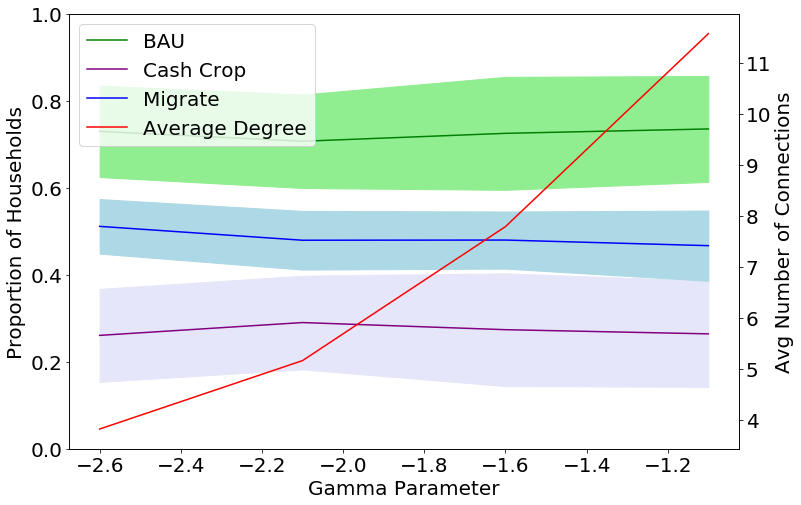

[0.5115 0.4796 0.48   0.4671]
[ 3.8238  5.1654  7.792  11.5742]


In [30]:
#Plot of household strategy outcomes as a function of parameter being varied

#risk_steps = len(agent_size)
#simulations = 10

sim_bau_proportion = np.load('GammaSens[2.5-1]_BAUproportion.npy')
sim_diverse_proportion = np.load('GammaSens[2.5-1]_Diverseproportion.npy')
sim_migrate_proportion = np.load('GammaSens[2.5-1]_Migrateproportion.npy')
average_degree = np.load('GammaSens[2.5-1]_degree.npy')
start_risk_parameter = -2.6
final_risk_parameter = -1.1
risk_steps = 4


avg_set_bau_proportion = np.zeros(risk_steps)
std_set_bau_proportion = np.zeros(risk_steps)
avg_set_bau_proportion_10pct = np.zeros(risk_steps)
avg_set_bau_proportion_90pct = np.zeros(risk_steps)

avg_set_diverse_proportion = np.zeros(risk_steps)
std_set_diverse_proportion = np.zeros(risk_steps)
avg_set_diverse_proportion_10pct = np.zeros(risk_steps)
avg_set_diverse_proportion_90pct = np.zeros(risk_steps)

avg_set_migrate_proportion = np.zeros(risk_steps)
std_set_migrate_proportion = np.zeros(risk_steps)
avg_set_migrate_proportion_10pct = np.zeros(risk_steps)
avg_set_migrate_proportion_90pct = np.zeros(risk_steps)

avg_set_degree = np.zeros(risk_steps)

#sens_remittances_shared = np.zeros(risk_steps)

x = np.linspace(start_risk_parameter, final_risk_parameter, risk_steps)
print(len(sim_bau_proportion[-1,-1,:,-1]))
for a in range(risk_steps):
    avg_set_bau_proportion[a] = np.average(sim_bau_proportion[-1,a,:,-1])
    std_set_bau_proportion[a] = np.std(sim_bau_proportion[-1,a,:,-1])    
    avg_set_bau_proportion_10pct[a] = np.percentile(sim_bau_proportion[-1,a,:,-1], 10.0)
    avg_set_bau_proportion_90pct[a] = np.percentile(sim_bau_proportion[-1,a,:,-1], 90.0)
    avg_set_diverse_proportion[a] = np.average(sim_diverse_proportion[-1,a,:,-1])
    std_set_diverse_proportion[a] = np.std(sim_diverse_proportion[-1,a,:,-1])    
    avg_set_diverse_proportion_10pct[a] = np.percentile(sim_diverse_proportion[-1,a,:,-1], 10.0)
    avg_set_diverse_proportion_90pct[a] = np.percentile(sim_diverse_proportion[-1,a,:,-1], 90.0)
    avg_set_migrate_proportion[a] = np.average(sim_migrate_proportion[-1,a,:,-1])
    std_set_migrate_proportion[a] = np.std(sim_migrate_proportion[-1,a,:,-1])    
    avg_set_migrate_proportion_10pct[a] = np.percentile(sim_migrate_proportion[-1,a,:,-1], 15.9)
    avg_set_migrate_proportion_90pct[a] = np.percentile(sim_migrate_proportion[-1,a,:,-1], 84.1)
    
    avg_set_degree[a] = np.average(average_degree[-1,a,:])

fig, ax1 = plt.subplots(figsize=(12,8))

ax1.plot(x, avg_set_bau_proportion, label='BAU', color='green')
#ax1.fill_between(x, avg_set_bau_proportion_10pct, avg_set_bau_proportion_90pct, color='lightgreen')
ax1.fill_between(x, (avg_set_bau_proportion - std_set_bau_proportion), (avg_set_bau_proportion + std_set_bau_proportion), color='lightgreen')

ax1.plot(x, avg_set_diverse_proportion, label='Cash Crop', color='purple')
#ax1.fill_between(x, avg_set_diverse_proportion_10pct, avg_set_diverse_proportion_90pct, color = 'lavender')
ax1.fill_between(x, (avg_set_diverse_proportion - std_set_diverse_proportion), (avg_set_diverse_proportion + std_set_diverse_proportion), color='lavender')

ax1.plot(x, avg_set_migrate_proportion, label='Migrate', color='blue')
#ax1.fill_between(x, avg_set_migrate_proportion_10pct, avg_set_migrate_proportion_90pct, color = 'lightblue')
ax1.fill_between(x, (avg_set_migrate_proportion - std_set_migrate_proportion), (avg_set_migrate_proportion + std_set_migrate_proportion), color='lightblue')

                        
ax1.set_ylabel('Proportion of Households', fontsize=20)
ax1.set_ylim([0,1])
ax1.set_xlabel('Gamma Parameter', fontsize=20)
plt.xticks(size=20)
plt.yticks(size=20)

ax2=ax1.twinx()
ax2.plot(x, avg_set_degree, label='Average Degree', color='red')
ax2.set_ylabel('Avg Number of Connections', fontsize=20)
plt.yticks(size=20)
#ax1.semilogx()
#ax1.set_xlim([0,5])

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=20)

#ax1.legend(fontsize=20, loc="upper left")

plt.show()
print(avg_set_migrate_proportion)
print(avg_set_degree)



#plt.savefig('GammaSens[2.6-1.1]_Strategies.png', bbox_inches='tight')

#print('Gamma Sens Risk Values:', x, file=open('Layer2_sensitivities_info.txt', 'a'))
#print('Gamma Sens BAU Households final time:', avg_set_bau_proportion, file=open('Layer2_sensitivities_info.txt', 'a'))
#print('Gamma Sens Diverse Households final time:', avg_set_diverse_proportion, file=open('Layer2_sensitivities_info.txt', 'a'))
#print('Gamma Sens Migrate Households final time:', avg_set_migrate_proportion, file=open('Layer2_sensitivities_info.txt', 'a'))



In [ ]:
#Sensitivity of Social Utility to Parameter being varied

avg_final_utility = np.zeros(risk_steps)
avg_final_utility_16pct = np.zeros(risk_steps)
avg_final_utility_84pct = np.zeros(risk_steps)

for a in range(risk_steps):
    avg_final_utility[a] = np.average(sim_cumulative_utility[-1,a,:,-1]) / 1000000
    avg_final_utility_16pct[a] = np.percentile(sim_cumulative_utility[-1,a,:,-1], 15.9) / 1000000
    avg_final_utility_84pct[a] = np.percentile(sim_cumulative_utility[-1,a,:,-1], 84.1) / 1000000
    
x = sim_delta_parameter

fig, ax1 = plt.subplots()
ax1.plot(x, avg_final_utility, color='Orange')
ax1.fill_between(x, avg_final_utility_16pct, avg_final_utility_84pct, color='navajowhite')

ax1.set_ylabel('Household Size')
ax1.set_xlabel('Proportion of Remittances Shared')

plt.show()


#print('Remittance Beta Values:', x, file=open('RiskMechanisms_sensitivities.txt', 'a'))
#print('Remittance Beta Sens Social Utility:', avg_final_utility, file=open('RiskMechanisms_sensitivities.txt', 'a'))

In [ ]:
#Graph of migrant proportion

layer3 = np.load('Layer4T0_migrants.npy')
layer4 = np.load('Layer4TempRiskSens_migrants.npy')

temp_steps = 11
risk_steps = 11
start_temp_parameter = 0
final_temp_parameter = 5

start_risk_parameter = 0
final_risk_parameter = 2

migrant_gap = np.zeros((temp_steps, risk_steps))
y = np.zeros(temp_steps)
x = np.zeros(risk_steps)
ylabels=[]
xlabels=[]




for a in range(temp_steps):
    y[a] = a / (temp_steps-1) * (final_temp_parameter - start_temp_parameter) + start_temp_parameter
    if a % 2 == 0:
        ylabels.append(str('%.1f'%y[a]))
    for b in range(risk_steps):
        x[b] = b / (risk_steps-1) * (final_risk_parameter - start_risk_parameter) + start_risk_parameter
        
        before_migrants = np.average(layer4[0,b,:,-1])
        after_migrants = np.average(layer4[a,b,:,-1])
        migrant_gap[a,b] = (after_migrants)
        
for c in range(risk_steps):
    xlabels.append(str('%.1f'%x[c]))

        
z = migrant_gap
[X,Y] = np.meshgrid(x, y)
level_labels=[]
levels = np.linspace(0.0, 0.7, 15)
for i in range(len(levels)):
    if i % 2 == 0:
        level_labels.append(levels[i]) 


fig, ax = plt.subplots(figsize=[30,8])
contour_map = ax.contourf(X, Y, z, levels, cmap=plt.cm.RdBu)
cbar = fig.colorbar(contour_map, ticks=level_labels)
cbar.ax.set_ylabel('Proportion of Community That Migrates', size=20)
cbar.ax.tick_params(labelsize=20)

ax.set_xlabel('Risk Weighting', size=20)
ax.set_xticks(x)
ax.set_xticklabels(xlabels, size=20)
ax.set_ylim([0,5])
ax.set_ylabel('Temperature Change ($^0C$)', size=20)
ax.set_yticklabels(ylabels, size=20)

plt.text(0.25, 4.25, 'A', size=32)
plt.text(0.5, 1.5, 'B', size=32)
plt.text(1.25, 3.0, 'C', size=32)

#plt.show()



#np.set_printoptions(threshold=100)
plt.savefig('MigrantProportionRiskTempSens.eps', bbox_inches='tight')

#print('Temp Values(y):', y, file=open('SocialUtilityGapAnalysis_RovingPlanner.txt', 'a'))
#print('Risk Weighting Values(x):', x, file=open('SocialUtilityGapAnalysis_RovingPlanner.txt', 'a'))
#print('Roving Planner Absolute Utility Gap(y,x):', utility_gap_avg, file=open('SocialUtilityGapAnalysis_RovingPlanner.txt', 'a'))
